<a href="https://colab.research.google.com/github/subedinab/ML-projects/blob/master/ImageCaption_in_flickerdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/ml

/content/drive/MyDrive/ml


In [ ]:
ls -lah

total 68M
-rw------- 1 root root 3.0M Jul  4 08:11 descriptions.txt
-rw------- 1 root root  64M Jul  4 08:11 features.p
drwx------ 2 root root 4.0K Jul  4 08:18 Flickr8k_Dataset/
drwx------ 2 root root 4.0K Jul  4 08:17 Flickr8k_text/
-rw------- 1 root root 459K Jul  6 06:07 ImageCaption.ipynb
drwx------ 2 root root 4.0K Jul  4 08:19 models/
-rw------- 1 root root 2.3K Jul  4 08:11 testing_caption_generator.py
-rw------- 1 root root 344K Jul  4 08:11 tokenizer.p


In [ ]:
!pip install tensorflow keras pillow numpy tqdm

## import all the necessary packages

In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np


from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm

tqdm().pandas()



0it [00:00, ?it/s]


## Getting and performing data cleaning

In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
# Set these path according to project folder in you system
dataset_text = "/content/drive/MyDrive/ml/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/ml/Flickr8k_Dataset/Flicker8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" , len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file
save_descriptions(clean_descriptions, "/content/drive/MyDrive/ml/descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting the feature vector from all images (TAKES TIME)

In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("/content/drive/MyDrive/ml/features.p","wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


  0%|          | 1/8091 [00:11<26:14:10, 11.68s/it]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/8091 [00:11<11:11:23,  4.98s/it]

1/1 [==============================] - 0s 26ms/step


  0%|          | 3/8091 [00:12<6:20:13,  2.82s/it] 

1/1 [==============================] - 0s 27ms/step


  0%|          | 4/8091 [00:12<4:07:11,  1.83s/it]

1/1 [==============================] - 0s 28ms/step


  0%|          | 5/8091 [00:12<2:51:58,  1.28s/it]

1/1 [==============================] - 0s 27ms/step


  0%|          | 6/8091 [00:13<2:07:04,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 7/8091 [00:13<1:38:40,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 8/8091 [00:13<1:18:41,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 9/8091 [00:14<1:07:12,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 10/8091 [00:14<59:47,  2.25it/s] 

1/1 [==============================] - 0s 27ms/step


  0%|          | 11/8091 [00:14<51:50,  2.60it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 12/8091 [00:14<45:57,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 13/8091 [00:15<43:28,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 14/8091 [00:15<43:47,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 15/8091 [00:15<40:38,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 16/8091 [00:15<38:59,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 17/8091 [00:16<41:36,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 18/8091 [00:16<39:42,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 19/8091 [00:16<40:26,  3.33it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 20/8091 [00:17<49:08,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 21/8091 [00:17<45:14,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 22/8091 [00:17<42:10,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 23/8091 [00:18<47:44,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 24/8091 [00:18<44:42,  3.01it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 25/8091 [00:18<41:47,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 26/8091 [00:19<45:00,  2.99it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 27/8091 [00:19<41:06,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 28/8091 [00:19<41:22,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 29/8091 [00:20<45:56,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 30/8091 [00:20<46:57,  2.86it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 31/8091 [00:20<47:25,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 32/8091 [00:21<45:43,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 33/8091 [00:21<46:25,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 34/8091 [00:21<45:12,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 35/8091 [00:22<45:12,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 36/8091 [00:22<43:41,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 37/8091 [00:22<40:31,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 38/8091 [00:23<40:26,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 39/8091 [00:23<39:30,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 40/8091 [00:23<38:59,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 41/8091 [00:24<39:45,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 42/8091 [00:24<38:24,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 43/8091 [00:24<39:23,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 44/8091 [00:24<37:06,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 45/8091 [00:25<38:26,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 46/8091 [00:25<38:02,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 47/8091 [00:25<39:11,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 48/8091 [00:26<38:09,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 49/8091 [00:26<35:53,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 50/8091 [00:26<39:17,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 51/8091 [00:26<39:04,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 52/8091 [00:27<37:18,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 53/8091 [00:27<37:36,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 54/8091 [00:27<37:56,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 55/8091 [00:28<44:30,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 56/8091 [00:28<43:15,  3.10it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 57/8091 [00:28<39:53,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 58/8091 [00:28<39:01,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 59/8091 [00:29<41:10,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 60/8091 [00:29<40:11,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 61/8091 [00:29<39:05,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 62/8091 [00:30<40:10,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 63/8091 [00:30<42:00,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 64/8091 [00:30<39:25,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 65/8091 [00:31<40:45,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 66/8091 [00:31<40:44,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 67/8091 [00:31<39:25,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 68/8091 [00:31<37:06,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 69/8091 [00:32<36:04,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 70/8091 [00:32<34:15,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 71/8091 [00:32<34:03,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 72/8091 [00:32<35:16,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 73/8091 [00:33<36:39,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 74/8091 [00:33<35:20,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 75/8091 [00:33<38:10,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 76/8091 [00:34<40:22,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 77/8091 [00:34<44:32,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 78/8091 [00:34<42:24,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 79/8091 [00:35<41:49,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 80/8091 [00:35<39:37,  3.37it/s]

1/1 [==============================] - 0s 101ms/step


  1%|          | 81/8091 [00:35<51:35,  2.59it/s]

1/1 [==============================] - 0s 324ms/step


  1%|          | 82/8091 [01:31<37:43:46, 16.96s/it]

1/1 [==============================] - 0s 343ms/step


  1%|          | 83/8091 [02:25<62:03:51, 27.90s/it]

1/1 [==============================] - 0s 131ms/step


  1%|          | 84/8091 [03:21<81:09:31, 36.49s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 85/8091 [03:36<67:04:34, 30.16s/it]

1/1 [==============================] - 0s 28ms/step


  1%|          | 86/8091 [03:37<47:00:57, 21.14s/it]

1/1 [==============================] - 0s 26ms/step


  1%|          | 88/8091 [03:37<25:24:10, 11.43s/it]

1/1 [==============================] - 0s 29ms/step


  1%|          | 89/8091 [03:37<19:09:27,  8.62s/it]

1/1 [==============================] - 0s 27ms/step


  1%|          | 91/8091 [03:37<11:17:59,  5.08s/it]

1/1 [==============================] - 0s 35ms/step


  1%|          | 92/8091 [03:37<8:46:33,  3.95s/it] 

1/1 [==============================] - 0s 29ms/step


  1%|          | 93/8091 [03:37<6:40:19,  3.00s/it]

1/1 [==============================] - 0s 28ms/step


  1%|          | 95/8091 [03:37<4:00:17,  1.80s/it]

1/1 [==============================] - 0s 28ms/step


  1%|          | 97/8091 [03:38<2:35:53,  1.17s/it]

1/1 [==============================] - 0s 26ms/step


  1%|          | 99/8091 [03:38<1:46:21,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 100/8091 [03:38<1:28:07,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 102/8091 [03:38<1:00:48,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 104/8091 [03:38<44:28,  2.99it/s]  

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 106/8091 [03:39<33:58,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 108/8091 [03:39<27:03,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 110/8091 [03:39<22:31,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 112/8091 [03:39<19:41,  6.75it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 114/8091 [03:39<17:20,  7.67it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 116/8091 [03:39<16:00,  8.31it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 118/8091 [03:40<14:46,  8.99it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 120/8091 [03:40<14:19,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 122/8091 [03:40<13:46,  9.65it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 124/8091 [03:40<13:27,  9.86it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 126/8091 [03:40<13:00, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 128/8091 [03:41<12:42, 10.44it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 130/8091 [03:41<13:19,  9.96it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 132/8091 [03:41<14:14,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 133/8091 [03:41<14:46,  8.98it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 134/8091 [03:41<15:13,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 135/8091 [03:41<15:31,  8.54it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 136/8091 [03:42<15:54,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 137/8091 [03:42<16:11,  8.19it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 138/8091 [03:42<16:45,  7.91it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 139/8091 [03:42<16:57,  7.82it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 140/8091 [03:42<17:11,  7.71it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 141/8091 [03:42<18:15,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 142/8091 [03:42<17:52,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 143/8091 [03:43<17:56,  7.38it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 144/8091 [03:43<17:56,  7.38it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 145/8091 [03:43<18:24,  7.20it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 146/8091 [03:43<18:04,  7.32it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 147/8091 [03:43<18:22,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 148/8091 [03:43<18:45,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 149/8091 [03:43<18:50,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 150/8091 [03:44<18:35,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 151/8091 [03:44<17:54,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 152/8091 [03:44<17:55,  7.38it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 153/8091 [03:44<17:33,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 154/8091 [03:44<17:25,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 155/8091 [03:44<17:41,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 156/8091 [03:44<18:50,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 157/8091 [03:44<18:36,  7.11it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 158/8091 [03:45<19:55,  6.64it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 159/8091 [03:45<20:42,  6.38it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 160/8091 [03:45<19:52,  6.65it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 161/8091 [03:45<19:01,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 162/8091 [03:45<18:08,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 163/8091 [03:45<16:43,  7.90it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 164/8091 [03:45<16:20,  8.09it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 165/8091 [03:46<15:51,  8.33it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 167/8091 [03:46<14:19,  9.22it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 169/8091 [03:46<13:32,  9.75it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 171/8091 [03:46<13:09, 10.03it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 173/8091 [03:46<13:08, 10.04it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 174/8091 [03:46<13:31,  9.76it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 176/8091 [03:47<13:15,  9.95it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 177/8091 [03:47<13:17,  9.92it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 178/8091 [03:47<13:19,  9.90it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 180/8091 [03:47<13:09, 10.02it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 182/8091 [03:47<12:55, 10.20it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 184/8091 [03:47<13:27,  9.79it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 185/8091 [03:48<13:24,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 186/8091 [03:48<13:28,  9.78it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 188/8091 [03:48<12:57, 10.17it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 190/8091 [03:48<12:51, 10.24it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 192/8091 [03:48<12:48, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 194/8091 [03:48<13:02, 10.09it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 196/8091 [03:49<12:48, 10.28it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 198/8091 [03:49<12:37, 10.42it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 200/8091 [03:49<12:38, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 202/8091 [03:49<12:54, 10.19it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 204/8091 [03:49<12:52, 10.21it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 206/8091 [03:50<12:51, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 208/8091 [03:50<12:52, 10.20it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 210/8091 [03:50<12:58, 10.12it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 212/8091 [03:50<12:47, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 214/8091 [03:50<12:39, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 216/8091 [03:51<12:46, 10.28it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 218/8091 [03:51<12:33, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 220/8091 [03:51<12:43, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 222/8091 [03:51<12:33, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 224/8091 [03:51<12:42, 10.32it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 226/8091 [03:52<12:54, 10.15it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 228/8091 [03:52<13:07,  9.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 230/8091 [03:52<12:53, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 232/8091 [03:52<12:56, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 234/8091 [03:52<12:48, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 236/8091 [03:53<12:54, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 238/8091 [03:53<12:59, 10.08it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 240/8091 [03:53<12:56, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 242/8091 [03:53<12:47, 10.23it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 244/8091 [03:53<12:36, 10.37it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 246/8091 [03:53<12:46, 10.24it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 248/8091 [03:54<13:01, 10.04it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 250/8091 [03:54<12:45, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 252/8091 [03:54<12:37, 10.35it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 254/8091 [03:54<12:24, 10.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 256/8091 [03:54<12:39, 10.32it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 258/8091 [03:55<13:10,  9.90it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 260/8091 [03:55<12:57, 10.07it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 262/8091 [03:55<12:56, 10.08it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 264/8091 [03:55<13:37,  9.57it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 265/8091 [03:55<14:40,  8.89it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 266/8091 [03:56<15:13,  8.56it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 267/8091 [03:56<16:07,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 268/8091 [03:56<16:46,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 269/8091 [03:56<16:50,  7.74it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 270/8091 [03:56<16:38,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 271/8091 [03:56<18:09,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 272/8091 [03:56<18:17,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 273/8091 [03:57<18:06,  7.20it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 274/8091 [03:57<18:31,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 275/8091 [03:57<18:02,  7.22it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 276/8091 [03:57<17:53,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 277/8091 [03:57<17:48,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 278/8091 [03:57<17:13,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 279/8091 [03:57<17:48,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 280/8091 [03:58<17:30,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 281/8091 [03:58<17:55,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 282/8091 [03:58<17:48,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 283/8091 [03:58<17:32,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 284/8091 [03:58<18:06,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 285/8091 [03:58<17:49,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 286/8091 [03:58<17:44,  7.33it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 287/8091 [03:58<17:30,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 288/8091 [03:59<17:48,  7.30it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 289/8091 [03:59<18:58,  6.85it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 290/8091 [03:59<19:00,  6.84it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 291/8091 [03:59<18:54,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 292/8091 [03:59<18:07,  7.17it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 293/8091 [03:59<17:40,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 294/8091 [03:59<17:09,  7.57it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 295/8091 [04:00<16:39,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 297/8091 [04:00<14:30,  8.96it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 299/8091 [04:00<13:52,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 301/8091 [04:00<13:14,  9.80it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 303/8091 [04:00<12:48, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 305/8091 [04:01<12:42, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 307/8091 [04:01<14:36,  8.88it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 308/8091 [04:01<14:35,  8.89it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 309/8091 [04:01<14:25,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 311/8091 [04:01<13:44,  9.43it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 313/8091 [04:01<13:20,  9.72it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 315/8091 [04:02<12:58,  9.98it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 316/8091 [04:02<12:58,  9.99it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 317/8091 [04:02<13:13,  9.80it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 318/8091 [04:02<13:18,  9.74it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 320/8091 [04:02<13:30,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 322/8091 [04:02<12:58,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 324/8091 [04:03<12:45, 10.14it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 326/8091 [04:03<12:40, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 328/8091 [04:03<12:35, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 330/8091 [04:03<12:43, 10.17it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 332/8091 [04:03<12:35, 10.27it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 334/8091 [04:03<12:28, 10.36it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 336/8091 [04:04<12:39, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 338/8091 [04:04<12:39, 10.21it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 340/8091 [04:04<12:52, 10.03it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 342/8091 [04:04<12:42, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 344/8091 [04:04<12:37, 10.22it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 346/8091 [04:05<12:31, 10.30it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 348/8091 [04:05<12:29, 10.33it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 350/8091 [04:05<12:36, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 352/8091 [04:05<12:36, 10.23it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 354/8091 [04:05<12:54,  9.99it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 356/8091 [04:06<12:50, 10.04it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 358/8091 [04:06<12:43, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 360/8091 [04:06<12:39, 10.18it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 362/8091 [04:06<12:45, 10.10it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 364/8091 [04:06<13:00,  9.90it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 366/8091 [04:07<12:44, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 368/8091 [04:07<12:43, 10.12it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 370/8091 [04:07<12:54,  9.97it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 371/8091 [04:07<13:32,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 372/8091 [04:07<13:29,  9.54it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 373/8091 [04:07<13:21,  9.63it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 374/8091 [04:07<13:32,  9.50it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 375/8091 [04:08<13:34,  9.47it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 376/8091 [04:08<13:30,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 378/8091 [04:08<13:02,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 379/8091 [04:08<13:29,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 380/8091 [04:08<13:44,  9.36it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 381/8091 [04:08<13:34,  9.47it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 382/8091 [04:08<13:29,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 383/8091 [04:08<13:37,  9.42it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 384/8091 [04:09<13:28,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 386/8091 [04:09<12:58,  9.89it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 387/8091 [04:09<12:59,  9.89it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 388/8091 [04:09<13:09,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 389/8091 [04:09<13:13,  9.71it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 390/8091 [04:09<13:14,  9.69it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 391/8091 [04:09<13:11,  9.73it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 392/8091 [04:09<13:11,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 394/8091 [04:10<12:44, 10.06it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 395/8091 [04:10<13:50,  9.26it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▍         | 396/8091 [04:10<15:15,  8.41it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 397/8091 [04:10<15:58,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 398/8091 [04:10<17:08,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 399/8091 [04:10<17:10,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 400/8091 [04:10<17:35,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 401/8091 [04:11<17:31,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 402/8091 [04:11<18:03,  7.10it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 403/8091 [04:11<18:02,  7.10it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 404/8091 [04:11<17:38,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 405/8091 [04:11<17:10,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 406/8091 [04:11<19:18,  6.63it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 407/8091 [04:11<19:06,  6.70it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 408/8091 [04:12<18:53,  6.78it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 409/8091 [04:12<18:46,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 410/8091 [04:12<18:17,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 411/8091 [04:12<17:56,  7.13it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 412/8091 [04:12<18:12,  7.03it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 413/8091 [04:12<18:37,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 414/8091 [04:12<18:03,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 415/8091 [04:13<18:15,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 416/8091 [04:13<17:57,  7.12it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 417/8091 [04:13<18:00,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 418/8091 [04:13<18:00,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 419/8091 [04:13<17:26,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 420/8091 [04:13<17:40,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 421/8091 [04:13<17:30,  7.30it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 422/8091 [04:14<17:35,  7.26it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 423/8091 [04:14<17:33,  7.28it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 424/8091 [04:14<18:21,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 425/8091 [04:14<18:18,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 426/8091 [04:14<17:32,  7.28it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 428/8091 [04:14<15:09,  8.42it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 429/8091 [04:14<14:48,  8.62it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 430/8091 [04:14<14:33,  8.77it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 432/8091 [04:15<13:31,  9.44it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 433/8091 [04:15<13:37,  9.36it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 435/8091 [04:15<13:18,  9.59it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 437/8091 [04:15<12:49,  9.95it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 439/8091 [04:15<12:50,  9.94it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 441/8091 [04:16<12:30, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 443/8091 [04:16<12:44, 10.00it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 445/8091 [04:16<12:33, 10.15it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 447/8091 [04:16<12:34, 10.13it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 449/8091 [04:16<12:19, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 451/8091 [04:17<12:15, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 453/8091 [04:17<12:17, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 455/8091 [04:17<12:12, 10.43it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 457/8091 [04:17<12:25, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 459/8091 [04:17<12:17, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 461/8091 [04:18<13:34,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 462/8091 [04:18<13:25,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 464/8091 [04:18<12:55,  9.84it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 466/8091 [04:18<12:35, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 468/8091 [04:18<12:31, 10.15it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 470/8091 [04:18<13:13,  9.61it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 471/8091 [04:19<13:08,  9.66it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 473/8091 [04:19<12:47,  9.93it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 475/8091 [04:19<12:36, 10.07it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 477/8091 [04:19<12:51,  9.86it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 478/8091 [04:19<13:10,  9.63it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 480/8091 [04:19<12:54,  9.83it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 482/8091 [04:20<12:30, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 484/8091 [04:20<12:30, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 486/8091 [04:20<12:34, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 488/8091 [04:20<12:27, 10.17it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 490/8091 [04:20<12:23, 10.22it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 492/8091 [04:21<12:41,  9.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 494/8091 [04:21<12:27, 10.16it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 496/8091 [04:21<12:30, 10.12it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 498/8091 [04:21<12:21, 10.23it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 500/8091 [04:21<12:39, 10.00it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 502/8091 [04:22<12:35, 10.04it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 504/8091 [04:22<12:43,  9.94it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 506/8091 [04:22<12:31, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 508/8091 [04:22<12:37, 10.00it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 510/8091 [04:22<12:53,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 511/8091 [04:23<12:55,  9.77it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 512/8091 [04:23<12:52,  9.81it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 513/8091 [04:23<13:03,  9.67it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 514/8091 [04:23<13:18,  9.49it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 515/8091 [04:23<13:17,  9.50it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 517/8091 [04:23<12:52,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 518/8091 [04:23<12:58,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 520/8091 [04:23<12:51,  9.81it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 521/8091 [04:24<13:06,  9.62it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 522/8091 [04:24<13:23,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 524/8091 [04:24<12:46,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 525/8091 [04:24<12:48,  9.85it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 526/8091 [04:24<13:50,  9.11it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 527/8091 [04:24<16:03,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 528/8091 [04:24<16:24,  7.68it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 529/8091 [04:25<16:28,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 530/8091 [04:25<17:16,  7.29it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 531/8091 [04:25<18:07,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 532/8091 [04:25<17:44,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 533/8091 [04:25<17:37,  7.15it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 534/8091 [04:25<17:56,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 535/8091 [04:25<17:56,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 536/8091 [04:26<19:15,  6.54it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 537/8091 [04:26<19:04,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 538/8091 [04:26<18:33,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 539/8091 [04:26<18:28,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 540/8091 [04:26<18:14,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 541/8091 [04:26<17:50,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 542/8091 [04:26<17:08,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 543/8091 [04:27<17:28,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 544/8091 [04:27<17:47,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 545/8091 [04:27<17:52,  7.03it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 546/8091 [04:27<19:01,  6.61it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 547/8091 [04:27<18:05,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 548/8091 [04:27<18:22,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 549/8091 [04:27<18:01,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 550/8091 [04:28<18:01,  6.97it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 551/8091 [04:28<18:12,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 552/8091 [04:28<17:44,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 553/8091 [04:28<17:18,  7.26it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 554/8091 [04:28<17:33,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 555/8091 [04:28<17:30,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 556/8091 [04:28<16:49,  7.46it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 557/8091 [04:29<16:42,  7.52it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 559/8091 [04:29<14:46,  8.49it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 560/8091 [04:29<14:19,  8.76it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 562/8091 [04:29<13:18,  9.43it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 564/8091 [04:29<12:44,  9.85it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 566/8091 [04:29<12:58,  9.67it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 567/8091 [04:30<13:11,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 569/8091 [04:30<13:04,  9.59it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 571/8091 [04:30<12:52,  9.73it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 573/8091 [04:30<12:33,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 574/8091 [04:30<12:34,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 575/8091 [04:30<12:58,  9.65it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 576/8091 [04:31<12:54,  9.70it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 577/8091 [04:31<12:56,  9.67it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 578/8091 [04:31<12:58,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 579/8091 [04:31<12:56,  9.67it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 581/8091 [04:31<12:37,  9.92it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 582/8091 [04:31<12:38,  9.90it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 583/8091 [04:31<12:44,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 584/8091 [04:31<13:16,  9.42it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 586/8091 [04:32<12:45,  9.80it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 587/8091 [04:32<12:46,  9.79it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 588/8091 [04:32<12:43,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 589/8091 [04:32<13:11,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 590/8091 [04:32<13:20,  9.37it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 591/8091 [04:32<13:21,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 592/8091 [04:32<13:28,  9.27it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 593/8091 [04:32<14:24,  8.67it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 594/8091 [04:32<14:02,  8.90it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 595/8091 [04:33<13:47,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 596/8091 [04:33<14:59,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 597/8091 [04:33<14:20,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 598/8091 [04:33<14:05,  8.87it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 599/8091 [04:33<13:53,  8.98it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 601/8091 [04:33<13:07,  9.52it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 603/8091 [04:33<12:35,  9.91it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 604/8091 [04:33<12:41,  9.83it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 606/8091 [04:34<12:30,  9.97it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 608/8091 [04:34<12:21, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 609/8091 [04:34<12:27, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 610/8091 [04:34<12:35,  9.90it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 611/8091 [04:34<12:45,  9.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 613/8091 [04:34<12:32,  9.94it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 614/8091 [04:34<12:37,  9.87it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 615/8091 [04:35<12:41,  9.82it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 617/8091 [04:35<12:19, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 618/8091 [04:35<12:27,  9.99it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 619/8091 [04:35<12:51,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 621/8091 [04:35<12:32,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 622/8091 [04:35<12:32,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 623/8091 [04:35<12:41,  9.80it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 625/8091 [04:36<12:15, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 627/8091 [04:36<12:25, 10.01it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 628/8091 [04:36<12:30,  9.94it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 629/8091 [04:36<12:45,  9.75it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 631/8091 [04:36<12:28,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 633/8091 [04:36<12:11, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 635/8091 [04:37<12:10, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 637/8091 [04:37<12:21, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 639/8091 [04:37<12:29,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 640/8091 [04:37<12:36,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 642/8091 [04:37<12:18, 10.09it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 644/8091 [04:37<12:15, 10.13it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 646/8091 [04:38<12:38,  9.82it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 647/8091 [04:38<12:37,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 649/8091 [04:38<12:13, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 651/8091 [04:38<12:21, 10.03it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 653/8091 [04:38<13:03,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 655/8091 [04:39<13:17,  9.32it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 656/8091 [04:39<14:11,  8.73it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 657/8091 [04:39<14:40,  8.44it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 658/8091 [04:39<15:49,  7.83it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 659/8091 [04:39<16:09,  7.67it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 660/8091 [04:39<16:39,  7.44it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 661/8091 [04:39<16:50,  7.35it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 662/8091 [04:40<17:38,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 663/8091 [04:40<17:45,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 664/8091 [04:40<17:12,  7.19it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 665/8091 [04:40<17:35,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 666/8091 [04:40<18:10,  6.81it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 667/8091 [04:40<18:33,  6.67it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 668/8091 [04:41<18:13,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 669/8091 [04:41<17:39,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 670/8091 [04:41<17:45,  6.97it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 671/8091 [04:41<17:27,  7.08it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 672/8091 [04:41<17:50,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 673/8091 [04:41<17:51,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 674/8091 [04:41<18:13,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 675/8091 [04:42<17:27,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 676/8091 [04:42<17:24,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 677/8091 [04:42<17:48,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 678/8091 [04:42<17:29,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 679/8091 [04:42<17:17,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 680/8091 [04:42<17:12,  7.17it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 681/8091 [04:42<17:17,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 682/8091 [04:43<17:32,  7.04it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 683/8091 [04:43<17:15,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 684/8091 [04:43<17:25,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 685/8091 [04:43<17:08,  7.20it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 686/8091 [04:43<18:26,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 687/8091 [04:43<18:57,  6.51it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 689/8091 [04:43<15:50,  7.78it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 690/8091 [04:44<15:00,  8.22it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 691/8091 [04:44<14:28,  8.52it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 692/8091 [04:44<13:58,  8.82it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 693/8091 [04:44<13:35,  9.08it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 695/8091 [04:44<12:55,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 697/8091 [04:44<12:38,  9.74it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 698/8091 [04:44<12:57,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 699/8091 [04:45<13:36,  9.05it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 700/8091 [04:45<13:38,  9.03it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 702/8091 [04:45<12:57,  9.50it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 703/8091 [04:45<12:51,  9.58it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 704/8091 [04:45<12:54,  9.53it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 706/8091 [04:45<12:28,  9.87it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 707/8091 [04:45<12:37,  9.74it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 708/8091 [04:45<12:58,  9.48it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 710/8091 [04:46<12:41,  9.69it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 711/8091 [04:46<12:38,  9.73it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 712/8091 [04:46<12:45,  9.64it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 713/8091 [04:46<12:40,  9.71it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 715/8091 [04:46<12:24,  9.90it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 716/8091 [04:46<12:24,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 717/8091 [04:46<13:06,  9.38it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 718/8091 [04:46<13:11,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 720/8091 [04:47<12:46,  9.61it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 722/8091 [04:47<12:26,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 724/8091 [04:47<12:06, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 726/8091 [04:47<12:18,  9.98it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 727/8091 [04:47<12:48,  9.58it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 728/8091 [04:47<12:51,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 730/8091 [04:48<12:25,  9.88it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 731/8091 [04:48<13:32,  9.06it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 733/8091 [04:48<12:54,  9.50it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 734/8091 [04:48<12:50,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 735/8091 [04:48<12:59,  9.44it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 736/8091 [04:48<13:06,  9.35it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 737/8091 [04:48<13:05,  9.36it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 739/8091 [04:49<12:29,  9.81it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 740/8091 [04:49<12:40,  9.67it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 742/8091 [04:49<12:24,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 744/8091 [04:49<12:19,  9.93it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 745/8091 [04:49<12:19,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 747/8091 [04:49<12:36,  9.71it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 748/8091 [04:50<12:36,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 749/8091 [04:50<12:45,  9.59it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 750/8091 [04:50<12:52,  9.51it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 751/8091 [04:50<12:57,  9.44it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 752/8091 [04:50<13:00,  9.41it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 753/8091 [04:50<14:32,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 754/8091 [04:50<14:14,  8.58it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 755/8091 [04:50<13:48,  8.85it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 756/8091 [04:50<13:43,  8.91it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 757/8091 [04:51<13:44,  8.89it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 758/8091 [04:51<13:19,  9.17it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 759/8091 [04:51<13:09,  9.28it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 760/8091 [04:51<13:08,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 761/8091 [04:51<13:31,  9.04it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 762/8091 [04:51<13:10,  9.28it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 763/8091 [04:51<13:07,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 764/8091 [04:51<13:31,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 765/8091 [04:51<13:31,  9.03it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 766/8091 [04:52<13:09,  9.28it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 767/8091 [04:52<13:03,  9.34it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 768/8091 [04:52<12:53,  9.47it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 769/8091 [04:52<12:47,  9.54it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 770/8091 [04:52<13:22,  9.13it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 771/8091 [04:52<13:14,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 772/8091 [04:52<13:04,  9.33it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 773/8091 [04:52<12:57,  9.41it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 774/8091 [04:52<12:49,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 775/8091 [04:53<13:05,  9.31it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 776/8091 [04:53<12:54,  9.45it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 777/8091 [04:53<14:18,  8.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 778/8091 [04:53<13:51,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 779/8091 [04:53<13:56,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 780/8091 [04:53<13:51,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 782/8091 [04:53<13:12,  9.22it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 783/8091 [04:53<14:01,  8.68it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 784/8091 [04:54<15:05,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 785/8091 [04:54<15:17,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 786/8091 [04:54<16:14,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 787/8091 [04:54<16:28,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 788/8091 [04:54<17:17,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 789/8091 [04:54<17:09,  7.09it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 790/8091 [04:54<17:38,  6.90it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 791/8091 [04:55<17:50,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 792/8091 [04:55<19:09,  6.35it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 793/8091 [04:55<18:25,  6.60it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 794/8091 [04:55<17:41,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 795/8091 [04:55<17:36,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 796/8091 [04:55<17:30,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 797/8091 [04:56<19:14,  6.32it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 798/8091 [04:56<18:25,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 799/8091 [04:56<17:33,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 800/8091 [04:56<16:43,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 801/8091 [04:56<16:12,  7.50it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 802/8091 [04:56<15:53,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 803/8091 [04:56<16:05,  7.55it/s]

1/1 [==============================] - 0s 52ms/step


 10%|▉         | 804/8091 [04:56<17:03,  7.12it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 805/8091 [04:57<17:57,  6.76it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 806/8091 [04:57<18:17,  6.64it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 807/8091 [04:57<17:50,  6.81it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 808/8091 [04:57<17:29,  6.94it/s]

1/1 [==============================] - 0s 55ms/step


 10%|▉         | 809/8091 [04:57<19:38,  6.18it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 810/8091 [04:57<18:45,  6.47it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 811/8091 [04:58<18:44,  6.47it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 812/8091 [04:58<18:22,  6.60it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 813/8091 [04:58<19:53,  6.10it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 814/8091 [04:58<19:06,  6.35it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 815/8091 [04:58<18:34,  6.53it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 816/8091 [04:58<17:04,  7.10it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 817/8091 [04:58<16:04,  7.54it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 818/8091 [04:59<14:59,  8.09it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 819/8091 [04:59<14:24,  8.41it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 820/8091 [04:59<14:11,  8.54it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 822/8091 [04:59<13:04,  9.26it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 823/8091 [04:59<12:59,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 824/8091 [04:59<13:08,  9.21it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 825/8091 [04:59<13:00,  9.31it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 827/8091 [04:59<12:25,  9.74it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 828/8091 [05:00<12:21,  9.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 829/8091 [05:00<12:36,  9.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 830/8091 [05:00<12:37,  9.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 831/8091 [05:00<12:50,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 832/8091 [05:00<12:58,  9.33it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 833/8091 [05:00<12:55,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 834/8091 [05:00<14:16,  8.47it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 835/8091 [05:00<13:45,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 836/8091 [05:00<13:57,  8.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 837/8091 [05:01<13:41,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 838/8091 [05:01<13:17,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 839/8091 [05:01<13:25,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 841/8091 [05:01<13:02,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 842/8091 [05:01<23:07,  5.22it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 843/8091 [05:02<20:33,  5.88it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 844/8091 [05:02<18:45,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 845/8091 [05:02<17:34,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 846/8091 [05:02<16:34,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 847/8091 [05:02<15:47,  7.64it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 848/8091 [05:02<15:05,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 849/8091 [05:02<14:39,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 850/8091 [05:02<15:23,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 851/8091 [05:02<15:02,  8.02it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 852/8091 [05:03<15:51,  7.61it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 853/8091 [05:03<15:11,  7.94it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 854/8091 [05:03<15:07,  7.98it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 855/8091 [05:03<14:52,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 856/8091 [05:03<14:37,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 857/8091 [05:03<14:38,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 858/8091 [05:03<14:04,  8.56it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 859/8091 [05:03<14:11,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 860/8091 [05:04<13:41,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 861/8091 [05:04<13:47,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 862/8091 [05:04<13:46,  8.75it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 863/8091 [05:04<14:02,  8.58it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 864/8091 [05:04<13:47,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 865/8091 [05:04<13:33,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 866/8091 [05:04<13:25,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 867/8091 [05:04<13:32,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 868/8091 [05:04<13:51,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 869/8091 [05:05<14:13,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 870/8091 [05:05<14:25,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 871/8091 [05:05<14:13,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 872/8091 [05:05<14:35,  8.24it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 873/8091 [05:05<13:55,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 874/8091 [05:05<13:49,  8.70it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 875/8091 [05:05<14:03,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 876/8091 [05:05<13:42,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 877/8091 [05:06<14:37,  8.22it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 878/8091 [05:06<14:19,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 879/8091 [05:06<14:14,  8.44it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 880/8091 [05:06<14:18,  8.40it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 881/8091 [05:06<14:05,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 882/8091 [05:06<14:14,  8.43it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 883/8091 [05:06<15:41,  7.65it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 884/8091 [05:06<15:03,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 885/8091 [05:07<15:17,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 886/8091 [05:07<14:38,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 887/8091 [05:07<14:26,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 888/8091 [05:07<14:21,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 889/8091 [05:07<14:29,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 890/8091 [05:07<14:08,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 891/8091 [05:07<13:59,  8.57it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 892/8091 [05:07<13:57,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 893/8091 [05:07<13:48,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 894/8091 [05:08<14:26,  8.31it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 895/8091 [05:08<14:54,  8.05it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 896/8091 [05:08<14:29,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 897/8091 [05:08<14:21,  8.35it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 898/8091 [05:08<14:01,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 899/8091 [05:08<14:09,  8.47it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█         | 900/8091 [05:08<16:19,  7.34it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 901/8091 [05:09<18:45,  6.39it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 902/8091 [05:09<18:36,  6.44it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 903/8091 [05:09<18:46,  6.38it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 904/8091 [05:09<19:18,  6.20it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 905/8091 [05:09<19:11,  6.24it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 906/8091 [05:09<18:58,  6.31it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 907/8091 [05:10<18:59,  6.30it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 908/8091 [05:10<19:10,  6.24it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 909/8091 [05:10<19:16,  6.21it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 910/8091 [05:10<18:56,  6.32it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█▏        | 911/8091 [05:10<19:57,  6.00it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 912/8091 [05:10<19:34,  6.11it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 913/8091 [05:10<19:02,  6.28it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 914/8091 [05:11<18:54,  6.32it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 915/8091 [05:11<18:51,  6.34it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█▏        | 916/8091 [05:11<19:39,  6.09it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 917/8091 [05:11<19:47,  6.04it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 918/8091 [05:11<19:33,  6.12it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 919/8091 [05:11<19:20,  6.18it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 920/8091 [05:12<19:05,  6.26it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 921/8091 [05:12<19:06,  6.25it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 922/8091 [05:12<19:04,  6.27it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 923/8091 [05:12<18:46,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 924/8091 [05:12<18:43,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 925/8091 [05:12<18:16,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 926/8091 [05:13<18:03,  6.61it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 927/8091 [05:13<17:18,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 928/8091 [05:13<17:40,  6.76it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 929/8091 [05:13<18:39,  6.39it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 930/8091 [05:13<17:06,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 931/8091 [05:13<15:55,  7.49it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 932/8091 [05:13<14:44,  8.09it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 933/8091 [05:13<14:52,  8.02it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 934/8091 [05:14<14:25,  8.27it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 935/8091 [05:14<13:48,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 936/8091 [05:14<13:38,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 937/8091 [05:14<13:19,  8.95it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 938/8091 [05:14<13:23,  8.90it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 939/8091 [05:14<13:11,  9.03it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 940/8091 [05:14<13:29,  8.84it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 941/8091 [05:14<13:10,  9.05it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 942/8091 [05:14<13:20,  8.93it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 943/8091 [05:15<13:08,  9.06it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 944/8091 [05:15<13:04,  9.12it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 945/8091 [05:15<12:53,  9.24it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 946/8091 [05:15<12:58,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 947/8091 [05:15<13:26,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 948/8091 [05:15<13:10,  9.04it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 949/8091 [05:15<12:58,  9.17it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 950/8091 [05:15<13:00,  9.15it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 951/8091 [05:15<12:44,  9.33it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 952/8091 [05:16<12:37,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 954/8091 [05:16<12:09,  9.79it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 955/8091 [05:16<12:29,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 956/8091 [05:16<12:50,  9.26it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 957/8091 [05:16<12:54,  9.22it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 958/8091 [05:16<12:49,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 959/8091 [05:16<13:14,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 961/8091 [05:16<12:32,  9.48it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 962/8091 [05:17<12:27,  9.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 963/8091 [05:17<12:40,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 964/8091 [05:17<12:35,  9.43it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 965/8091 [05:17<12:56,  9.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 966/8091 [05:17<12:43,  9.33it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 967/8091 [05:17<12:38,  9.39it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 968/8091 [05:17<13:48,  8.60it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 970/8091 [05:17<12:49,  9.25it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 971/8091 [05:18<12:43,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 972/8091 [05:18<12:38,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 973/8091 [05:18<12:41,  9.34it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 974/8091 [05:18<12:58,  9.14it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 975/8091 [05:18<12:53,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 976/8091 [05:18<13:59,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 977/8091 [05:18<13:25,  8.84it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 978/8091 [05:18<13:50,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 979/8091 [05:18<13:46,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 980/8091 [05:19<13:25,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 981/8091 [05:19<13:04,  9.07it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 982/8091 [05:19<13:10,  8.99it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 983/8091 [05:19<13:03,  9.08it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 984/8091 [05:19<12:53,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 985/8091 [05:19<12:45,  9.28it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 986/8091 [05:19<12:44,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 987/8091 [05:19<13:14,  8.95it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 988/8091 [05:19<13:10,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 989/8091 [05:20<12:47,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 990/8091 [05:20<13:06,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 991/8091 [05:20<13:19,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 992/8091 [05:20<13:19,  8.88it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 993/8091 [05:20<12:56,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 994/8091 [05:20<13:07,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 995/8091 [05:20<12:57,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 996/8091 [05:20<14:28,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 997/8091 [05:21<13:56,  8.48it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 998/8091 [05:21<13:40,  8.65it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 999/8091 [05:21<13:24,  8.81it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1000/8091 [05:21<13:33,  8.71it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1001/8091 [05:21<13:24,  8.81it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1002/8091 [05:21<13:17,  8.89it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1003/8091 [05:21<13:00,  9.08it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1004/8091 [05:21<12:55,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1005/8091 [05:21<13:27,  8.78it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1006/8091 [05:22<13:08,  8.99it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1007/8091 [05:22<12:50,  9.19it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1008/8091 [05:22<12:51,  9.19it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1009/8091 [05:22<13:02,  9.04it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1010/8091 [05:22<13:06,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1011/8091 [05:22<13:03,  9.03it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1012/8091 [05:22<13:03,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1013/8091 [05:22<13:22,  8.82it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1014/8091 [05:22<13:00,  9.07it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1015/8091 [05:22<12:59,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1016/8091 [05:23<12:54,  9.14it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1017/8091 [05:23<12:47,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1018/8091 [05:23<13:36,  8.67it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1019/8091 [05:23<13:30,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 1020/8091 [05:23<14:12,  8.29it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1021/8091 [05:23<14:56,  7.88it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 1022/8091 [05:23<17:03,  6.90it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 1023/8091 [05:24<17:30,  6.73it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 1024/8091 [05:24<17:26,  6.75it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 1025/8091 [05:24<19:04,  6.17it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1026/8091 [05:24<18:39,  6.31it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 1027/8091 [05:24<19:12,  6.13it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 1028/8091 [05:24<19:27,  6.05it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 1029/8091 [05:25<19:33,  6.02it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 1030/8091 [05:25<19:05,  6.16it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1031/8091 [05:25<18:25,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 1032/8091 [05:25<18:16,  6.44it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1033/8091 [05:25<17:47,  6.61it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 1034/8091 [05:25<17:52,  6.58it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1035/8091 [05:25<17:30,  6.72it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1036/8091 [05:26<18:00,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1037/8091 [05:26<17:50,  6.59it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 1038/8091 [05:26<17:32,  6.70it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 1039/8091 [05:26<17:40,  6.65it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1040/8091 [05:26<17:50,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1041/8091 [05:26<18:25,  6.37it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1042/8091 [05:27<17:59,  6.53it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 1043/8091 [05:27<18:25,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 1044/8091 [05:27<18:49,  6.24it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 1045/8091 [05:27<18:23,  6.38it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 1046/8091 [05:27<18:22,  6.39it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 1047/8091 [05:27<18:11,  6.45it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1048/8091 [05:27<17:57,  6.53it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 1049/8091 [05:28<17:55,  6.55it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 1050/8091 [05:28<18:14,  6.43it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1051/8091 [05:28<17:21,  6.76it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1052/8091 [05:28<16:52,  6.95it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1053/8091 [05:28<17:44,  6.61it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1054/8091 [05:28<19:26,  6.03it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1055/8091 [05:29<17:30,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1056/8091 [05:29<15:58,  7.34it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1057/8091 [05:29<14:58,  7.83it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1058/8091 [05:29<14:15,  8.22it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1059/8091 [05:29<13:34,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1060/8091 [05:29<14:25,  8.13it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1061/8091 [05:29<14:00,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1062/8091 [05:29<15:04,  7.77it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1063/8091 [05:29<14:10,  8.27it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1064/8091 [05:30<13:53,  8.43it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1065/8091 [05:30<13:26,  8.71it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1066/8091 [05:30<13:34,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1067/8091 [05:30<13:30,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1068/8091 [05:30<13:33,  8.64it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1069/8091 [05:30<13:30,  8.66it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1070/8091 [05:30<13:22,  8.75it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1071/8091 [05:30<14:38,  7.99it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1072/8091 [05:31<14:03,  8.32it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1073/8091 [05:31<13:45,  8.50it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1074/8091 [05:31<13:14,  8.83it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1075/8091 [05:31<13:12,  8.85it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1076/8091 [05:31<13:03,  8.96it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1077/8091 [05:31<14:29,  8.06it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1079/8091 [05:31<13:26,  8.69it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1080/8091 [05:31<13:15,  8.81it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1081/8091 [05:32<13:12,  8.85it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1082/8091 [05:32<12:52,  9.08it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1083/8091 [05:32<13:08,  8.89it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1084/8091 [05:32<13:21,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1085/8091 [05:32<13:16,  8.79it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1086/8091 [05:32<12:56,  9.02it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1087/8091 [05:32<12:57,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1088/8091 [05:32<13:01,  8.97it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1089/8091 [05:32<13:12,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1090/8091 [05:33<13:24,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1091/8091 [05:33<13:23,  8.71it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1092/8091 [05:33<13:36,  8.57it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1093/8091 [05:33<13:29,  8.64it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1094/8091 [05:33<13:09,  8.86it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1095/8091 [05:33<12:57,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 1096/8091 [05:33<12:45,  9.14it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1097/8091 [05:33<12:58,  8.98it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1098/8091 [05:33<13:08,  8.87it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 1099/8091 [05:34<12:51,  9.06it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1100/8091 [05:34<12:43,  9.16it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1101/8091 [05:34<12:34,  9.26it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 1102/8091 [05:34<12:50,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 1103/8091 [05:34<12:54,  9.03it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1104/8091 [05:34<13:11,  8.83it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 1105/8091 [05:34<13:15,  8.79it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1106/8091 [05:34<13:27,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1107/8091 [05:34<13:40,  8.52it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1108/8091 [05:35<13:25,  8.67it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1109/8091 [05:35<13:04,  8.90it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1110/8091 [05:35<12:53,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 1111/8091 [05:35<13:03,  8.91it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 1112/8091 [05:35<12:47,  9.09it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1113/8091 [05:35<14:06,  8.24it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1114/8091 [05:35<13:58,  8.32it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1115/8091 [05:35<13:53,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1116/8091 [05:36<13:41,  8.49it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1117/8091 [05:36<13:25,  8.66it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1118/8091 [05:36<13:26,  8.65it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1119/8091 [05:36<13:03,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1120/8091 [05:36<13:10,  8.82it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1121/8091 [05:36<13:12,  8.80it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1122/8091 [05:36<13:15,  8.77it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1123/8091 [05:36<12:57,  8.97it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1124/8091 [05:36<12:56,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1125/8091 [05:37<12:49,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1126/8091 [05:37<13:00,  8.92it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1128/8091 [05:37<12:23,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1129/8091 [05:37<12:44,  9.10it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1130/8091 [05:37<12:38,  9.18it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1131/8091 [05:37<12:26,  9.32it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1132/8091 [05:37<12:58,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1133/8091 [05:37<12:47,  9.06it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1134/8091 [05:37<12:45,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1135/8091 [05:38<12:53,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1136/8091 [05:38<12:51,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1137/8091 [05:38<12:57,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1138/8091 [05:38<13:05,  8.85it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1139/8091 [05:38<12:47,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1140/8091 [05:38<12:44,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1141/8091 [05:38<13:04,  8.86it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1142/8091 [05:38<12:44,  9.09it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 1143/8091 [05:39<14:19,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 1144/8091 [05:39<15:03,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1145/8091 [05:39<15:53,  7.29it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1146/8091 [05:39<17:07,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 1147/8091 [05:39<17:13,  6.72it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1148/8091 [05:39<17:13,  6.72it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1149/8091 [05:39<17:40,  6.54it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 1150/8091 [05:40<18:07,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1151/8091 [05:40<18:27,  6.27it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1152/8091 [05:40<18:32,  6.24it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1153/8091 [05:40<19:36,  5.90it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1154/8091 [05:40<18:01,  6.41it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1155/8091 [05:40<18:09,  6.36it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1156/8091 [05:41<17:51,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1157/8091 [05:41<17:51,  6.47it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 1158/8091 [05:41<18:18,  6.31it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 1159/8091 [05:41<19:00,  6.08it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1160/8091 [05:41<18:29,  6.25it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 1161/8091 [05:41<18:18,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1162/8091 [05:42<17:29,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 1163/8091 [05:42<17:25,  6.63it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 1164/8091 [05:42<17:21,  6.65it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 1165/8091 [05:42<18:43,  6.16it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 1166/8091 [05:42<18:06,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1167/8091 [05:42<17:22,  6.64it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1168/8091 [05:42<17:21,  6.65it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 1169/8091 [05:43<16:49,  6.86it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1170/8091 [05:43<17:20,  6.65it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1171/8091 [05:43<17:51,  6.46it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1172/8091 [05:43<18:29,  6.24it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 1173/8091 [05:43<18:36,  6.19it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1174/8091 [05:43<17:49,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1175/8091 [05:44<17:57,  6.42it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▍        | 1176/8091 [05:44<18:07,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1177/8091 [05:44<17:20,  6.64it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1178/8091 [05:44<15:58,  7.21it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 1179/8091 [05:44<15:10,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1180/8091 [05:44<15:42,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1181/8091 [05:44<15:45,  7.30it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 1182/8091 [05:45<17:37,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1183/8091 [05:45<17:20,  6.64it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 1184/8091 [05:45<17:53,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1185/8091 [05:45<18:23,  6.26it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 1186/8091 [05:45<18:14,  6.31it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 1187/8091 [05:45<18:31,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1188/8091 [05:45<17:57,  6.41it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1189/8091 [05:46<18:13,  6.31it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1190/8091 [05:46<17:33,  6.55it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1191/8091 [05:46<18:02,  6.37it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 1192/8091 [05:46<18:13,  6.31it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 1193/8091 [05:46<17:56,  6.41it/s]

1/1 [==============================] - 0s 57ms/step


 15%|█▍        | 1194/8091 [05:46<18:50,  6.10it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 1195/8091 [05:47<18:22,  6.25it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 1196/8091 [05:47<17:49,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 1197/8091 [05:47<18:23,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1198/8091 [05:47<17:46,  6.46it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 1199/8091 [05:47<16:54,  6.79it/s]

1/1 [==============================] - 0s 75ms/step


 15%|█▍        | 1200/8091 [05:47<18:07,  6.34it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▍        | 1201/8091 [05:48<18:28,  6.21it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 1202/8091 [05:48<18:35,  6.18it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1203/8091 [05:48<19:24,  5.91it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 1204/8091 [05:48<18:43,  6.13it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 1205/8091 [05:48<18:43,  6.13it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 1206/8091 [05:48<18:34,  6.18it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 1207/8091 [05:49<19:11,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1208/8091 [05:49<18:12,  6.30it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1209/8091 [05:49<17:59,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1210/8091 [05:49<17:30,  6.55it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1211/8091 [05:49<17:01,  6.74it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1212/8091 [05:49<16:52,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1213/8091 [05:49<16:43,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1214/8091 [05:50<16:10,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1215/8091 [05:50<15:09,  7.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1216/8091 [05:50<14:10,  8.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1217/8091 [05:50<13:38,  8.40it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1218/8091 [05:50<13:15,  8.64it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1219/8091 [05:50<12:48,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1220/8091 [05:50<14:07,  8.10it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1221/8091 [05:50<13:31,  8.47it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1222/8091 [05:50<13:33,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1223/8091 [05:51<13:11,  8.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1224/8091 [05:51<13:15,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1225/8091 [05:51<13:08,  8.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1226/8091 [05:51<12:55,  8.85it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1227/8091 [05:51<13:01,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1228/8091 [05:51<12:46,  8.95it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1229/8091 [05:51<12:49,  8.92it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1230/8091 [05:51<13:01,  8.77it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1231/8091 [05:51<12:56,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1232/8091 [05:52<12:39,  9.03it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1233/8091 [05:52<13:01,  8.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1234/8091 [05:52<13:05,  8.73it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1235/8091 [05:52<12:39,  9.02it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1236/8091 [05:52<12:37,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1237/8091 [05:52<12:26,  9.18it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1238/8091 [05:52<12:41,  9.00it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1239/8091 [05:52<12:35,  9.07it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1240/8091 [05:52<12:47,  8.93it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1241/8091 [05:53<12:34,  9.08it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1242/8091 [05:53<12:59,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1243/8091 [05:53<12:44,  8.95it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1244/8091 [05:53<12:37,  9.04it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1245/8091 [05:53<12:32,  9.10it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1246/8091 [05:53<12:27,  9.16it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1247/8091 [05:53<12:36,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1248/8091 [05:53<12:51,  8.87it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1249/8091 [05:53<12:41,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1250/8091 [05:54<12:40,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1251/8091 [05:54<12:55,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1252/8091 [05:54<12:49,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1253/8091 [05:54<14:00,  8.14it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1254/8091 [05:54<15:05,  7.55it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 1255/8091 [05:54<16:28,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1256/8091 [05:54<17:04,  6.67it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1257/8091 [05:55<17:09,  6.64it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1258/8091 [05:55<18:00,  6.32it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1259/8091 [05:55<18:14,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1260/8091 [05:55<18:26,  6.17it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 1261/8091 [05:55<18:08,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1262/8091 [05:55<17:01,  6.69it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1263/8091 [05:56<16:32,  6.88it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1264/8091 [05:56<16:55,  6.72it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1265/8091 [05:56<17:22,  6.55it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 1266/8091 [05:56<17:58,  6.33it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1267/8091 [05:56<17:46,  6.40it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1268/8091 [05:56<17:55,  6.34it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1269/8091 [05:56<18:23,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1270/8091 [05:57<18:14,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1271/8091 [05:57<17:30,  6.49it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1272/8091 [05:57<17:17,  6.57it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1273/8091 [05:57<17:35,  6.46it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 1274/8091 [05:57<19:02,  5.97it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1275/8091 [05:57<18:54,  6.01it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1276/8091 [05:58<18:12,  6.24it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1277/8091 [05:58<17:44,  6.40it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1278/8091 [05:58<19:03,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1279/8091 [05:58<17:58,  6.32it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1280/8091 [05:58<17:57,  6.32it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 1281/8091 [05:58<19:11,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1282/8091 [05:59<18:28,  6.14it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1283/8091 [05:59<18:22,  6.17it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1284/8091 [05:59<18:33,  6.11it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 1285/8091 [05:59<17:59,  6.30it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 1286/8091 [05:59<17:52,  6.34it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1287/8091 [05:59<17:30,  6.47it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1288/8091 [05:59<16:23,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1289/8091 [06:00<15:09,  7.48it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1290/8091 [06:00<14:02,  8.07it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1291/8091 [06:00<13:47,  8.22it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1292/8091 [06:00<13:18,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1293/8091 [06:00<13:25,  8.44it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1294/8091 [06:00<13:03,  8.68it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1295/8091 [06:00<14:05,  8.04it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1297/8091 [06:00<12:41,  8.93it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1298/8091 [06:01<12:38,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1299/8091 [06:01<12:22,  9.15it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1300/8091 [06:01<12:51,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1301/8091 [06:01<13:45,  8.23it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1302/8091 [06:01<14:39,  7.72it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1303/8091 [06:01<13:53,  8.14it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1304/8091 [06:01<13:21,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1305/8091 [06:01<13:07,  8.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1306/8091 [06:02<12:48,  8.83it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1307/8091 [06:02<12:50,  8.81it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1308/8091 [06:02<12:45,  8.86it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1309/8091 [06:02<13:05,  8.64it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1310/8091 [06:02<12:56,  8.74it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1311/8091 [06:02<12:54,  8.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1312/8091 [06:02<13:14,  8.53it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1313/8091 [06:02<13:00,  8.68it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1314/8091 [06:02<12:53,  8.76it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1315/8091 [06:03<14:12,  7.94it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1316/8091 [06:03<13:24,  8.42it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1317/8091 [06:03<13:27,  8.38it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1318/8091 [06:03<13:20,  8.46it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1319/8091 [06:03<12:52,  8.76it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1320/8091 [06:03<12:38,  8.92it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1321/8091 [06:03<12:27,  9.06it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1322/8091 [06:03<12:40,  8.90it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1323/8091 [06:03<12:15,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1324/8091 [06:04<12:32,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1326/8091 [06:04<13:11,  8.55it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1327/8091 [06:04<12:58,  8.69it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1328/8091 [06:04<12:46,  8.82it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1329/8091 [06:04<13:01,  8.65it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1330/8091 [06:04<12:53,  8.74it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1331/8091 [06:04<12:48,  8.80it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1332/8091 [06:05<12:54,  8.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1333/8091 [06:05<13:00,  8.66it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1334/8091 [06:05<12:42,  8.86it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1335/8091 [06:05<12:34,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1336/8091 [06:05<12:59,  8.67it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1337/8091 [06:05<12:56,  8.70it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1338/8091 [06:05<12:51,  8.76it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1339/8091 [06:05<13:04,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1340/8091 [06:05<13:25,  8.38it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1341/8091 [06:06<13:13,  8.50it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1342/8091 [06:06<13:11,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1343/8091 [06:06<12:49,  8.77it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1344/8091 [06:06<12:33,  8.95it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1345/8091 [06:06<12:46,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1346/8091 [06:06<12:23,  9.07it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1347/8091 [06:06<14:14,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1348/8091 [06:06<13:45,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1349/8091 [06:07<13:21,  8.41it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1350/8091 [06:07<12:58,  8.66it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1351/8091 [06:07<12:42,  8.84it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1352/8091 [06:07<13:57,  8.05it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1354/8091 [06:07<12:58,  8.65it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1355/8091 [06:07<12:47,  8.78it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1356/8091 [06:07<12:44,  8.81it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1357/8091 [06:07<12:41,  8.84it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1358/8091 [06:08<12:25,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1359/8091 [06:08<12:54,  8.69it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1360/8091 [06:08<12:44,  8.80it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1361/8091 [06:08<12:44,  8.81it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1362/8091 [06:08<12:50,  8.74it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1363/8091 [06:08<13:04,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1364/8091 [06:08<12:46,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1365/8091 [06:08<13:14,  8.47it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1366/8091 [06:08<13:47,  8.12it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1367/8091 [06:09<13:27,  8.33it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1368/8091 [06:09<13:14,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1369/8091 [06:09<12:48,  8.75it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1370/8091 [06:09<12:48,  8.75it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1371/8091 [06:09<13:09,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1372/8091 [06:09<13:05,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1373/8091 [06:09<12:48,  8.75it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1374/8091 [06:09<13:15,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1375/8091 [06:10<14:24,  7.77it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1376/8091 [06:10<15:15,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1377/8091 [06:10<15:40,  7.14it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1378/8091 [06:10<16:35,  6.75it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1379/8091 [06:10<16:14,  6.89it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1380/8091 [06:10<17:12,  6.50it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█▋        | 1381/8091 [06:11<18:12,  6.14it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1382/8091 [06:11<18:47,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1383/8091 [06:11<17:30,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1384/8091 [06:11<17:23,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1385/8091 [06:11<16:16,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1386/8091 [06:11<15:40,  7.13it/s]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 1387/8091 [06:11<16:33,  6.75it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1388/8091 [06:12<16:52,  6.62it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1389/8091 [06:12<17:47,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1390/8091 [06:12<17:41,  6.31it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1391/8091 [06:12<17:32,  6.36it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 1392/8091 [06:12<17:13,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 1393/8091 [06:12<17:22,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1394/8091 [06:13<17:15,  6.46it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1395/8091 [06:13<16:20,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1396/8091 [06:13<15:55,  7.01it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█▋        | 1397/8091 [06:13<17:46,  6.28it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1398/8091 [06:13<17:51,  6.24it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1399/8091 [06:13<18:41,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1400/8091 [06:13<17:21,  6.43it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 1401/8091 [06:14<16:54,  6.59it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 1402/8091 [06:14<17:39,  6.31it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 1403/8091 [06:14<17:29,  6.37it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1404/8091 [06:14<18:14,  6.11it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1405/8091 [06:14<18:16,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1406/8091 [06:14<17:44,  6.28it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1407/8091 [06:15<17:55,  6.22it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1408/8091 [06:15<17:46,  6.27it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1409/8091 [06:15<17:21,  6.41it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1410/8091 [06:15<17:23,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1411/8091 [06:15<16:20,  6.81it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1412/8091 [06:15<15:11,  7.32it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1413/8091 [06:15<14:26,  7.70it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1414/8091 [06:15<13:31,  8.23it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1415/8091 [06:16<13:51,  8.03it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1416/8091 [06:16<13:19,  8.35it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1417/8091 [06:16<13:29,  8.24it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1418/8091 [06:16<13:13,  8.41it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1419/8091 [06:16<12:56,  8.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1420/8091 [06:16<12:38,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1421/8091 [06:16<12:33,  8.86it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1422/8091 [06:16<12:30,  8.89it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1423/8091 [06:17<12:27,  8.93it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1424/8091 [06:17<12:47,  8.68it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1425/8091 [06:17<12:34,  8.83it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1426/8091 [06:17<12:42,  8.74it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1427/8091 [06:17<12:23,  8.96it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1428/8091 [06:17<12:25,  8.94it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1429/8091 [06:17<12:33,  8.84it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1430/8091 [06:17<12:14,  9.07it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1431/8091 [06:17<12:18,  9.01it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1432/8091 [06:18<12:34,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1433/8091 [06:18<12:45,  8.70it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1434/8091 [06:18<12:37,  8.79it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1435/8091 [06:18<12:35,  8.81it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1436/8091 [06:18<12:24,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1437/8091 [06:18<12:15,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1438/8091 [06:18<12:15,  9.05it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1439/8091 [06:18<12:03,  9.20it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1440/8091 [06:18<12:04,  9.18it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1442/8091 [06:19<11:51,  9.34it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1443/8091 [06:19<12:10,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1444/8091 [06:19<12:15,  9.04it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1445/8091 [06:19<12:23,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1446/8091 [06:19<13:44,  8.06it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1448/8091 [06:19<13:32,  8.17it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1449/8091 [06:19<13:20,  8.30it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1450/8091 [06:20<13:07,  8.43it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1451/8091 [06:20<13:24,  8.26it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1452/8091 [06:20<13:27,  8.22it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1453/8091 [06:20<12:59,  8.52it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1454/8091 [06:20<12:43,  8.70it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1455/8091 [06:20<12:45,  8.67it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1456/8091 [06:20<12:38,  8.74it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1457/8091 [06:20<12:34,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1458/8091 [06:21<12:51,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1459/8091 [06:21<14:07,  7.83it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1460/8091 [06:21<13:39,  8.09it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1461/8091 [06:21<13:16,  8.33it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1462/8091 [06:21<12:49,  8.61it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1463/8091 [06:21<12:27,  8.87it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1464/8091 [06:21<12:30,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1465/8091 [06:21<12:10,  9.07it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1466/8091 [06:21<11:58,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1467/8091 [06:22<12:04,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1468/8091 [06:22<12:09,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1469/8091 [06:22<12:32,  8.80it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1470/8091 [06:22<12:08,  9.09it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1471/8091 [06:22<12:17,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1473/8091 [06:22<11:36,  9.50it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1474/8091 [06:22<11:34,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1475/8091 [06:22<11:48,  9.34it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1476/8091 [06:23<11:39,  9.45it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1477/8091 [06:23<12:02,  9.15it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1478/8091 [06:23<11:51,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1479/8091 [06:23<13:50,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1480/8091 [06:23<13:08,  8.38it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1481/8091 [06:23<12:44,  8.65it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1482/8091 [06:23<12:35,  8.75it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1483/8091 [06:23<12:30,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1484/8091 [06:23<12:36,  8.74it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1485/8091 [06:24<12:46,  8.62it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1486/8091 [06:24<12:54,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1487/8091 [06:24<12:52,  8.55it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1488/8091 [06:24<12:56,  8.51it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1489/8091 [06:24<12:46,  8.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1490/8091 [06:24<12:17,  8.95it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1491/8091 [06:24<12:04,  9.10it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1492/8091 [06:24<12:01,  9.15it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1493/8091 [06:25<13:32,  8.12it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1494/8091 [06:25<13:19,  8.25it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1495/8091 [06:25<12:59,  8.46it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1496/8091 [06:25<13:00,  8.45it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1497/8091 [06:25<12:47,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1498/8091 [06:25<12:26,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1499/8091 [06:25<13:09,  8.35it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 1500/8091 [06:25<14:11,  7.74it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1501/8091 [06:26<14:50,  7.40it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▊        | 1502/8091 [06:26<15:54,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1503/8091 [06:26<15:31,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1504/8091 [06:26<16:02,  6.85it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1505/8091 [06:26<16:03,  6.83it/s]

1/1 [==============================] - 0s 65ms/step


 19%|█▊        | 1506/8091 [06:26<17:10,  6.39it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1507/8091 [06:26<16:28,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 1508/8091 [06:27<15:57,  6.88it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1509/8091 [06:27<15:59,  6.86it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▊        | 1510/8091 [06:27<17:08,  6.40it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 1511/8091 [06:27<17:03,  6.43it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 1512/8091 [06:27<16:25,  6.68it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 1513/8091 [06:27<16:19,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1514/8091 [06:27<15:45,  6.96it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▊        | 1515/8091 [06:28<16:33,  6.62it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▊        | 1516/8091 [06:28<16:18,  6.72it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▊        | 1517/8091 [06:28<17:48,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1518/8091 [06:28<17:18,  6.33it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 1519/8091 [06:28<18:25,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1520/8091 [06:28<17:24,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1521/8091 [06:29<16:59,  6.44it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1522/8091 [06:29<16:28,  6.65it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1523/8091 [06:29<16:14,  6.74it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1524/8091 [06:29<15:58,  6.85it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1525/8091 [06:29<16:00,  6.83it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1526/8091 [06:29<16:37,  6.58it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 1527/8091 [06:30<17:32,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 1528/8091 [06:30<17:47,  6.15it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 1529/8091 [06:30<18:59,  5.76it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 1530/8091 [06:30<18:45,  5.83it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1531/8091 [06:30<18:46,  5.82it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 1532/8091 [06:30<18:08,  6.02it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1533/8091 [06:31<17:11,  6.36it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1534/8091 [06:31<16:40,  6.56it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 1535/8091 [06:31<17:03,  6.40it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1536/8091 [06:31<16:26,  6.65it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1537/8091 [06:31<16:30,  6.62it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1538/8091 [06:31<16:36,  6.57it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1539/8091 [06:31<17:04,  6.39it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1540/8091 [06:32<15:39,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1541/8091 [06:32<14:41,  7.43it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1542/8091 [06:32<13:45,  7.93it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 1543/8091 [06:32<13:25,  8.13it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1544/8091 [06:32<13:06,  8.33it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1545/8091 [06:32<12:50,  8.50it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1546/8091 [06:32<12:48,  8.51it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1547/8091 [06:32<13:00,  8.38it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1548/8091 [06:32<13:00,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1549/8091 [06:33<12:40,  8.60it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1550/8091 [06:33<12:20,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1551/8091 [06:33<12:51,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1552/8091 [06:33<13:06,  8.31it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1553/8091 [06:33<12:30,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1554/8091 [06:33<13:44,  7.93it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1556/8091 [06:33<12:42,  8.57it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1557/8091 [06:34<12:47,  8.51it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1558/8091 [06:34<12:32,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1559/8091 [06:34<12:35,  8.64it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1560/8091 [06:34<12:31,  8.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1561/8091 [06:34<12:30,  8.70it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1562/8091 [06:34<12:26,  8.75it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1563/8091 [06:34<12:11,  8.93it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1564/8091 [06:34<12:04,  9.01it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1565/8091 [06:34<12:39,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1566/8091 [06:35<12:45,  8.53it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1567/8091 [06:35<12:33,  8.66it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1568/8091 [06:35<12:18,  8.84it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1569/8091 [06:35<12:34,  8.65it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1570/8091 [06:35<12:41,  8.56it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1571/8091 [06:35<12:26,  8.74it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1572/8091 [06:35<12:28,  8.71it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1573/8091 [06:35<12:41,  8.55it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1574/8091 [06:35<12:40,  8.57it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1575/8091 [06:36<12:44,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1576/8091 [06:36<12:56,  8.39it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1577/8091 [06:36<12:42,  8.54it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1578/8091 [06:36<12:41,  8.55it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1579/8091 [06:36<12:39,  8.57it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1580/8091 [06:36<12:32,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1581/8091 [06:36<12:33,  8.64it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1582/8091 [06:36<12:23,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1583/8091 [06:37<13:07,  8.26it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1584/8091 [06:37<12:41,  8.54it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1585/8091 [06:37<12:35,  8.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1586/8091 [06:37<12:26,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1587/8091 [06:37<12:35,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1588/8091 [06:37<12:15,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1589/8091 [06:37<12:14,  8.85it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1590/8091 [06:37<12:22,  8.75it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1591/8091 [06:37<12:46,  8.48it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1592/8091 [06:38<13:33,  7.99it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1593/8091 [06:38<13:11,  8.21it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1594/8091 [06:38<12:55,  8.38it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1595/8091 [06:38<12:41,  8.53it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1596/8091 [06:38<12:32,  8.63it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1597/8091 [06:38<12:28,  8.68it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1598/8091 [06:38<12:05,  8.95it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1599/8091 [06:38<12:06,  8.94it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1600/8091 [06:39<12:50,  8.43it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1601/8091 [06:39<13:34,  7.97it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1602/8091 [06:39<13:29,  8.01it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1603/8091 [06:39<13:07,  8.24it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1604/8091 [06:39<14:10,  7.63it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1605/8091 [06:39<13:17,  8.13it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1606/8091 [06:39<13:02,  8.29it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1607/8091 [06:39<13:01,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1608/8091 [06:39<13:00,  8.31it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1609/8091 [06:40<12:57,  8.34it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1610/8091 [06:40<13:09,  8.21it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1611/8091 [06:40<12:48,  8.43it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1612/8091 [06:40<12:37,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1613/8091 [06:40<12:24,  8.70it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1614/8091 [06:40<12:32,  8.61it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1615/8091 [06:40<12:33,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1616/8091 [06:40<12:23,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1617/8091 [06:41<12:32,  8.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1618/8091 [06:41<12:43,  8.48it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1619/8091 [06:41<12:36,  8.56it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1620/8091 [06:41<12:37,  8.54it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1621/8091 [06:41<13:49,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1622/8091 [06:41<13:03,  8.26it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1623/8091 [06:41<12:53,  8.36it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 1624/8091 [06:41<14:10,  7.61it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 1625/8091 [06:42<14:46,  7.29it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 1626/8091 [06:42<15:19,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1627/8091 [06:42<14:56,  7.21it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 1628/8091 [06:42<16:48,  6.41it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1629/8091 [06:42<17:22,  6.20it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 1630/8091 [06:42<17:06,  6.30it/s]

1/1 [==============================] - 0s 75ms/step


 20%|██        | 1631/8091 [06:43<18:07,  5.94it/s]

1/1 [==============================] - 0s 77ms/step


 20%|██        | 1632/8091 [06:43<18:55,  5.69it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1633/8091 [06:43<18:17,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1634/8091 [06:43<18:01,  5.97it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 1635/8091 [06:43<17:40,  6.09it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 1636/8091 [06:43<18:49,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 1637/8091 [06:44<19:12,  5.60it/s]

1/1 [==============================] - 0s 65ms/step


 20%|██        | 1638/8091 [06:44<20:18,  5.30it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 1639/8091 [06:44<20:11,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1640/8091 [06:44<18:45,  5.73it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1641/8091 [06:44<18:13,  5.90it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 1642/8091 [06:45<19:38,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1643/8091 [06:45<18:15,  5.89it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 1644/8091 [06:45<17:57,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 1645/8091 [06:45<17:02,  6.31it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 1646/8091 [06:45<17:09,  6.26it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1647/8091 [06:45<16:58,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 1648/8091 [06:45<17:29,  6.14it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 1649/8091 [06:46<17:03,  6.29it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1650/8091 [06:46<16:17,  6.59it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 1651/8091 [06:46<16:14,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1652/8091 [06:46<15:27,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1653/8091 [06:46<15:18,  7.01it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 1654/8091 [06:46<17:11,  6.24it/s]

1/1 [==============================] - 0s 79ms/step


 20%|██        | 1655/8091 [06:47<18:15,  5.87it/s]

1/1 [==============================] - 0s 60ms/step


 20%|██        | 1656/8091 [06:47<17:55,  5.98it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 1657/8091 [06:47<18:07,  5.91it/s]

1/1 [==============================] - 0s 60ms/step


 20%|██        | 1658/8091 [06:47<18:13,  5.89it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1659/8091 [06:47<17:34,  6.10it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 1660/8091 [06:47<17:30,  6.12it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1661/8091 [06:48<16:29,  6.50it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1662/8091 [06:48<16:01,  6.69it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1663/8091 [06:48<15:19,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1664/8091 [06:48<14:55,  7.18it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1665/8091 [06:48<14:54,  7.18it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1666/8091 [06:48<14:10,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1667/8091 [06:48<13:56,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1668/8091 [06:48<13:45,  7.78it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1669/8091 [06:49<13:15,  8.07it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1670/8091 [06:49<13:09,  8.14it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1671/8091 [06:49<13:04,  8.19it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1672/8091 [06:49<13:24,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1673/8091 [06:49<13:31,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1674/8091 [06:49<13:26,  7.95it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1675/8091 [06:49<12:57,  8.25it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1676/8091 [06:49<12:39,  8.45it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1677/8091 [06:50<13:05,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1678/8091 [06:50<12:51,  8.32it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1679/8091 [06:50<12:42,  8.41it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1680/8091 [06:50<12:27,  8.57it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1681/8091 [06:50<12:35,  8.48it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1682/8091 [06:50<12:43,  8.39it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1683/8091 [06:50<13:57,  7.65it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1684/8091 [06:50<13:08,  8.13it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1685/8091 [06:50<13:02,  8.19it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1686/8091 [06:51<12:45,  8.37it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1687/8091 [06:51<12:38,  8.45it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1688/8091 [06:51<12:22,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1689/8091 [06:51<12:25,  8.58it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1690/8091 [06:51<12:33,  8.49it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 1691/8091 [06:51<13:01,  8.19it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1692/8091 [06:51<12:59,  8.21it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1693/8091 [06:51<12:45,  8.36it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1694/8091 [06:52<12:29,  8.53it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1695/8091 [06:52<12:10,  8.76it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1696/8091 [06:52<12:15,  8.70it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1697/8091 [06:52<12:28,  8.54it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1698/8091 [06:52<12:14,  8.70it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 1699/8091 [06:52<12:52,  8.28it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1700/8091 [06:52<12:54,  8.25it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1701/8091 [06:52<12:48,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1702/8091 [06:52<12:52,  8.27it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1703/8091 [06:53<12:52,  8.27it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1704/8091 [06:53<12:37,  8.43it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1705/8091 [06:53<12:34,  8.46it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1706/8091 [06:53<12:46,  8.33it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1707/8091 [06:53<12:53,  8.25it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1708/8091 [06:53<13:21,  7.96it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1709/8091 [06:53<13:05,  8.12it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1710/8091 [06:53<12:47,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1711/8091 [06:54<12:57,  8.21it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1712/8091 [06:54<12:43,  8.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1713/8091 [06:54<12:29,  8.51it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1714/8091 [06:54<12:21,  8.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1715/8091 [06:54<12:20,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1716/8091 [06:54<12:32,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1717/8091 [06:54<12:41,  8.37it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1718/8091 [06:54<12:56,  8.20it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1719/8091 [06:55<12:49,  8.28it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1720/8091 [06:55<12:37,  8.41it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1721/8091 [06:55<12:30,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 1722/8091 [06:55<12:39,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1723/8091 [06:55<12:39,  8.39it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1724/8091 [06:55<12:35,  8.42it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 1725/8091 [06:55<13:16,  7.99it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1726/8091 [06:55<13:08,  8.08it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1727/8091 [06:56<13:04,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1728/8091 [06:56<12:58,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 1729/8091 [06:56<13:04,  8.11it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1730/8091 [06:56<12:53,  8.22it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 1731/8091 [06:56<12:48,  8.28it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1732/8091 [06:56<12:36,  8.41it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1733/8091 [06:56<12:39,  8.37it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1734/8091 [06:56<13:18,  7.96it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1735/8091 [06:56<13:01,  8.13it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 1736/8091 [06:57<12:53,  8.21it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1737/8091 [06:57<12:29,  8.47it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1738/8091 [06:57<12:24,  8.53it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1739/8091 [06:57<12:20,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1740/8091 [06:57<12:16,  8.63it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1741/8091 [06:57<12:16,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1742/8091 [06:57<12:47,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1743/8091 [06:57<13:40,  7.74it/s]

1/1 [==============================] - 0s 85ms/step


 22%|██▏       | 1744/8091 [06:58<15:39,  6.75it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1745/8091 [06:58<16:06,  6.57it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1746/8091 [06:58<15:46,  6.70it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1747/8091 [06:58<17:00,  6.21it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 1748/8091 [06:58<17:51,  5.92it/s]

1/1 [==============================] - 0s 84ms/step


 22%|██▏       | 1749/8091 [06:59<18:45,  5.64it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1750/8091 [06:59<18:32,  5.70it/s]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 1751/8091 [06:59<19:20,  5.46it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1752/8091 [07:00<33:53,  3.12it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1753/8091 [07:00<29:19,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1754/8091 [07:00<25:49,  4.09it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1755/8091 [07:00<22:30,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1756/8091 [07:00<21:43,  4.86it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 1757/8091 [07:00<21:12,  4.98it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 1758/8091 [07:01<20:28,  5.16it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1759/8091 [07:01<19:01,  5.55it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 1760/8091 [07:01<20:20,  5.19it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1761/8091 [07:01<19:41,  5.36it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1762/8091 [07:01<19:14,  5.48it/s]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 1763/8091 [07:02<20:14,  5.21it/s]

1/1 [==============================] - 0s 76ms/step


 22%|██▏       | 1764/8091 [07:02<20:23,  5.17it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1765/8091 [07:02<19:25,  5.43it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1766/8091 [07:02<19:12,  5.49it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1767/8091 [07:02<19:32,  5.39it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1768/8091 [07:02<18:46,  5.61it/s]

1/1 [==============================] - 0s 75ms/step


 22%|██▏       | 1769/8091 [07:03<20:00,  5.26it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 1770/8091 [07:03<20:06,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1771/8091 [07:03<18:29,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1772/8091 [07:03<17:42,  5.95it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1773/8091 [07:03<16:21,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1774/8091 [07:03<15:32,  6.78it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1775/8091 [07:03<15:23,  6.84it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1776/8091 [07:04<15:08,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1777/8091 [07:04<14:35,  7.21it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1778/8091 [07:04<14:31,  7.25it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1779/8091 [07:04<14:06,  7.45it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1780/8091 [07:04<13:43,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1781/8091 [07:04<14:00,  7.51it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1782/8091 [07:04<13:41,  7.68it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1783/8091 [07:05<13:27,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1784/8091 [07:05<13:31,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1785/8091 [07:05<13:54,  7.55it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1786/8091 [07:05<13:59,  7.51it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1787/8091 [07:05<13:36,  7.72it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1788/8091 [07:05<13:17,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1789/8091 [07:05<13:10,  7.97it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1790/8091 [07:05<13:39,  7.69it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1791/8091 [07:06<13:42,  7.66it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1792/8091 [07:06<13:52,  7.57it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1793/8091 [07:06<13:37,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1794/8091 [07:06<13:26,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1795/8091 [07:06<13:37,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1796/8091 [07:06<13:29,  7.77it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1797/8091 [07:06<13:37,  7.70it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1798/8091 [07:06<13:32,  7.75it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1799/8091 [07:07<13:44,  7.63it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1800/8091 [07:07<13:56,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1801/8091 [07:07<13:58,  7.50it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1802/8091 [07:07<14:00,  7.48it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1803/8091 [07:07<13:42,  7.65it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1804/8091 [07:07<13:49,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1805/8091 [07:07<13:47,  7.60it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1806/8091 [07:08<13:29,  7.76it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1807/8091 [07:08<13:39,  7.67it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 1808/8091 [07:08<14:21,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1809/8091 [07:08<14:14,  7.35it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1810/8091 [07:08<13:44,  7.62it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1811/8091 [07:08<13:43,  7.63it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1812/8091 [07:08<13:31,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1813/8091 [07:08<13:57,  7.50it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1814/8091 [07:09<13:37,  7.68it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1815/8091 [07:09<13:46,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1816/8091 [07:09<14:07,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1817/8091 [07:09<14:04,  7.43it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1818/8091 [07:09<14:06,  7.41it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1819/8091 [07:09<13:49,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1820/8091 [07:09<13:47,  7.58it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1821/8091 [07:10<13:56,  7.50it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1822/8091 [07:10<13:51,  7.54it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1823/8091 [07:10<13:39,  7.65it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1824/8091 [07:10<14:20,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1825/8091 [07:10<14:03,  7.43it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1826/8091 [07:10<13:38,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1827/8091 [07:10<13:38,  7.66it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1828/8091 [07:10<13:15,  7.87it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1829/8091 [07:11<13:20,  7.82it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1830/8091 [07:11<13:22,  7.80it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1831/8091 [07:11<13:24,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1832/8091 [07:11<13:41,  7.62it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1833/8091 [07:11<13:32,  7.71it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1834/8091 [07:11<13:17,  7.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1835/8091 [07:11<13:11,  7.91it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1836/8091 [07:11<12:52,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1837/8091 [07:12<12:55,  8.07it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1838/8091 [07:12<12:38,  8.24it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1839/8091 [07:12<12:40,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1840/8091 [07:12<13:18,  7.83it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1841/8091 [07:12<13:32,  7.70it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1842/8091 [07:12<13:19,  7.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1843/8091 [07:12<13:13,  7.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1844/8091 [07:12<12:46,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1845/8091 [07:13<12:48,  8.13it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1846/8091 [07:13<12:48,  8.13it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1847/8091 [07:13<12:54,  8.07it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1848/8091 [07:13<14:28,  7.19it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1849/8091 [07:13<15:32,  6.69it/s]

1/1 [==============================] - 0s 68ms/step


 23%|██▎       | 1850/8091 [07:13<16:47,  6.19it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██▎       | 1851/8091 [07:14<18:06,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1852/8091 [07:14<17:21,  5.99it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1853/8091 [07:14<17:20,  5.99it/s]

1/1 [==============================] - 0s 94ms/step


 23%|██▎       | 1854/8091 [07:14<18:38,  5.58it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 1855/8091 [07:14<18:33,  5.60it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1856/8091 [07:14<18:29,  5.62it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1857/8091 [07:15<17:43,  5.86it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██▎       | 1858/8091 [07:15<19:11,  5.41it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 1859/8091 [07:15<19:25,  5.35it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1860/8091 [07:15<19:08,  5.43it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 1861/8091 [07:15<19:07,  5.43it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██▎       | 1862/8091 [07:16<19:27,  5.33it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1863/8091 [07:16<19:15,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██▎       | 1864/8091 [07:16<19:47,  5.24it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 1865/8091 [07:16<19:52,  5.22it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1866/8091 [07:16<19:34,  5.30it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 1867/8091 [07:17<20:09,  5.15it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1868/8091 [07:17<19:28,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1869/8091 [07:17<17:34,  5.90it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 1870/8091 [07:17<18:09,  5.71it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1871/8091 [07:17<18:11,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1872/8091 [07:17<17:09,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1873/8091 [07:17<15:50,  6.54it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1874/8091 [07:18<15:07,  6.85it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 1875/8091 [07:18<16:40,  6.21it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 1876/8091 [07:18<16:52,  6.14it/s]

1/1 [==============================] - 0s 65ms/step


 23%|██▎       | 1877/8091 [07:18<17:36,  5.88it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 1878/8091 [07:18<18:00,  5.75it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1879/8091 [07:18<17:30,  5.91it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 1880/8091 [07:19<17:30,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1881/8091 [07:19<17:28,  5.92it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1882/8091 [07:19<16:14,  6.37it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1883/8091 [07:19<15:14,  6.79it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1884/8091 [07:19<14:58,  6.91it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1885/8091 [07:19<14:28,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1886/8091 [07:19<13:48,  7.49it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1887/8091 [07:20<13:39,  7.57it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1888/8091 [07:20<13:32,  7.64it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1889/8091 [07:20<13:02,  7.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1890/8091 [07:20<13:58,  7.39it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1891/8091 [07:20<13:07,  7.87it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1892/8091 [07:20<12:56,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1893/8091 [07:20<13:31,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1894/8091 [07:20<13:24,  7.70it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1895/8091 [07:21<12:58,  7.96it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1896/8091 [07:21<12:57,  7.97it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1897/8091 [07:21<12:58,  7.96it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1898/8091 [07:21<12:57,  7.96it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1899/8091 [07:21<12:44,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1900/8091 [07:21<12:51,  8.02it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1901/8091 [07:21<12:50,  8.04it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1902/8091 [07:22<13:24,  7.69it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1903/8091 [07:22<13:08,  7.85it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1904/8091 [07:22<13:00,  7.93it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1905/8091 [07:22<12:51,  8.02it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1906/8091 [07:22<13:09,  7.83it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1907/8091 [07:22<12:54,  7.98it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1908/8091 [07:22<12:43,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1909/8091 [07:22<12:47,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1910/8091 [07:23<13:23,  7.70it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1911/8091 [07:23<13:18,  7.73it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1912/8091 [07:23<12:57,  7.94it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1913/8091 [07:23<12:50,  8.02it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1914/8091 [07:23<12:48,  8.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1915/8091 [07:23<14:01,  7.34it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1916/8091 [07:23<12:59,  7.93it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1917/8091 [07:23<13:11,  7.80it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1918/8091 [07:24<13:35,  7.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1919/8091 [07:24<13:22,  7.69it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1920/8091 [07:24<13:01,  7.90it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1921/8091 [07:24<12:56,  7.94it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1922/8091 [07:24<12:57,  7.94it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1923/8091 [07:24<12:51,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1924/8091 [07:24<12:48,  8.03it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1925/8091 [07:24<12:37,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1926/8091 [07:25<13:21,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1927/8091 [07:25<13:05,  7.85it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1928/8091 [07:25<13:06,  7.84it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1929/8091 [07:25<13:11,  7.79it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1930/8091 [07:25<12:59,  7.90it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1931/8091 [07:25<13:09,  7.80it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1932/8091 [07:25<13:16,  7.73it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1933/8091 [07:25<13:30,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1934/8091 [07:26<14:05,  7.28it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1935/8091 [07:26<13:38,  7.52it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1936/8091 [07:26<13:05,  7.84it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1937/8091 [07:26<13:14,  7.74it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1938/8091 [07:26<12:54,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1939/8091 [07:26<14:13,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1940/8091 [07:26<13:54,  7.37it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1941/8091 [07:27<13:46,  7.44it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1942/8091 [07:27<13:42,  7.48it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1943/8091 [07:27<13:15,  7.73it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1944/8091 [07:27<13:08,  7.80it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1945/8091 [07:27<12:38,  8.10it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1946/8091 [07:27<13:12,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1947/8091 [07:27<13:01,  7.86it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1948/8091 [07:27<14:21,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1949/8091 [07:28<13:39,  7.50it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1950/8091 [07:28<13:40,  7.49it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1951/8091 [07:28<14:35,  7.01it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1952/8091 [07:28<13:32,  7.55it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1953/8091 [07:28<13:09,  7.77it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1954/8091 [07:28<13:13,  7.73it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1955/8091 [07:28<13:04,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1956/8091 [07:28<12:59,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1957/8091 [07:29<12:42,  8.04it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1958/8091 [07:29<12:56,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 1959/8091 [07:29<13:05,  7.81it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1960/8091 [07:29<14:22,  7.11it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1961/8091 [07:29<15:13,  6.71it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1962/8091 [07:29<16:26,  6.21it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 1963/8091 [07:30<17:47,  5.74it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1964/8091 [07:30<17:07,  5.96it/s]

1/1 [==============================] - 0s 68ms/step


 24%|██▍       | 1965/8091 [07:30<17:54,  5.70it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1966/8091 [07:30<17:04,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 1967/8091 [07:30<17:45,  5.75it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▍       | 1968/8091 [07:30<18:05,  5.64it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 1969/8091 [07:31<18:30,  5.51it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1970/8091 [07:31<18:24,  5.54it/s]

1/1 [==============================] - 0s 63ms/step


 24%|██▍       | 1971/8091 [07:31<19:05,  5.34it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▍       | 1972/8091 [07:31<20:17,  5.02it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 1973/8091 [07:31<19:28,  5.23it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1974/8091 [07:32<18:15,  5.58it/s]

1/1 [==============================] - 0s 63ms/step


 24%|██▍       | 1975/8091 [07:32<18:23,  5.54it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1976/8091 [07:32<17:37,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 1977/8091 [07:32<19:25,  5.25it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▍       | 1978/8091 [07:32<19:20,  5.27it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▍       | 1979/8091 [07:33<20:06,  5.07it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 1980/8091 [07:33<20:34,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1981/8091 [07:33<19:23,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1982/8091 [07:33<18:07,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1983/8091 [07:33<16:45,  6.07it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 1984/8091 [07:33<16:35,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1985/8091 [07:33<15:39,  6.50it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1986/8091 [07:34<15:44,  6.46it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1987/8091 [07:34<15:34,  6.53it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 1988/8091 [07:34<15:54,  6.40it/s]

1/1 [==============================] - 0s 64ms/step


 25%|██▍       | 1989/8091 [07:34<16:52,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 1990/8091 [07:34<17:11,  5.92it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 1991/8091 [07:35<17:25,  5.83it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1992/8091 [07:35<16:35,  6.13it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1993/8091 [07:35<16:25,  6.19it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1994/8091 [07:35<16:33,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1995/8091 [07:35<15:31,  6.54it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1996/8091 [07:35<15:04,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1997/8091 [07:35<14:31,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1998/8091 [07:36<14:29,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 1999/8091 [07:36<14:10,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 2000/8091 [07:36<13:48,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 2001/8091 [07:36<14:52,  6.83it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 2002/8091 [07:36<15:40,  6.47it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 2003/8091 [07:36<14:18,  7.09it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 2004/8091 [07:36<14:04,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2005/8091 [07:37<14:12,  7.14it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2006/8091 [07:37<13:23,  7.58it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2007/8091 [07:37<13:30,  7.51it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 2008/8091 [07:37<13:30,  7.51it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2009/8091 [07:37<13:40,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2010/8091 [07:37<13:20,  7.59it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2011/8091 [07:37<13:05,  7.74it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2012/8091 [07:37<12:52,  7.87it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 2013/8091 [07:38<12:58,  7.81it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 2014/8091 [07:38<13:10,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 2015/8091 [07:38<13:05,  7.73it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 2016/8091 [07:38<13:20,  7.59it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2017/8091 [07:38<13:36,  7.43it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2018/8091 [07:38<13:39,  7.41it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2019/8091 [07:38<13:09,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2020/8091 [07:38<13:02,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2021/8091 [07:39<12:49,  7.89it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2022/8091 [07:39<12:44,  7.93it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2023/8091 [07:39<12:52,  7.86it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2024/8091 [07:39<14:00,  7.22it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 2025/8091 [07:39<13:27,  7.51it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 2026/8091 [07:39<13:10,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 2027/8091 [07:39<13:16,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 2028/8091 [07:39<13:11,  7.66it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2029/8091 [07:40<12:59,  7.78it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2030/8091 [07:40<12:47,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 2031/8091 [07:40<12:56,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 2032/8091 [07:40<13:04,  7.72it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2033/8091 [07:40<13:18,  7.58it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2034/8091 [07:40<13:23,  7.54it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2035/8091 [07:40<12:54,  7.81it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 2036/8091 [07:41<13:17,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2037/8091 [07:41<12:57,  7.79it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2038/8091 [07:41<12:46,  7.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2039/8091 [07:41<12:47,  7.89it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2040/8091 [07:41<12:49,  7.86it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 2041/8091 [07:41<12:55,  7.80it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 2042/8091 [07:41<13:20,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 2043/8091 [07:41<13:17,  7.59it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2044/8091 [07:42<13:08,  7.67it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2045/8091 [07:42<12:56,  7.78it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2046/8091 [07:42<12:56,  7.79it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2047/8091 [07:42<12:49,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 2048/8091 [07:42<12:38,  7.96it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 2049/8091 [07:42<13:11,  7.64it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2050/8091 [07:42<13:03,  7.71it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2051/8091 [07:42<13:06,  7.68it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 2052/8091 [07:43<13:05,  7.69it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 2053/8091 [07:43<13:03,  7.70it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2054/8091 [07:43<12:52,  7.81it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2055/8091 [07:43<12:42,  7.92it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2056/8091 [07:43<12:37,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2057/8091 [07:43<13:07,  7.66it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2058/8091 [07:43<13:13,  7.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2059/8091 [07:43<12:54,  7.79it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2060/8091 [07:44<12:55,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 2061/8091 [07:44<13:01,  7.71it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2062/8091 [07:44<12:58,  7.75it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2063/8091 [07:44<12:34,  7.99it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2064/8091 [07:44<12:30,  8.03it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2065/8091 [07:44<12:26,  8.07it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2066/8091 [07:44<12:26,  8.07it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 2067/8091 [07:44<12:41,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2068/8091 [07:45<12:39,  7.93it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2069/8091 [07:45<13:01,  7.70it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2070/8091 [07:45<12:54,  7.78it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 2071/8091 [07:45<13:54,  7.22it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 2072/8091 [07:45<14:09,  7.09it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 2073/8091 [07:45<15:04,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 2074/8091 [07:46<14:59,  6.69it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 2075/8091 [07:46<15:21,  6.53it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 2076/8091 [07:46<15:23,  6.51it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 2077/8091 [07:46<15:03,  6.65it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 2078/8091 [07:46<15:59,  6.27it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 2079/8091 [07:46<16:08,  6.21it/s]

1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 2080/8091 [07:47<16:41,  6.00it/s]

1/1 [==============================] - 0s 81ms/step


 26%|██▌       | 2081/8091 [07:47<17:23,  5.76it/s]

1/1 [==============================] - 0s 64ms/step


 26%|██▌       | 2082/8091 [07:47<17:37,  5.68it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 2083/8091 [07:47<17:07,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 2084/8091 [07:47<16:22,  6.12it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 2085/8091 [07:47<16:26,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 2086/8091 [07:48<16:59,  5.89it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 2087/8091 [07:48<17:24,  5.75it/s]

1/1 [==============================] - 0s 69ms/step


 26%|██▌       | 2088/8091 [07:48<17:36,  5.68it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 2089/8091 [07:48<18:41,  5.35it/s]

1/1 [==============================] - 0s 77ms/step


 26%|██▌       | 2090/8091 [07:48<18:36,  5.37it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▌       | 2091/8091 [07:48<19:20,  5.17it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2092/8091 [07:49<17:52,  5.59it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 2093/8091 [07:49<17:46,  5.62it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2094/8091 [07:49<16:43,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2095/8091 [07:49<15:47,  6.33it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2096/8091 [07:49<16:56,  5.90it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 2097/8091 [07:49<16:12,  6.16it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 2098/8091 [07:50<15:54,  6.28it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 2099/8091 [07:50<15:15,  6.55it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 2100/8091 [07:50<15:43,  6.35it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 2101/8091 [07:50<16:31,  6.04it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 2102/8091 [07:50<16:52,  5.91it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2103/8091 [07:50<16:08,  6.19it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 2104/8091 [07:51<16:11,  6.16it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 2105/8091 [07:51<16:38,  5.99it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 2106/8091 [07:51<16:33,  6.02it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2107/8091 [07:51<16:17,  6.12it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 2108/8091 [07:51<16:29,  6.05it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 2109/8091 [07:51<15:28,  6.44it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 2110/8091 [07:52<15:57,  6.25it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2111/8091 [07:52<15:04,  6.61it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 2112/8091 [07:52<14:36,  6.82it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 2113/8091 [07:52<14:27,  6.89it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 2114/8091 [07:52<14:34,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 2115/8091 [07:52<14:06,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2116/8091 [07:52<14:41,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 2117/8091 [07:53<14:01,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2118/8091 [07:53<13:36,  7.31it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 2119/8091 [07:53<13:56,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2120/8091 [07:53<13:35,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2121/8091 [07:53<13:24,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2122/8091 [07:53<13:30,  7.37it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 2123/8091 [07:53<13:08,  7.57it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2124/8091 [07:53<13:04,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 2125/8091 [07:54<13:05,  7.60it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▋       | 2126/8091 [07:54<13:12,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 2127/8091 [07:54<13:16,  7.49it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 2128/8091 [07:54<13:06,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 2129/8091 [07:54<13:09,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 2130/8091 [07:54<12:56,  7.68it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 2131/8091 [07:54<13:18,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 2132/8091 [07:55<13:09,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 2133/8091 [07:55<13:07,  7.57it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 2134/8091 [07:55<13:02,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 2135/8091 [07:55<12:57,  7.66it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 2136/8091 [07:55<12:35,  7.88it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 2137/8091 [07:55<12:35,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 2138/8091 [07:55<12:23,  8.01it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 2139/8091 [07:55<12:41,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 2140/8091 [07:56<12:47,  7.75it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 2141/8091 [07:56<12:27,  7.96it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 2142/8091 [07:56<12:24,  7.99it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 2143/8091 [07:56<12:48,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 2144/8091 [07:56<12:38,  7.84it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 2145/8091 [07:56<12:30,  7.93it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 2146/8091 [07:56<12:27,  7.95it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2147/8091 [07:56<12:40,  7.82it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 2148/8091 [07:57<12:29,  7.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2149/8091 [07:57<12:21,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 2150/8091 [07:57<12:24,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 2151/8091 [07:57<12:44,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2152/8091 [07:57<12:37,  7.84it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 2153/8091 [07:57<12:36,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2154/8091 [07:57<12:28,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 2155/8091 [07:57<12:48,  7.73it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2156/8091 [07:58<12:48,  7.72it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2157/8091 [07:58<12:53,  7.67it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 2158/8091 [07:58<13:47,  7.17it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2159/8091 [07:58<14:09,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2160/8091 [07:58<12:58,  7.62it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2161/8091 [07:58<12:52,  7.68it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 2162/8091 [07:58<12:57,  7.62it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 2163/8091 [07:58<13:00,  7.60it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2164/8091 [07:59<12:43,  7.77it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2165/8091 [07:59<12:29,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2166/8091 [07:59<12:51,  7.68it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 2167/8091 [07:59<12:59,  7.60it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 2168/8091 [07:59<12:54,  7.65it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 2169/8091 [07:59<13:03,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 2170/8091 [07:59<12:51,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2171/8091 [08:00<12:47,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 2172/8091 [08:00<12:39,  7.79it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2173/8091 [08:00<12:39,  7.79it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 2174/8091 [08:00<12:34,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2175/8091 [08:00<13:05,  7.53it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2176/8091 [08:00<13:10,  7.49it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2177/8091 [08:00<13:13,  7.45it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 2178/8091 [08:01<14:32,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 2180/8091 [08:01<12:40,  7.77it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2181/8091 [08:01<12:34,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2182/8091 [08:01<12:26,  7.92it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 2183/8091 [08:01<14:17,  6.89it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2184/8091 [08:01<14:27,  6.81it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 2185/8091 [08:01<14:25,  6.82it/s]

1/1 [==============================] - 0s 73ms/step


 27%|██▋       | 2186/8091 [08:02<15:59,  6.15it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2187/8091 [08:02<16:19,  6.03it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 2188/8091 [08:02<15:58,  6.16it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 2189/8091 [08:02<16:10,  6.08it/s]

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 2190/8091 [08:02<15:51,  6.20it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2191/8091 [08:02<15:58,  6.15it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 2192/8091 [08:03<15:52,  6.19it/s]

1/1 [==============================] - 0s 73ms/step


 27%|██▋       | 2193/8091 [08:03<16:29,  5.96it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 2194/8091 [08:03<16:18,  6.02it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 2195/8091 [08:03<15:50,  6.20it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2196/8091 [08:03<15:18,  6.42it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 2197/8091 [08:03<16:17,  6.03it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 2198/8091 [08:04<16:39,  5.90it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 2199/8091 [08:04<17:25,  5.64it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 2200/8091 [08:04<17:07,  5.74it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 2201/8091 [08:04<16:55,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 2202/8091 [08:04<17:42,  5.54it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 2203/8091 [08:05<17:38,  5.56it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 2204/8091 [08:05<17:01,  5.76it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 2205/8091 [08:05<17:25,  5.63it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 2206/8091 [08:05<16:38,  5.89it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2207/8091 [08:05<16:24,  5.98it/s]

1/1 [==============================] - 0s 76ms/step


 27%|██▋       | 2208/8091 [08:05<16:29,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2209/8091 [08:06<15:25,  6.35it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 2210/8091 [08:06<16:06,  6.09it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 2211/8091 [08:06<16:11,  6.05it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 2212/8091 [08:06<16:16,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2213/8091 [08:06<15:42,  6.23it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 2214/8091 [08:06<16:02,  6.11it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 2215/8091 [08:07<16:14,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2216/8091 [08:07<15:42,  6.23it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 2217/8091 [08:07<15:57,  6.13it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2218/8091 [08:07<16:02,  6.10it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 2219/8091 [08:07<16:31,  5.92it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2220/8091 [08:07<15:40,  6.24it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 2221/8091 [08:07<15:19,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2222/8091 [08:08<14:35,  6.70it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2223/8091 [08:08<14:06,  6.93it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2224/8091 [08:08<13:28,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2225/8091 [08:08<13:06,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2226/8091 [08:08<12:56,  7.55it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2227/8091 [08:08<13:13,  7.39it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 2228/8091 [08:08<14:06,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2229/8091 [08:09<13:53,  7.03it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2230/8091 [08:09<13:30,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2231/8091 [08:09<13:08,  7.43it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2232/8091 [08:09<12:52,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2233/8091 [08:09<12:47,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2234/8091 [08:09<13:29,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2235/8091 [08:09<13:04,  7.46it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 2236/8091 [08:09<12:48,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2237/8091 [08:10<13:03,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2238/8091 [08:10<12:51,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2239/8091 [08:10<12:31,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2240/8091 [08:10<12:20,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2241/8091 [08:10<12:22,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2242/8091 [08:10<12:46,  7.63it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2243/8091 [08:10<12:38,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2244/8091 [08:11<12:35,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2245/8091 [08:11<13:13,  7.37it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 2246/8091 [08:11<14:16,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2247/8091 [08:11<13:47,  7.06it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2248/8091 [08:11<13:24,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 2249/8091 [08:11<14:06,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2250/8091 [08:11<13:41,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2251/8091 [08:12<13:23,  7.27it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 2252/8091 [08:12<13:34,  7.17it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2253/8091 [08:12<13:09,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2254/8091 [08:12<12:50,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2255/8091 [08:12<13:04,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2256/8091 [08:12<12:56,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2257/8091 [08:12<12:41,  7.66it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2258/8091 [08:12<12:41,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2259/8091 [08:13<12:27,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2260/8091 [08:13<12:19,  7.88it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2261/8091 [08:13<12:18,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2262/8091 [08:13<12:05,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2263/8091 [08:13<12:04,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2264/8091 [08:13<12:20,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2265/8091 [08:13<12:36,  7.70it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2266/8091 [08:13<12:43,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2267/8091 [08:14<12:52,  7.54it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2268/8091 [08:14<13:25,  7.23it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2269/8091 [08:14<13:06,  7.40it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2270/8091 [08:14<12:49,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2271/8091 [08:14<12:33,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2272/8091 [08:14<12:49,  7.56it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 2273/8091 [08:14<12:52,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2274/8091 [08:15<12:44,  7.61it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2275/8091 [08:15<12:54,  7.51it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 2276/8091 [08:15<13:07,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2277/8091 [08:15<12:39,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2278/8091 [08:15<12:26,  7.78it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2279/8091 [08:15<13:41,  7.07it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2280/8091 [08:15<12:53,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2281/8091 [08:15<12:37,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2282/8091 [08:16<12:58,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2283/8091 [08:16<12:48,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2284/8091 [08:16<12:38,  7.65it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2285/8091 [08:16<12:21,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2286/8091 [08:16<12:16,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2287/8091 [08:16<12:23,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2288/8091 [08:16<12:51,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2289/8091 [08:16<12:38,  7.65it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 2290/8091 [08:17<13:48,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 2291/8091 [08:17<13:06,  7.38it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 2292/8091 [08:17<12:45,  7.58it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2293/8091 [08:17<12:48,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2294/8091 [08:17<13:37,  7.09it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2295/8091 [08:17<14:24,  6.71it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2296/8091 [08:18<15:14,  6.34it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2297/8091 [08:18<16:27,  5.87it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 2298/8091 [08:18<16:34,  5.82it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2299/8091 [08:18<16:14,  5.95it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2300/8091 [08:18<16:23,  5.89it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 2301/8091 [08:18<17:18,  5.57it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 2302/8091 [08:19<17:57,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2303/8091 [08:19<17:29,  5.52it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2304/8091 [08:19<16:58,  5.68it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2305/8091 [08:19<18:02,  5.34it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▊       | 2306/8091 [08:19<17:39,  5.46it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▊       | 2307/8091 [08:20<17:01,  5.66it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 2308/8091 [08:20<17:12,  5.60it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▊       | 2309/8091 [08:20<16:33,  5.82it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 2310/8091 [08:20<16:47,  5.74it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▊       | 2311/8091 [08:20<17:17,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▊       | 2312/8091 [08:20<17:15,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2313/8091 [08:21<16:02,  6.00it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2314/8091 [08:21<15:11,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2315/8091 [08:21<14:41,  6.55it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██▊       | 2316/8091 [08:21<15:48,  6.09it/s]

1/1 [==============================] - 0s 69ms/step


 29%|██▊       | 2317/8091 [08:21<16:40,  5.77it/s]

1/1 [==============================] - 0s 91ms/step


 29%|██▊       | 2318/8091 [08:21<17:33,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 2319/8091 [08:22<16:47,  5.73it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 2320/8091 [08:22<16:01,  6.00it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██▊       | 2321/8091 [08:22<16:52,  5.70it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▊       | 2322/8091 [08:22<17:26,  5.51it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 2323/8091 [08:22<17:16,  5.56it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 2324/8091 [08:22<17:09,  5.60it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▊       | 2325/8091 [08:23<17:25,  5.51it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██▊       | 2326/8091 [08:23<17:56,  5.36it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2327/8091 [08:23<17:13,  5.58it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2328/8091 [08:23<17:00,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2329/8091 [08:23<15:57,  6.02it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2330/8091 [08:23<15:07,  6.35it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2331/8091 [08:24<14:26,  6.65it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 2332/8091 [08:24<14:00,  6.85it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 2333/8091 [08:24<13:35,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2334/8091 [08:24<13:14,  7.25it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2335/8091 [08:24<13:34,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2336/8091 [08:24<13:58,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2337/8091 [08:24<13:27,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2338/8091 [08:25<13:10,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2339/8091 [08:25<12:42,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2340/8091 [08:25<12:24,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2341/8091 [08:25<12:15,  7.82it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2342/8091 [08:25<12:23,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2343/8091 [08:25<12:16,  7.81it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 2344/8091 [08:25<13:56,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2345/8091 [08:26<13:23,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2346/8091 [08:26<13:01,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2347/8091 [08:26<13:08,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2348/8091 [08:26<12:48,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2349/8091 [08:26<12:59,  7.37it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2350/8091 [08:26<13:17,  7.20it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 2351/8091 [08:26<13:02,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2352/8091 [08:26<13:35,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2353/8091 [08:27<13:36,  7.03it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2354/8091 [08:27<13:40,  6.99it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 2355/8091 [08:27<14:08,  6.76it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2356/8091 [08:27<13:36,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2357/8091 [08:27<13:00,  7.35it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2358/8091 [08:27<14:04,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2359/8091 [08:27<13:58,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2360/8091 [08:28<13:23,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2361/8091 [08:28<13:07,  7.28it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2362/8091 [08:28<13:06,  7.28it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2363/8091 [08:28<13:13,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 2364/8091 [08:28<13:03,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2365/8091 [08:28<13:50,  6.89it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2366/8091 [08:28<13:37,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2367/8091 [08:29<12:57,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 2368/8091 [08:29<12:29,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2369/8091 [08:29<12:27,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2370/8091 [08:29<12:19,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2371/8091 [08:29<12:29,  7.63it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 2372/8091 [08:29<12:18,  7.74it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2373/8091 [08:29<12:09,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2374/8091 [08:29<11:54,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2375/8091 [08:30<12:00,  7.93it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2376/8091 [08:30<12:06,  7.87it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 2377/8091 [08:30<12:10,  7.82it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 2378/8091 [08:30<12:02,  7.91it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 2379/8091 [08:30<11:53,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2380/8091 [08:30<12:10,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2381/8091 [08:30<12:09,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2382/8091 [08:30<12:13,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2383/8091 [08:31<12:26,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 2384/8091 [08:31<12:28,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2385/8091 [08:31<12:18,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 2386/8091 [08:31<12:11,  7.80it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 2387/8091 [08:31<12:32,  7.58it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 2388/8091 [08:31<13:00,  7.31it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 2389/8091 [08:31<13:55,  6.82it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 2390/8091 [08:32<14:02,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 2391/8091 [08:32<13:16,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2392/8091 [08:32<13:03,  7.27it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2393/8091 [08:32<12:49,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2394/8091 [08:32<12:33,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 2395/8091 [08:32<12:28,  7.61it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 2396/8091 [08:32<13:16,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2397/8091 [08:33<13:04,  7.26it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2398/8091 [08:33<13:05,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2399/8091 [08:33<12:45,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2400/8091 [08:33<12:35,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2401/8091 [08:33<12:17,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 2402/8091 [08:33<12:13,  7.75it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 2403/8091 [08:33<13:52,  6.84it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2404/8091 [08:34<14:10,  6.69it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2405/8091 [08:34<14:49,  6.39it/s]

1/1 [==============================] - 0s 72ms/step


 30%|██▉       | 2406/8091 [08:34<15:32,  6.09it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 2407/8091 [08:34<15:42,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 2408/8091 [08:34<16:04,  5.89it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 2409/8091 [08:34<16:21,  5.79it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 2410/8091 [08:35<16:38,  5.69it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 2411/8091 [08:35<16:20,  5.79it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2412/8091 [08:35<16:55,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2413/8091 [08:35<15:36,  6.07it/s]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 2414/8091 [08:35<15:21,  6.16it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2415/8091 [08:35<15:29,  6.11it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 2416/8091 [08:36<14:46,  6.40it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2417/8091 [08:36<15:02,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2418/8091 [08:36<14:59,  6.31it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2419/8091 [08:36<15:35,  6.06it/s]

1/1 [==============================] - 0s 66ms/step


 30%|██▉       | 2420/8091 [08:36<16:05,  5.87it/s]

1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 2421/8091 [08:36<16:17,  5.80it/s]

1/1 [==============================] - 0s 75ms/step


 30%|██▉       | 2422/8091 [08:37<16:42,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 2423/8091 [08:37<17:10,  5.50it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 2424/8091 [08:37<17:28,  5.41it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 2425/8091 [08:37<17:04,  5.53it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2426/8091 [08:37<17:14,  5.48it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 2427/8091 [08:38<16:44,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███       | 2428/8091 [08:38<17:33,  5.37it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 2429/8091 [08:38<16:23,  5.76it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2430/8091 [08:38<16:00,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2431/8091 [08:38<15:41,  6.01it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 2432/8091 [08:38<15:12,  6.20it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 2433/8091 [08:39<16:15,  5.80it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 2434/8091 [08:39<16:28,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2435/8091 [08:39<16:00,  5.89it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███       | 2436/8091 [08:39<16:47,  5.61it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███       | 2437/8091 [08:39<16:14,  5.80it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 2438/8091 [08:39<15:19,  6.15it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 2439/8091 [08:40<16:41,  5.64it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 2440/8091 [08:40<16:14,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2441/8091 [08:40<14:58,  6.29it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 2442/8091 [08:40<15:12,  6.19it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2443/8091 [08:40<14:32,  6.47it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2444/8091 [08:40<13:52,  6.78it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 2445/8091 [08:40<13:50,  6.80it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2446/8091 [08:41<13:30,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2447/8091 [08:41<13:03,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2448/8091 [08:41<12:46,  7.36it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2449/8091 [08:41<12:37,  7.45it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2450/8091 [08:41<13:59,  6.72it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 2451/8091 [08:41<13:51,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2452/8091 [08:41<13:14,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2453/8091 [08:42<12:50,  7.32it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 2454/8091 [08:42<12:44,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2455/8091 [08:42<12:39,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 2456/8091 [08:42<12:23,  7.58it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2457/8091 [08:42<12:37,  7.44it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 2458/8091 [08:42<12:31,  7.49it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 2459/8091 [08:42<12:39,  7.41it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 2460/8091 [08:42<13:22,  7.01it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2461/8091 [08:43<12:59,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2462/8091 [08:43<12:50,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2463/8091 [08:43<12:30,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2464/8091 [08:43<12:20,  7.60it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2465/8091 [08:43<12:42,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2466/8091 [08:43<12:20,  7.60it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 2467/8091 [08:43<12:30,  7.49it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 2468/8091 [08:44<13:23,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 2469/8091 [08:44<13:17,  7.05it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2470/8091 [08:44<14:08,  6.63it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2471/8091 [08:44<13:28,  6.95it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 2472/8091 [08:44<13:26,  6.97it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2473/8091 [08:44<13:06,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2474/8091 [08:44<12:50,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2475/8091 [08:45<13:36,  6.88it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2476/8091 [08:45<13:12,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2477/8091 [08:45<13:06,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2478/8091 [08:45<12:49,  7.30it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2479/8091 [08:45<12:42,  7.36it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 2480/8091 [08:45<13:01,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2481/8091 [08:45<12:27,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2482/8091 [08:46<12:25,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 2483/8091 [08:46<12:27,  7.50it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2484/8091 [08:46<12:32,  7.45it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 2485/8091 [08:46<12:29,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2486/8091 [08:46<12:48,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 2487/8091 [08:46<12:36,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2488/8091 [08:46<12:34,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 2489/8091 [08:46<12:33,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2490/8091 [08:47<12:32,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2491/8091 [08:47<12:23,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2492/8091 [08:47<12:14,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 2493/8091 [08:47<12:07,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2494/8091 [08:47<12:10,  7.66it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 2495/8091 [08:47<12:30,  7.45it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2496/8091 [08:47<12:26,  7.49it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 2497/8091 [08:48<12:39,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2498/8091 [08:48<12:28,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2499/8091 [08:48<12:24,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2500/8091 [08:48<12:14,  7.61it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2501/8091 [08:48<12:08,  7.68it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2502/8091 [08:48<13:10,  7.07it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 2503/8091 [08:48<13:04,  7.12it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 2504/8091 [08:48<12:59,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2505/8091 [08:49<12:37,  7.38it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 2506/8091 [08:49<12:50,  7.25it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 2507/8091 [08:49<12:42,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2508/8091 [08:49<12:38,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2509/8091 [08:49<12:23,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2510/8091 [08:49<12:04,  7.70it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 2511/8091 [08:49<12:15,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2512/8091 [08:50<12:22,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 2513/8091 [08:50<12:37,  7.37it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███       | 2514/8091 [08:50<13:51,  6.70it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 2515/8091 [08:50<14:33,  6.39it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███       | 2516/8091 [08:50<15:08,  6.14it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 2517/8091 [08:50<15:13,  6.10it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 2518/8091 [08:51<15:11,  6.11it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███       | 2519/8091 [08:51<15:56,  5.83it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2520/8091 [08:51<15:40,  5.93it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 2521/8091 [08:51<15:07,  6.14it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 2522/8091 [08:51<16:21,  5.67it/s]

1/1 [==============================] - 0s 88ms/step


 31%|███       | 2523/8091 [08:51<17:14,  5.38it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 2524/8091 [08:52<16:45,  5.54it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 2525/8091 [08:52<16:36,  5.58it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2526/8091 [08:52<16:48,  5.52it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 2527/8091 [08:52<16:19,  5.68it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 2528/8091 [08:52<17:16,  5.37it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 2529/8091 [08:53<16:48,  5.52it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 2530/8091 [08:53<16:31,  5.61it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███▏      | 2531/8091 [08:53<18:13,  5.08it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 2532/8091 [08:53<17:38,  5.25it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2533/8091 [08:53<17:20,  5.34it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 2534/8091 [08:53<16:29,  5.62it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███▏      | 2535/8091 [08:54<16:20,  5.67it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███▏      | 2536/8091 [08:54<15:32,  5.95it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███▏      | 2537/8091 [08:54<15:34,  5.94it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███▏      | 2538/8091 [08:54<16:45,  5.52it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 2539/8091 [08:54<17:01,  5.43it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 2540/8091 [08:55<16:40,  5.55it/s]

1/1 [==============================] - 0s 87ms/step


 31%|███▏      | 2541/8091 [08:55<17:32,  5.27it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2542/8091 [08:55<16:32,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 2543/8091 [08:55<15:55,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 2544/8091 [08:55<15:26,  5.99it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 2545/8091 [08:55<14:58,  6.18it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2546/8091 [08:55<14:18,  6.46it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 2547/8091 [08:56<15:21,  6.01it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 2548/8091 [08:56<15:26,  5.98it/s]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 2549/8091 [08:56<17:45,  5.20it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 2550/8091 [08:56<17:25,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2551/8091 [08:56<16:24,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2552/8091 [08:57<15:19,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2553/8091 [08:57<14:10,  6.51it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2554/8091 [08:57<13:40,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2555/8091 [08:57<13:11,  7.00it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2556/8091 [08:57<13:12,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2557/8091 [08:57<13:18,  6.93it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2558/8091 [08:57<12:59,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2559/8091 [08:58<12:47,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2560/8091 [08:58<12:37,  7.30it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2561/8091 [08:58<12:57,  7.11it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2562/8091 [08:58<14:21,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2563/8091 [08:58<13:44,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2564/8091 [08:58<13:07,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2565/8091 [08:58<12:44,  7.23it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 2566/8091 [08:59<13:07,  7.02it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2567/8091 [08:59<13:15,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2568/8091 [08:59<12:49,  7.18it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 2569/8091 [08:59<13:15,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2570/8091 [08:59<13:05,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2571/8091 [08:59<12:34,  7.32it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2572/8091 [08:59<12:46,  7.20it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2573/8091 [09:00<12:47,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2574/8091 [09:00<13:52,  6.63it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2575/8091 [09:00<14:36,  6.30it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2576/8091 [09:00<14:19,  6.41it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2577/8091 [09:00<13:28,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2578/8091 [09:00<13:03,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2579/8091 [09:00<12:46,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2580/8091 [09:01<12:28,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2581/8091 [09:01<12:21,  7.43it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2582/8091 [09:01<12:40,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2583/8091 [09:01<12:41,  7.23it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2584/8091 [09:01<13:19,  6.89it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2585/8091 [09:01<12:45,  7.19it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2586/8091 [09:01<13:01,  7.05it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2587/8091 [09:02<13:07,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2588/8091 [09:02<13:06,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2589/8091 [09:02<13:04,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2590/8091 [09:02<12:45,  7.19it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2591/8091 [09:02<13:03,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2592/8091 [09:02<12:51,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2593/8091 [09:02<12:35,  7.28it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2594/8091 [09:03<13:30,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2595/8091 [09:03<12:51,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2596/8091 [09:03<12:42,  7.21it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2597/8091 [09:03<12:26,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2598/8091 [09:03<12:10,  7.52it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2599/8091 [09:03<12:43,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2600/8091 [09:03<12:15,  7.46it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2601/8091 [09:04<13:28,  6.79it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2602/8091 [09:04<13:18,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2603/8091 [09:04<13:05,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2604/8091 [09:04<12:28,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2605/8091 [09:04<12:25,  7.35it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2606/8091 [09:04<12:21,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2607/8091 [09:04<12:01,  7.60it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2608/8091 [09:04<11:54,  7.68it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2609/8091 [09:05<11:45,  7.77it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2610/8091 [09:05<12:45,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2611/8091 [09:05<12:34,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2612/8091 [09:05<12:39,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2613/8091 [09:05<12:59,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2614/8091 [09:05<12:47,  7.13it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2615/8091 [09:05<12:48,  7.12it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2616/8091 [09:06<13:32,  6.74it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2617/8091 [09:06<13:28,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2618/8091 [09:06<12:52,  7.08it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2619/8091 [09:06<12:51,  7.09it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2620/8091 [09:06<13:39,  6.67it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2621/8091 [09:06<13:19,  6.84it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2622/8091 [09:06<13:16,  6.87it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2623/8091 [09:07<13:29,  6.75it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 2624/8091 [09:07<13:46,  6.62it/s]

1/1 [==============================] - 0s 72ms/step


 32%|███▏      | 2625/8091 [09:07<14:49,  6.15it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 2626/8091 [09:07<16:04,  5.66it/s]

1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 2627/8091 [09:07<16:05,  5.66it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2628/8091 [09:07<15:29,  5.88it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2629/8091 [09:08<14:50,  6.14it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2630/8091 [09:08<14:55,  6.10it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2631/8091 [09:08<14:04,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2632/8091 [09:08<14:00,  6.49it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2633/8091 [09:08<13:43,  6.63it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2634/8091 [09:08<14:02,  6.48it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2635/8091 [09:09<13:43,  6.62it/s]

1/1 [==============================] - 0s 76ms/step


 33%|███▎      | 2636/8091 [09:09<15:06,  6.01it/s]

1/1 [==============================] - 0s 80ms/step


 33%|███▎      | 2637/8091 [09:09<15:52,  5.72it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 2638/8091 [09:09<17:13,  5.28it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2639/8091 [09:09<16:19,  5.56it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2640/8091 [09:09<15:53,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2641/8091 [09:10<14:55,  6.09it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2642/8091 [09:10<14:47,  6.14it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2643/8091 [09:10<14:35,  6.22it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2644/8091 [09:10<14:12,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2645/8091 [09:10<13:52,  6.54it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2646/8091 [09:10<13:53,  6.53it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2647/8091 [09:11<13:36,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2648/8091 [09:11<13:29,  6.72it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2649/8091 [09:11<14:35,  6.22it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2650/8091 [09:11<15:01,  6.03it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2651/8091 [09:11<14:35,  6.21it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2652/8091 [09:11<14:13,  6.37it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2653/8091 [09:12<14:43,  6.16it/s]

1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2654/8091 [09:12<15:20,  5.91it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 2655/8091 [09:12<15:43,  5.76it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 2656/8091 [09:12<15:58,  5.67it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 2657/8091 [09:12<16:03,  5.64it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 2658/8091 [09:12<16:12,  5.59it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 2659/8091 [09:13<16:05,  5.62it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2660/8091 [09:13<15:39,  5.78it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2661/8091 [09:13<15:44,  5.75it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2662/8091 [09:13<14:33,  6.21it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2663/8091 [09:13<13:53,  6.51it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2664/8091 [09:14<26:30,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2665/8091 [09:14<22:18,  4.05it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2666/8091 [09:14<19:36,  4.61it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2667/8091 [09:14<18:40,  4.84it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2668/8091 [09:14<16:55,  5.34it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2669/8091 [09:15<15:57,  5.66it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2670/8091 [09:15<15:09,  5.96it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2671/8091 [09:15<15:33,  5.81it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2672/8091 [09:15<14:57,  6.04it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2673/8091 [09:15<15:14,  5.92it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2674/8091 [09:15<15:30,  5.82it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2675/8091 [09:16<14:52,  6.07it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2676/8091 [09:16<14:11,  6.36it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2677/8091 [09:16<14:01,  6.43it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 2678/8091 [09:16<13:34,  6.65it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2679/8091 [09:16<13:02,  6.91it/s]

1/1 [==============================] - 0s 68ms/step


 33%|███▎      | 2680/8091 [09:16<13:42,  6.58it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2681/8091 [09:16<14:03,  6.41it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2682/8091 [09:17<14:01,  6.42it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2683/8091 [09:17<13:41,  6.58it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2684/8091 [09:17<13:50,  6.51it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 2685/8091 [09:17<14:36,  6.17it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2686/8091 [09:17<13:56,  6.46it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 2687/8091 [09:17<13:30,  6.67it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2688/8091 [09:18<13:28,  6.68it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2689/8091 [09:18<13:28,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2690/8091 [09:18<13:12,  6.82it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2691/8091 [09:18<13:45,  6.54it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2692/8091 [09:18<13:19,  6.76it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2693/8091 [09:18<13:08,  6.85it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 2694/8091 [09:18<13:06,  6.87it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2695/8091 [09:19<13:15,  6.78it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2696/8091 [09:19<13:00,  6.91it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2697/8091 [09:19<12:34,  7.15it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2698/8091 [09:19<13:17,  6.76it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2699/8091 [09:19<12:57,  6.93it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2700/8091 [09:19<13:01,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2701/8091 [09:19<12:46,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2702/8091 [09:20<12:55,  6.95it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2703/8091 [09:20<13:03,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2704/8091 [09:20<12:55,  6.95it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2705/8091 [09:20<14:10,  6.33it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2706/8091 [09:20<13:47,  6.51it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2707/8091 [09:20<15:00,  5.98it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2708/8091 [09:21<14:44,  6.09it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2709/8091 [09:21<13:58,  6.42it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2710/8091 [09:21<13:40,  6.56it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2711/8091 [09:21<13:28,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 2712/8091 [09:21<13:43,  6.53it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 2713/8091 [09:21<13:45,  6.52it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2714/8091 [09:21<13:33,  6.61it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 2715/8091 [09:22<13:17,  6.74it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 2716/8091 [09:22<14:00,  6.40it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 2717/8091 [09:22<13:44,  6.52it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 2718/8091 [09:22<13:30,  6.63it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2719/8091 [09:22<13:26,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 2720/8091 [09:22<13:09,  6.80it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▎      | 2721/8091 [09:22<13:14,  6.76it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 2722/8091 [09:23<13:20,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 2723/8091 [09:23<13:03,  6.85it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▎      | 2724/8091 [09:23<13:39,  6.55it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▎      | 2725/8091 [09:23<14:04,  6.35it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2726/8091 [09:23<14:29,  6.17it/s]

1/1 [==============================] - 0s 83ms/step


 34%|███▎      | 2727/8091 [09:23<15:33,  5.75it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▎      | 2728/8091 [09:24<15:48,  5.66it/s]

1/1 [==============================] - 0s 90ms/step


 34%|███▎      | 2729/8091 [09:24<16:45,  5.33it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▎      | 2730/8091 [09:24<17:43,  5.04it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2731/8091 [09:24<16:57,  5.27it/s]

1/1 [==============================] - 0s 72ms/step


 34%|███▍      | 2732/8091 [09:24<16:57,  5.27it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 2733/8091 [09:25<17:06,  5.22it/s]

1/1 [==============================] - 0s 88ms/step


 34%|███▍      | 2734/8091 [09:25<17:55,  4.98it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 2735/8091 [09:25<17:11,  5.19it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2736/8091 [09:25<16:14,  5.49it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2737/8091 [09:25<15:30,  5.75it/s]

1/1 [==============================] - 0s 95ms/step


 34%|███▍      | 2738/8091 [09:26<16:54,  5.28it/s]

1/1 [==============================] - 0s 79ms/step


 34%|███▍      | 2739/8091 [09:26<16:48,  5.31it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2740/8091 [09:26<15:58,  5.59it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2741/8091 [09:26<16:21,  5.45it/s]

1/1 [==============================] - 0s 75ms/step


 34%|███▍      | 2742/8091 [09:26<16:29,  5.41it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 2743/8091 [09:26<16:04,  5.55it/s]

1/1 [==============================] - 0s 82ms/step


 34%|███▍      | 2744/8091 [09:27<16:34,  5.38it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 2745/8091 [09:27<16:17,  5.47it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 2746/8091 [09:27<16:41,  5.33it/s]

1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 2747/8091 [09:27<17:21,  5.13it/s]

1/1 [==============================] - 0s 68ms/step


 34%|███▍      | 2748/8091 [09:27<17:09,  5.19it/s]

1/1 [==============================] - 0s 65ms/step


 34%|███▍      | 2749/8091 [09:28<16:46,  5.31it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 2750/8091 [09:28<17:22,  5.13it/s]

1/1 [==============================] - 0s 103ms/step


 34%|███▍      | 2751/8091 [09:28<18:27,  4.82it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 2752/8091 [09:28<17:38,  5.04it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2753/8091 [09:28<16:58,  5.24it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2754/8091 [09:29<17:10,  5.18it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2755/8091 [09:29<17:22,  5.12it/s]

1/1 [==============================] - 0s 102ms/step


 34%|███▍      | 2756/8091 [09:29<17:43,  5.02it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2757/8091 [09:29<16:52,  5.27it/s]

1/1 [==============================] - 0s 93ms/step


 34%|███▍      | 2758/8091 [09:29<17:23,  5.11it/s]

1/1 [==============================] - 0s 77ms/step


 34%|███▍      | 2759/8091 [09:30<17:15,  5.15it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2760/8091 [09:30<16:16,  5.46it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2761/8091 [09:30<15:14,  5.83it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2762/8091 [09:30<14:17,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2763/8091 [09:30<13:25,  6.61it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2764/8091 [09:30<12:55,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2765/8091 [09:30<12:29,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2766/8091 [09:31<12:51,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2767/8091 [09:31<12:23,  7.16it/s]

1/1 [==============================] - 0s 65ms/step


 34%|███▍      | 2768/8091 [09:31<12:52,  6.89it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2769/8091 [09:31<12:49,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2770/8091 [09:31<12:19,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2771/8091 [09:31<12:15,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2772/8091 [09:31<12:20,  7.18it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2773/8091 [09:32<12:22,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2774/8091 [09:32<11:51,  7.47it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2775/8091 [09:32<11:55,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2776/8091 [09:32<11:47,  7.52it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2777/8091 [09:32<11:52,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2778/8091 [09:32<11:39,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2779/8091 [09:32<11:54,  7.44it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 2780/8091 [09:32<12:26,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2781/8091 [09:33<12:28,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2782/8091 [09:33<12:07,  7.30it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2783/8091 [09:33<11:54,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2784/8091 [09:33<11:47,  7.51it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2785/8091 [09:33<11:24,  7.75it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2786/8091 [09:33<11:35,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2787/8091 [09:33<11:44,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2788/8091 [09:34<11:45,  7.51it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2789/8091 [09:34<11:38,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2790/8091 [09:34<11:51,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2791/8091 [09:34<11:49,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2792/8091 [09:34<11:31,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2793/8091 [09:34<11:26,  7.72it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2794/8091 [09:34<12:05,  7.30it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2795/8091 [09:35<13:09,  6.71it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 2796/8091 [09:35<12:46,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 2797/8091 [09:35<12:31,  7.05it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 2798/8091 [09:35<12:18,  7.17it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2799/8091 [09:35<12:17,  7.17it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2800/8091 [09:35<12:05,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2801/8091 [09:35<12:07,  7.27it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▍      | 2802/8091 [09:36<12:35,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2803/8091 [09:36<12:16,  7.18it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 2804/8091 [09:36<12:34,  7.00it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2805/8091 [09:36<13:25,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2806/8091 [09:36<13:56,  6.32it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2807/8091 [09:36<12:58,  6.79it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2808/8091 [09:36<12:24,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2809/8091 [09:37<11:59,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 2810/8091 [09:37<12:23,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 2811/8091 [09:37<12:06,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2812/8091 [09:37<12:03,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2813/8091 [09:37<12:01,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2814/8091 [09:37<11:59,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2815/8091 [09:37<11:37,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2816/8091 [09:37<11:45,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 2817/8091 [09:38<11:33,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2818/8091 [09:38<11:58,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 2819/8091 [09:38<11:59,  7.32it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 2820/8091 [09:38<11:50,  7.42it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2821/8091 [09:38<11:33,  7.60it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 2822/8091 [09:38<12:15,  7.17it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2823/8091 [09:38<12:05,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2824/8091 [09:39<11:51,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2825/8091 [09:39<11:48,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2826/8091 [09:39<11:32,  7.60it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 2827/8091 [09:39<12:02,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2828/8091 [09:39<11:49,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2829/8091 [09:39<11:36,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2830/8091 [09:39<12:06,  7.24it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2831/8091 [09:39<12:11,  7.19it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2832/8091 [09:40<12:17,  7.13it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2833/8091 [09:40<13:11,  6.64it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 2834/8091 [09:40<13:49,  6.34it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2835/8091 [09:40<15:03,  5.82it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▌      | 2836/8091 [09:40<15:24,  5.68it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▌      | 2837/8091 [09:41<15:50,  5.53it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 2838/8091 [09:41<16:19,  5.36it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 2839/8091 [09:41<16:24,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▌      | 2840/8091 [09:41<16:16,  5.38it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2841/8091 [09:41<16:09,  5.41it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2842/8091 [09:41<14:52,  5.88it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2843/8091 [09:42<14:47,  5.91it/s]

1/1 [==============================] - 0s 75ms/step


 35%|███▌      | 2844/8091 [09:42<15:16,  5.72it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 2845/8091 [09:42<15:02,  5.81it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2846/8091 [09:42<15:09,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 2847/8091 [09:42<16:14,  5.38it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2848/8091 [09:43<15:44,  5.55it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 2849/8091 [09:43<15:18,  5.70it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 2850/8091 [09:43<15:13,  5.73it/s]

1/1 [==============================] - 0s 82ms/step


 35%|███▌      | 2851/8091 [09:43<15:29,  5.63it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 2852/8091 [09:43<15:00,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 2853/8091 [09:43<14:53,  5.86it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 2854/8091 [09:44<15:12,  5.74it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▌      | 2855/8091 [09:44<15:16,  5.71it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███▌      | 2856/8091 [09:44<16:45,  5.21it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▌      | 2857/8091 [09:44<16:49,  5.18it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2858/8091 [09:44<15:55,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2859/8091 [09:44<14:44,  5.91it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 2860/8091 [09:45<15:10,  5.75it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 2861/8091 [09:45<15:37,  5.58it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 2862/8091 [09:45<15:53,  5.48it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▌      | 2863/8091 [09:45<16:08,  5.40it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 2864/8091 [09:45<16:21,  5.32it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 2865/8091 [09:46<15:52,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▌      | 2866/8091 [09:46<17:03,  5.10it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 2867/8091 [09:46<16:41,  5.22it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2868/8091 [09:46<16:02,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2869/8091 [09:46<14:35,  5.96it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2870/8091 [09:46<13:36,  6.40it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2871/8091 [09:47<12:52,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2872/8091 [09:47<12:29,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2873/8091 [09:47<11:56,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2874/8091 [09:47<11:30,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2875/8091 [09:47<11:43,  7.42it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 2876/8091 [09:47<11:48,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2877/8091 [09:47<11:43,  7.41it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2878/8091 [09:47<11:30,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2879/8091 [09:48<11:29,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2880/8091 [09:48<12:22,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2881/8091 [09:48<12:00,  7.23it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2882/8091 [09:48<11:49,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2883/8091 [09:48<11:40,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2884/8091 [09:48<11:59,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2885/8091 [09:48<12:01,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2886/8091 [09:49<11:53,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2887/8091 [09:49<11:39,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2888/8091 [09:49<11:36,  7.47it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2889/8091 [09:49<11:43,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2890/8091 [09:49<11:29,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2891/8091 [09:49<11:17,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2892/8091 [09:49<11:14,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2893/8091 [09:50<11:32,  7.51it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2894/8091 [09:50<11:34,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2895/8091 [09:50<11:19,  7.65it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2896/8091 [09:50<11:17,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2897/8091 [09:50<11:02,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2898/8091 [09:50<10:59,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2899/8091 [09:50<10:54,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2900/8091 [09:50<10:55,  7.92it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2901/8091 [09:51<11:20,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2902/8091 [09:51<11:25,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2903/8091 [09:51<11:33,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2904/8091 [09:51<11:39,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2905/8091 [09:51<11:24,  7.58it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 2906/8091 [09:51<12:32,  6.89it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2907/8091 [09:51<13:24,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2908/8091 [09:52<14:35,  5.92it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2909/8091 [09:52<13:36,  6.35it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2910/8091 [09:52<13:29,  6.40it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2911/8091 [09:52<12:50,  6.72it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 2912/8091 [09:52<12:49,  6.73it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2913/8091 [09:52<13:44,  6.28it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2914/8091 [09:53<13:14,  6.52it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2915/8091 [09:53<13:14,  6.51it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2916/8091 [09:53<12:45,  6.76it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2917/8091 [09:53<13:19,  6.47it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 2918/8091 [09:53<12:56,  6.66it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▌      | 2919/8091 [09:53<14:00,  6.15it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2920/8091 [09:53<13:37,  6.33it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2921/8091 [09:54<13:52,  6.21it/s]

1/1 [==============================] - 0s 73ms/step


 36%|███▌      | 2922/8091 [09:54<14:37,  5.89it/s]

1/1 [==============================] - 0s 88ms/step


 36%|███▌      | 2923/8091 [09:54<15:13,  5.66it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 2924/8091 [09:54<14:58,  5.75it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2925/8091 [09:54<14:05,  6.11it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▌      | 2926/8091 [09:54<14:52,  5.79it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 2927/8091 [09:55<14:34,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2928/8091 [09:55<15:12,  5.66it/s]

1/1 [==============================] - 0s 84ms/step


 36%|███▌      | 2929/8091 [09:55<15:36,  5.51it/s]

1/1 [==============================] - 0s 69ms/step


 36%|███▌      | 2930/8091 [09:55<16:24,  5.24it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2931/8091 [09:55<15:54,  5.40it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 2932/8091 [09:56<15:47,  5.44it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▋      | 2933/8091 [09:56<15:23,  5.59it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███▋      | 2934/8091 [09:56<15:47,  5.44it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 2935/8091 [09:56<14:45,  5.82it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▋      | 2936/8091 [09:56<15:36,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▋      | 2937/8091 [09:57<16:15,  5.28it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▋      | 2938/8091 [09:57<15:30,  5.54it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▋      | 2939/8091 [09:57<15:17,  5.62it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▋      | 2940/8091 [09:57<15:20,  5.60it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 2941/8091 [09:57<14:40,  5.85it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 2942/8091 [09:57<14:20,  5.99it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▋      | 2943/8091 [09:58<14:13,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 2944/8091 [09:58<13:52,  6.19it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▋      | 2945/8091 [09:58<14:31,  5.91it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2946/8091 [09:58<14:45,  5.81it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 2947/8091 [09:58<14:02,  6.11it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▋      | 2948/8091 [09:58<14:58,  5.72it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 2949/8091 [09:59<14:30,  5.91it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▋      | 2950/8091 [09:59<14:35,  5.87it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 2951/8091 [09:59<13:46,  6.22it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2952/8091 [09:59<13:45,  6.23it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 2953/8091 [09:59<13:35,  6.30it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2954/8091 [09:59<13:51,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2955/8091 [09:59<13:24,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2956/8091 [10:00<14:01,  6.10it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2957/8091 [10:00<13:59,  6.12it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2958/8091 [10:00<13:41,  6.25it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 2959/8091 [10:00<14:15,  6.00it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2960/8091 [10:00<14:48,  5.78it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2961/8091 [10:01<14:53,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 2962/8091 [10:01<15:07,  5.65it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 2963/8091 [10:01<15:53,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2964/8091 [10:01<14:51,  5.75it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 2965/8091 [10:01<14:20,  5.95it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2966/8091 [10:01<14:31,  5.88it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2967/8091 [10:02<14:17,  5.97it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 2968/8091 [10:02<14:22,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 2969/8091 [10:02<14:51,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 2970/8091 [10:02<14:43,  5.80it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2971/8091 [10:02<14:34,  5.85it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 2972/8091 [10:02<15:05,  5.65it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 2973/8091 [10:03<15:39,  5.45it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 2974/8091 [10:03<17:17,  4.93it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2975/8091 [10:03<16:16,  5.24it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 2976/8091 [10:03<16:24,  5.20it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2977/8091 [10:03<15:35,  5.47it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2978/8091 [10:04<15:23,  5.54it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 2979/8091 [10:04<15:57,  5.34it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 2980/8091 [10:04<15:32,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2981/8091 [10:04<14:23,  5.91it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2982/8091 [10:04<14:02,  6.06it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2983/8091 [10:04<13:33,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2984/8091 [10:05<12:54,  6.60it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2985/8091 [10:05<12:17,  6.92it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2986/8091 [10:05<11:51,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2987/8091 [10:05<11:29,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2988/8091 [10:05<11:24,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2989/8091 [10:05<11:19,  7.50it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2990/8091 [10:05<11:26,  7.43it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2991/8091 [10:05<12:10,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2992/8091 [10:06<11:51,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 2993/8091 [10:06<11:51,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2994/8091 [10:06<11:37,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2995/8091 [10:06<11:36,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2996/8091 [10:06<11:26,  7.42it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 2997/8091 [10:06<11:22,  7.46it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2998/8091 [10:06<11:18,  7.50it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2999/8091 [10:07<11:34,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3000/8091 [10:07<11:25,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 3001/8091 [10:07<11:10,  7.59it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3002/8091 [10:07<11:05,  7.65it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 3003/8091 [10:07<11:09,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 3004/8091 [10:07<11:12,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 3005/8091 [10:07<11:17,  7.51it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 3006/8091 [10:07<11:36,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3007/8091 [10:08<11:27,  7.40it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 3008/8091 [10:08<11:49,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3009/8091 [10:08<11:30,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3010/8091 [10:08<11:06,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3011/8091 [10:08<11:14,  7.53it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3012/8091 [10:08<11:16,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3013/8091 [10:08<11:09,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 3014/8091 [10:09<11:14,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3015/8091 [10:09<11:17,  7.49it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3016/8091 [10:09<11:12,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 3017/8091 [10:09<11:30,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 3018/8091 [10:09<11:37,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 3019/8091 [10:09<11:39,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3020/8091 [10:09<11:32,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3021/8091 [10:09<11:21,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 3022/8091 [10:10<11:55,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3023/8091 [10:10<11:49,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3024/8091 [10:10<11:51,  7.12it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3025/8091 [10:10<11:36,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 3026/8091 [10:10<11:31,  7.32it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3027/8091 [10:10<11:27,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3028/8091 [10:10<11:40,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3029/8091 [10:11<11:27,  7.36it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3030/8091 [10:11<11:26,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 3031/8091 [10:11<11:33,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3032/8091 [10:11<11:38,  7.24it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 3033/8091 [10:11<11:51,  7.11it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 3034/8091 [10:11<11:51,  7.11it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 3035/8091 [10:11<12:05,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3036/8091 [10:12<11:59,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3037/8091 [10:12<11:52,  7.10it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3038/8091 [10:12<11:53,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3039/8091 [10:12<11:27,  7.35it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3040/8091 [10:12<11:31,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3041/8091 [10:12<11:37,  7.24it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 3042/8091 [10:12<11:51,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3043/8091 [10:13<11:50,  7.10it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3044/8091 [10:13<11:39,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3045/8091 [10:13<11:42,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 3046/8091 [10:13<11:28,  7.33it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3047/8091 [10:13<11:18,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3048/8091 [10:13<11:10,  7.52it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3049/8091 [10:13<12:08,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3050/8091 [10:14<11:43,  7.16it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3051/8091 [10:14<12:00,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3052/8091 [10:14<12:36,  6.66it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 3053/8091 [10:14<13:11,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3054/8091 [10:14<13:38,  6.16it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3055/8091 [10:14<13:05,  6.42it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███▊      | 3056/8091 [10:15<13:48,  6.08it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 3057/8091 [10:15<13:57,  6.01it/s]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 3058/8091 [10:15<14:04,  5.96it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3059/8091 [10:15<13:56,  6.02it/s]

1/1 [==============================] - 0s 82ms/step


 38%|███▊      | 3060/8091 [10:15<14:44,  5.69it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 3061/8091 [10:15<14:33,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3062/8091 [10:16<14:03,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3063/8091 [10:16<13:26,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 3064/8091 [10:16<13:15,  6.32it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3065/8091 [10:16<13:25,  6.24it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3066/8091 [10:16<12:50,  6.53it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3067/8091 [10:16<12:48,  6.54it/s]

1/1 [==============================] - 0s 78ms/step


 38%|███▊      | 3068/8091 [10:16<13:47,  6.07it/s]

1/1 [==============================] - 0s 75ms/step


 38%|███▊      | 3069/8091 [10:17<14:36,  5.73it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 3070/8091 [10:17<15:55,  5.26it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 3071/8091 [10:17<16:04,  5.21it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3072/8091 [10:17<15:36,  5.36it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3073/8091 [10:17<14:07,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3074/8091 [10:18<13:41,  6.11it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3075/8091 [10:18<13:04,  6.39it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3076/8091 [10:18<12:32,  6.66it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3077/8091 [10:18<12:48,  6.53it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 3078/8091 [10:18<14:07,  5.92it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 3079/8091 [10:18<14:20,  5.82it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3080/8091 [10:19<14:01,  5.96it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3081/8091 [10:19<14:07,  5.91it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3082/8091 [10:19<14:47,  5.65it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3083/8091 [10:19<14:36,  5.71it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3084/8091 [10:19<14:11,  5.88it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 3085/8091 [10:19<14:49,  5.63it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3086/8091 [10:20<14:33,  5.73it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3087/8091 [10:20<13:50,  6.02it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 3088/8091 [10:20<14:22,  5.80it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3089/8091 [10:20<14:56,  5.58it/s]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 3090/8091 [10:20<14:57,  5.57it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3091/8091 [10:20<14:27,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3092/8091 [10:21<13:39,  6.10it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3093/8091 [10:21<13:24,  6.21it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3094/8091 [10:21<13:20,  6.24it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3095/8091 [10:21<12:41,  6.56it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3096/8091 [10:21<13:27,  6.19it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 3097/8091 [10:21<12:57,  6.42it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3098/8091 [10:22<12:37,  6.59it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3099/8091 [10:22<12:23,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3100/8091 [10:22<11:45,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3101/8091 [10:22<11:52,  7.01it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3102/8091 [10:22<11:48,  7.04it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3103/8091 [10:22<11:43,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3104/8091 [10:22<11:23,  7.29it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3105/8091 [10:22<11:28,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3106/8091 [10:23<11:18,  7.34it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3107/8091 [10:23<12:13,  6.79it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3108/8091 [10:23<11:56,  6.96it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3109/8091 [10:23<11:41,  7.10it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3110/8091 [10:23<11:16,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3111/8091 [10:23<11:31,  7.21it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3112/8091 [10:23<11:56,  6.95it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 3113/8091 [10:24<11:34,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3114/8091 [10:24<11:38,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3115/8091 [10:24<11:20,  7.32it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▊      | 3116/8091 [10:24<12:23,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 3117/8091 [10:24<11:41,  7.09it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 3118/8091 [10:24<11:40,  7.10it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 3119/8091 [10:24<12:34,  6.59it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3120/8091 [10:25<12:10,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 3121/8091 [10:25<11:54,  6.96it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3122/8091 [10:25<11:23,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3123/8091 [10:25<11:38,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3124/8091 [10:25<11:29,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3125/8091 [10:25<11:16,  7.35it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▊      | 3126/8091 [10:25<11:45,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 3127/8091 [10:26<11:37,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3128/8091 [10:26<11:43,  7.05it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 3129/8091 [10:26<11:26,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 3130/8091 [10:26<11:26,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3131/8091 [10:26<11:34,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3132/8091 [10:26<11:28,  7.20it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 3133/8091 [10:26<11:38,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3134/8091 [10:27<11:36,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 3135/8091 [10:27<11:15,  7.34it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3136/8091 [10:27<11:17,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3137/8091 [10:27<10:51,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3138/8091 [10:27<10:54,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3139/8091 [10:27<11:02,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3140/8091 [10:27<11:09,  7.39it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 3141/8091 [10:28<11:54,  6.92it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3142/8091 [10:28<11:40,  7.07it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 3143/8091 [10:28<11:31,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 3144/8091 [10:28<11:44,  7.02it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 3145/8091 [10:28<11:34,  7.12it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 3146/8091 [10:28<11:43,  7.03it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 3147/8091 [10:28<11:58,  6.88it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 3148/8091 [10:29<12:32,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3149/8091 [10:29<12:10,  6.76it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3150/8091 [10:29<11:42,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3151/8091 [10:29<11:14,  7.32it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3152/8091 [10:29<11:07,  7.40it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3153/8091 [10:29<10:50,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3154/8091 [10:29<10:57,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3155/8091 [10:29<10:54,  7.54it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 3156/8091 [10:30<10:50,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3157/8091 [10:30<10:28,  7.85it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 3158/8091 [10:30<10:57,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3159/8091 [10:30<11:03,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3160/8091 [10:30<11:10,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3161/8091 [10:30<11:08,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3162/8091 [10:30<10:58,  7.49it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3163/8091 [10:31<10:46,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 3164/8091 [10:31<10:59,  7.47it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 3165/8091 [10:31<11:49,  6.95it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 3166/8091 [10:31<12:13,  6.72it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3167/8091 [10:31<12:24,  6.62it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███▉      | 3168/8091 [10:31<13:30,  6.07it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 3169/8091 [10:31<13:00,  6.30it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 3170/8091 [10:32<13:34,  6.04it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 3171/8091 [10:32<13:37,  6.02it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3172/8091 [10:32<12:49,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3173/8091 [10:32<12:18,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3174/8091 [10:32<11:53,  6.89it/s]

1/1 [==============================] - 0s 80ms/step


 39%|███▉      | 3175/8091 [10:32<12:49,  6.39it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 3176/8091 [10:33<13:24,  6.11it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 3177/8091 [10:33<13:13,  6.19it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3178/8091 [10:33<12:49,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3179/8091 [10:33<12:31,  6.54it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3180/8091 [10:33<12:24,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3181/8091 [10:33<11:49,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3182/8091 [10:33<11:49,  6.92it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 3183/8091 [10:34<11:55,  6.86it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▉      | 3184/8091 [10:34<12:35,  6.50it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3185/8091 [10:34<12:18,  6.64it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 3186/8091 [10:34<12:57,  6.31it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3187/8091 [10:34<12:59,  6.29it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3188/8091 [10:34<12:28,  6.55it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 3189/8091 [10:35<14:01,  5.83it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 3190/8091 [10:35<15:09,  5.39it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 3191/8091 [10:35<14:55,  5.47it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 3192/8091 [10:35<14:21,  5.69it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 3193/8091 [10:35<14:20,  5.69it/s]

1/1 [==============================] - 0s 98ms/step


 39%|███▉      | 3194/8091 [10:36<15:11,  5.38it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3195/8091 [10:36<14:22,  5.68it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 3196/8091 [10:36<13:58,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 3197/8091 [10:36<13:15,  6.15it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3198/8091 [10:36<12:50,  6.35it/s]

1/1 [==============================] - 0s 87ms/step


 40%|███▉      | 3199/8091 [10:36<13:59,  5.83it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 3200/8091 [10:37<13:28,  6.05it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 3201/8091 [10:37<13:45,  5.92it/s]

1/1 [==============================] - 0s 64ms/step


 40%|███▉      | 3202/8091 [10:37<14:12,  5.73it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 3203/8091 [10:37<14:09,  5.76it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 3204/8091 [10:37<14:13,  5.72it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 3205/8091 [10:37<13:42,  5.94it/s]

1/1 [==============================] - 0s 81ms/step


 40%|███▉      | 3206/8091 [10:38<14:10,  5.75it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 3207/8091 [10:38<13:42,  5.94it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 3208/8091 [10:38<13:45,  5.91it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3209/8091 [10:38<13:24,  6.07it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 3210/8091 [10:38<12:31,  6.50it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 3211/8091 [10:38<12:10,  6.68it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 3212/8091 [10:38<12:02,  6.75it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3213/8091 [10:39<11:40,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 3214/8091 [10:39<11:07,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3215/8091 [10:39<11:17,  7.20it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 3216/8091 [10:39<11:23,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 3217/8091 [10:39<11:07,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3218/8091 [10:39<10:55,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 3219/8091 [10:39<10:43,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 3220/8091 [10:40<10:55,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3221/8091 [10:40<10:50,  7.48it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 3222/8091 [10:40<10:52,  7.46it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3223/8091 [10:40<10:58,  7.39it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 3224/8091 [10:40<12:18,  6.59it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 3225/8091 [10:40<12:56,  6.27it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3226/8091 [10:40<12:23,  6.54it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 3227/8091 [10:41<12:11,  6.65it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 3228/8091 [10:41<13:06,  6.18it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 3229/8091 [10:41<12:48,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3230/8091 [10:41<12:05,  6.70it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3231/8091 [10:41<11:52,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3232/8091 [10:41<11:36,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3233/8091 [10:41<11:14,  7.21it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 3234/8091 [10:42<11:07,  7.28it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 3235/8091 [10:42<11:11,  7.23it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 3236/8091 [10:42<11:12,  7.22it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 3237/8091 [10:42<11:18,  7.15it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3238/8091 [10:42<11:32,  7.01it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 3239/8091 [10:42<11:39,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3240/8091 [10:42<11:09,  7.25it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3241/8091 [10:43<10:51,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3242/8091 [10:43<10:38,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 3243/8091 [10:43<10:47,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3244/8091 [10:43<10:28,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3245/8091 [10:43<10:23,  7.77it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 3246/8091 [10:43<10:28,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 3247/8091 [10:43<10:39,  7.58it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 3248/8091 [10:43<10:36,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3249/8091 [10:44<10:39,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3250/8091 [10:44<10:32,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3251/8091 [10:44<10:22,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3252/8091 [10:44<10:07,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3253/8091 [10:44<10:01,  8.04it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 3254/8091 [10:44<10:06,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3255/8091 [10:44<10:28,  7.70it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3256/8091 [10:45<10:40,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3257/8091 [10:45<10:39,  7.56it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3258/8091 [10:45<10:35,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3259/8091 [10:45<10:29,  7.68it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 3260/8091 [10:45<11:00,  7.32it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 3261/8091 [10:45<11:00,  7.31it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 3262/8091 [10:45<10:57,  7.34it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 3263/8091 [10:45<11:55,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3264/8091 [10:46<12:14,  6.57it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 3265/8091 [10:46<11:59,  6.70it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3266/8091 [10:46<11:29,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3267/8091 [10:46<11:18,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3268/8091 [10:46<10:41,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3269/8091 [10:46<10:31,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3270/8091 [10:46<10:28,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3271/8091 [10:47<10:23,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3272/8091 [10:47<10:16,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3273/8091 [10:47<10:23,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3274/8091 [10:47<10:12,  7.86it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 3275/8091 [10:47<11:21,  7.07it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 3276/8091 [10:47<11:28,  6.99it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 3277/8091 [10:47<11:33,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3278/8091 [10:48<11:25,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 3279/8091 [10:48<11:29,  6.98it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 3280/8091 [10:48<11:21,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3281/8091 [10:48<12:06,  6.62it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 3282/8091 [10:48<12:31,  6.40it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 3283/8091 [10:48<12:49,  6.25it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 3284/8091 [10:48<12:47,  6.26it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 3285/8091 [10:49<12:24,  6.45it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████      | 3286/8091 [10:49<12:33,  6.38it/s]

1/1 [==============================] - 0s 77ms/step


 41%|████      | 3287/8091 [10:49<13:26,  5.96it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████      | 3288/8091 [10:49<14:26,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3289/8091 [10:49<13:30,  5.92it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3290/8091 [10:49<12:54,  6.20it/s]

1/1 [==============================] - 0s 75ms/step


 41%|████      | 3291/8091 [10:50<13:47,  5.80it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 3292/8091 [10:50<14:38,  5.46it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 3293/8091 [10:50<14:47,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3294/8091 [10:50<13:53,  5.76it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3295/8091 [10:50<13:37,  5.86it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 3296/8091 [10:51<13:49,  5.78it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████      | 3297/8091 [10:51<13:30,  5.92it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 3298/8091 [10:51<13:46,  5.80it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 3299/8091 [10:51<13:57,  5.72it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 3300/8091 [10:51<14:21,  5.56it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3301/8091 [10:51<13:55,  5.73it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 3302/8091 [10:52<13:25,  5.95it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 3303/8091 [10:52<13:25,  5.94it/s]

1/1 [==============================] - 0s 84ms/step


 41%|████      | 3304/8091 [10:52<14:02,  5.68it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 3305/8091 [10:52<13:33,  5.88it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 3306/8091 [10:52<13:29,  5.91it/s]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 3307/8091 [10:52<13:56,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 3308/8091 [10:53<14:19,  5.57it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████      | 3309/8091 [10:53<14:28,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████      | 3310/8091 [10:53<14:56,  5.33it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 3311/8091 [10:53<15:09,  5.26it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 3312/8091 [10:53<14:41,  5.42it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3313/8091 [10:54<14:13,  5.60it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 3314/8091 [10:54<13:57,  5.70it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 3315/8091 [10:54<13:30,  5.89it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 3316/8091 [10:54<13:16,  5.99it/s]

1/1 [==============================] - 0s 91ms/step


 41%|████      | 3317/8091 [10:54<14:30,  5.48it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3318/8091 [10:54<14:25,  5.51it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3319/8091 [10:55<13:19,  5.97it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 3320/8091 [10:55<12:59,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3321/8091 [10:55<12:06,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3322/8091 [10:55<11:48,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3323/8091 [10:55<11:12,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3324/8091 [10:55<10:57,  7.25it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3325/8091 [10:55<10:56,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3326/8091 [10:56<10:58,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3327/8091 [10:56<10:44,  7.39it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 3328/8091 [10:56<11:14,  7.06it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3329/8091 [10:56<10:52,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3330/8091 [10:56<10:46,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3331/8091 [10:56<10:26,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3332/8091 [10:56<10:21,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3333/8091 [10:56<10:15,  7.74it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3334/8091 [10:57<11:15,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3335/8091 [10:57<11:21,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 3336/8091 [10:57<11:15,  7.04it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 3337/8091 [10:57<12:23,  6.40it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 3338/8091 [10:57<11:43,  6.75it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3339/8091 [10:57<11:10,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3340/8091 [10:58<10:55,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 3341/8091 [10:58<10:46,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3342/8091 [10:58<10:35,  7.47it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 3343/8091 [10:58<11:01,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3344/8091 [10:58<11:08,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████▏     | 3345/8091 [10:58<11:01,  7.17it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 3346/8091 [10:58<10:56,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3347/8091 [10:58<10:40,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3348/8091 [10:59<10:53,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3349/8091 [10:59<10:40,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3350/8091 [10:59<10:49,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3351/8091 [10:59<10:48,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3352/8091 [10:59<10:32,  7.49it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 3353/8091 [10:59<10:43,  7.36it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 3354/8091 [10:59<11:44,  6.73it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████▏     | 3355/8091 [11:00<11:49,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 3356/8091 [11:00<11:24,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3357/8091 [11:00<11:13,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3358/8091 [11:00<11:05,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3359/8091 [11:00<10:40,  7.39it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3360/8091 [11:00<10:46,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3361/8091 [11:00<10:38,  7.41it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3362/8091 [11:01<11:14,  7.01it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3363/8091 [11:01<10:49,  7.28it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 3364/8091 [11:01<10:49,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3365/8091 [11:01<10:29,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3366/8091 [11:01<10:47,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3367/8091 [11:01<10:39,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3368/8091 [11:01<10:53,  7.23it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3369/8091 [11:02<10:39,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3370/8091 [11:02<10:32,  7.47it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3371/8091 [11:02<10:55,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3372/8091 [11:02<11:51,  6.64it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3373/8091 [11:02<11:43,  6.71it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3374/8091 [11:02<11:06,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3375/8091 [11:02<10:48,  7.27it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 3376/8091 [11:02<10:42,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3377/8091 [11:03<11:23,  6.90it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 3378/8091 [11:03<11:14,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3379/8091 [11:03<11:19,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3380/8091 [11:03<10:49,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3381/8091 [11:03<11:03,  7.10it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3382/8091 [11:03<10:51,  7.23it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3383/8091 [11:03<10:36,  7.39it/s]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 3384/8091 [11:04<11:06,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3385/8091 [11:04<10:49,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3386/8091 [11:04<10:44,  7.30it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3387/8091 [11:04<10:32,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3388/8091 [11:04<10:32,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3389/8091 [11:04<10:26,  7.50it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 3390/8091 [11:04<11:15,  6.96it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 3391/8091 [11:05<11:52,  6.60it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 3392/8091 [11:05<12:20,  6.34it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 3393/8091 [11:05<12:47,  6.12it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3394/8091 [11:05<13:33,  5.77it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3395/8091 [11:05<13:19,  5.88it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3396/8091 [11:06<13:07,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3397/8091 [11:06<12:37,  6.20it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 3398/8091 [11:06<13:20,  5.86it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3399/8091 [11:06<12:48,  6.10it/s]

1/1 [==============================] - 0s 83ms/step


 42%|████▏     | 3400/8091 [11:06<13:33,  5.77it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3401/8091 [11:06<13:04,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3402/8091 [11:06<12:33,  6.22it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3403/8091 [11:07<12:31,  6.24it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3404/8091 [11:07<11:50,  6.59it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 3405/8091 [11:07<12:00,  6.50it/s]

1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 3406/8091 [11:07<13:18,  5.86it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████▏     | 3407/8091 [11:07<14:10,  5.50it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 3408/8091 [11:08<14:06,  5.53it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 3409/8091 [11:08<14:11,  5.50it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3410/8091 [11:08<14:38,  5.33it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3411/8091 [11:08<14:25,  5.41it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 3412/8091 [11:08<14:31,  5.37it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3413/8091 [11:08<14:00,  5.57it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 3414/8091 [11:09<13:44,  5.67it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3415/8091 [11:09<13:41,  5.69it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3416/8091 [11:09<13:26,  5.80it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3417/8091 [11:09<12:42,  6.13it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3418/8091 [11:09<13:08,  5.92it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3419/8091 [11:09<13:27,  5.79it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 3420/8091 [11:10<13:23,  5.81it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3421/8091 [11:10<13:00,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3422/8091 [11:10<12:42,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3423/8091 [11:10<12:18,  6.32it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3424/8091 [11:10<12:34,  6.18it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 3425/8091 [11:10<13:03,  5.95it/s]

1/1 [==============================] - 0s 84ms/step


 42%|████▏     | 3426/8091 [11:11<13:51,  5.61it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████▏     | 3427/8091 [11:11<14:37,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3428/8091 [11:11<13:56,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3429/8091 [11:11<12:54,  6.02it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3430/8091 [11:11<12:10,  6.38it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3431/8091 [11:11<11:50,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3432/8091 [11:12<11:11,  6.94it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3433/8091 [11:12<11:28,  6.76it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3434/8091 [11:12<11:19,  6.86it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3435/8091 [11:12<11:02,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3436/8091 [11:12<10:42,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3437/8091 [11:12<10:28,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3438/8091 [11:12<10:21,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3439/8091 [11:12<10:07,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3440/8091 [11:13<09:58,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3441/8091 [11:13<10:11,  7.60it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3442/8091 [11:13<10:08,  7.64it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3443/8091 [11:13<10:03,  7.70it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3444/8091 [11:13<10:03,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3445/8091 [11:13<10:02,  7.71it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3446/8091 [11:13<09:55,  7.80it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3447/8091 [11:14<11:16,  6.87it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3448/8091 [11:14<10:54,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3449/8091 [11:14<10:46,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3450/8091 [11:14<11:17,  6.85it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3451/8091 [11:14<10:53,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3452/8091 [11:14<10:48,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3453/8091 [11:14<10:34,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3454/8091 [11:15<10:46,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3455/8091 [11:15<10:23,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3456/8091 [11:15<10:31,  7.34it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3457/8091 [11:15<10:29,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3458/8091 [11:15<10:22,  7.45it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3459/8091 [11:15<11:32,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3460/8091 [11:15<11:01,  7.00it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3461/8091 [11:16<10:59,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3462/8091 [11:16<10:49,  7.13it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3463/8091 [11:16<11:16,  6.84it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3464/8091 [11:16<12:03,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3465/8091 [11:16<11:38,  6.62it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3466/8091 [11:16<11:41,  6.59it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3467/8091 [11:16<11:07,  6.93it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3468/8091 [11:17<11:14,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3469/8091 [11:17<10:56,  7.04it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3470/8091 [11:17<11:13,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3471/8091 [11:17<10:52,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3472/8091 [11:17<10:50,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3473/8091 [11:17<10:40,  7.20it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3474/8091 [11:17<11:36,  6.63it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3475/8091 [11:18<11:43,  6.57it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3476/8091 [11:18<11:17,  6.81it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3477/8091 [11:18<11:22,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3478/8091 [11:18<10:54,  7.05it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3479/8091 [11:18<10:48,  7.11it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3480/8091 [11:18<10:35,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3481/8091 [11:18<10:59,  6.99it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 3482/8091 [11:19<11:25,  6.72it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3483/8091 [11:19<10:54,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3484/8091 [11:19<10:37,  7.23it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3485/8091 [11:19<10:41,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3486/8091 [11:19<10:53,  7.05it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3487/8091 [11:19<10:50,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3488/8091 [11:19<10:46,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3489/8091 [11:20<10:44,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3490/8091 [11:20<10:53,  7.04it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3491/8091 [11:20<11:29,  6.67it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3492/8091 [11:20<11:27,  6.69it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3493/8091 [11:20<11:05,  6.91it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3494/8091 [11:20<11:18,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3495/8091 [11:21<12:15,  6.25it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3496/8091 [11:21<11:44,  6.52it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3497/8091 [11:21<11:24,  6.71it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3498/8091 [11:21<11:24,  6.71it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3499/8091 [11:21<11:29,  6.66it/s]

1/1 [==============================] - 0s 80ms/step


 43%|████▎     | 3500/8091 [11:21<12:36,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 3501/8091 [11:21<12:51,  5.95it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 3502/8091 [11:22<13:17,  5.75it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3503/8091 [11:22<13:40,  5.59it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3504/8091 [11:22<13:54,  5.50it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 3505/8091 [11:22<13:37,  5.61it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3506/8091 [11:22<13:18,  5.74it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 3507/8091 [11:23<13:27,  5.67it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3508/8091 [11:23<13:08,  5.81it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3509/8091 [11:23<13:05,  5.83it/s]

1/1 [==============================] - 0s 86ms/step


 43%|████▎     | 3510/8091 [11:23<13:38,  5.60it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3511/8091 [11:23<13:12,  5.78it/s]

1/1 [==============================] - 0s 87ms/step


 43%|████▎     | 3512/8091 [11:23<13:56,  5.47it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3513/8091 [11:24<13:47,  5.53it/s]

1/1 [==============================] - 0s 82ms/step


 43%|████▎     | 3514/8091 [11:24<15:26,  4.94it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3515/8091 [11:24<14:44,  5.17it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3516/8091 [11:24<15:23,  4.95it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 3517/8091 [11:24<14:27,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3518/8091 [11:25<13:15,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3519/8091 [11:25<12:23,  6.15it/s]

1/1 [==============================] - 0s 83ms/step


 44%|████▎     | 3520/8091 [11:25<13:30,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3521/8091 [11:25<13:08,  5.79it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 3522/8091 [11:25<13:11,  5.77it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▎     | 3523/8091 [11:25<13:20,  5.71it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▎     | 3524/8091 [11:26<13:55,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3525/8091 [11:26<13:11,  5.77it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▎     | 3526/8091 [11:26<13:04,  5.82it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▎     | 3527/8091 [11:26<13:39,  5.57it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 3528/8091 [11:26<13:41,  5.56it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▎     | 3529/8091 [11:27<13:56,  5.45it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▎     | 3530/8091 [11:27<13:45,  5.52it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 3531/8091 [11:27<13:53,  5.47it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▎     | 3532/8091 [11:27<13:44,  5.53it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 3533/8091 [11:27<13:23,  5.67it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 3534/8091 [11:27<12:57,  5.86it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 3535/8091 [11:28<13:00,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 3536/8091 [11:28<12:32,  6.05it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▎     | 3537/8091 [11:28<13:17,  5.71it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 3538/8091 [11:28<13:12,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3539/8091 [11:28<12:23,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3540/8091 [11:28<11:46,  6.44it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 3541/8091 [11:28<11:18,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3542/8091 [11:29<10:48,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3543/8091 [11:29<10:42,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 3544/8091 [11:29<10:42,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3545/8091 [11:29<10:22,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3546/8091 [11:29<10:08,  7.47it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 3547/8091 [11:29<10:34,  7.16it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3548/8091 [11:29<11:04,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3549/8091 [11:30<11:06,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3550/8091 [11:30<10:47,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3551/8091 [11:30<10:28,  7.23it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3552/8091 [11:30<10:31,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3553/8091 [11:30<10:06,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3554/8091 [11:30<09:47,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3555/8091 [11:30<09:34,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3556/8091 [11:31<10:12,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3557/8091 [11:31<10:22,  7.28it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 3558/8091 [11:31<10:47,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 3559/8091 [11:31<11:30,  6.56it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3560/8091 [11:31<11:13,  6.73it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 3561/8091 [11:31<11:26,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3562/8091 [11:31<10:57,  6.89it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3563/8091 [11:32<10:50,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3564/8091 [11:32<10:31,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3565/8091 [11:32<10:25,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3566/8091 [11:32<10:44,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3567/8091 [11:32<11:28,  6.57it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3568/8091 [11:32<11:05,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3569/8091 [11:32<10:57,  6.87it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 3570/8091 [11:33<11:41,  6.44it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3571/8091 [11:33<11:01,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3572/8091 [11:33<10:25,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3573/8091 [11:33<11:18,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3574/8091 [11:33<10:39,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3575/8091 [11:33<10:50,  6.94it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3576/8091 [11:34<22:03,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 3577/8091 [11:34<18:39,  4.03it/s]

1/1 [==============================] - 0s 75ms/step


 44%|████▍     | 3578/8091 [11:34<17:18,  4.35it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 3579/8091 [11:34<16:21,  4.60it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3580/8091 [11:35<15:59,  4.70it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3581/8091 [11:35<14:21,  5.24it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 3582/8091 [11:35<14:02,  5.35it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3583/8091 [11:35<14:16,  5.27it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 3584/8091 [11:35<13:29,  5.57it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3585/8091 [11:35<12:50,  5.85it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3586/8091 [11:36<13:24,  5.60it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3587/8091 [11:36<13:23,  5.61it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3588/8091 [11:36<12:25,  6.04it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3589/8091 [11:36<12:10,  6.16it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3590/8091 [11:36<11:56,  6.28it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 3591/8091 [11:36<11:23,  6.59it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3592/8091 [11:37<11:14,  6.67it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3593/8091 [11:37<11:30,  6.51it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 3594/8091 [11:37<11:10,  6.71it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3595/8091 [11:37<10:58,  6.82it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3596/8091 [11:37<11:03,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 3597/8091 [11:37<10:41,  7.01it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3598/8091 [11:37<10:42,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 3599/8091 [11:38<10:42,  6.99it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 3600/8091 [11:38<10:52,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3601/8091 [11:38<10:50,  6.90it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3602/8091 [11:38<12:26,  6.01it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▍     | 3603/8091 [11:38<13:12,  5.66it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▍     | 3604/8091 [11:39<14:00,  5.34it/s]

1/1 [==============================] - 0s 95ms/step


 45%|████▍     | 3605/8091 [11:39<14:50,  5.04it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▍     | 3606/8091 [11:39<14:15,  5.24it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 3607/8091 [11:39<13:21,  5.60it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3608/8091 [11:39<12:42,  5.88it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 3609/8091 [11:39<12:15,  6.10it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3610/8091 [11:39<11:45,  6.35it/s]

1/1 [==============================] - 0s 93ms/step


 45%|████▍     | 3611/8091 [11:40<13:06,  5.69it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 3612/8091 [11:40<13:27,  5.55it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3613/8091 [11:40<12:56,  5.77it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 3614/8091 [11:40<12:32,  5.95it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 3615/8091 [11:40<11:51,  6.29it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 3616/8091 [11:41<11:30,  6.48it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 3617/8091 [11:41<12:12,  6.11it/s]

1/1 [==============================] - 0s 95ms/step


 45%|████▍     | 3618/8091 [11:41<13:29,  5.53it/s]

1/1 [==============================] - 0s 92ms/step


 45%|████▍     | 3619/8091 [11:41<15:40,  4.76it/s]

1/1 [==============================] - 0s 72ms/step


 45%|████▍     | 3620/8091 [11:41<15:01,  4.96it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3621/8091 [11:42<13:40,  5.45it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▍     | 3622/8091 [11:42<13:55,  5.35it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▍     | 3623/8091 [11:42<13:35,  5.48it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3624/8091 [11:42<13:11,  5.65it/s]

1/1 [==============================] - 0s 93ms/step


 45%|████▍     | 3625/8091 [11:42<13:58,  5.33it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▍     | 3626/8091 [11:42<14:00,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


 45%|████▍     | 3627/8091 [11:43<14:15,  5.22it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 3628/8091 [11:43<14:19,  5.19it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3629/8091 [11:43<13:42,  5.42it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3630/8091 [11:43<13:23,  5.55it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3631/8091 [11:43<12:49,  5.80it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▍     | 3632/8091 [11:44<13:02,  5.69it/s]

1/1 [==============================] - 0s 87ms/step


 45%|████▍     | 3633/8091 [11:44<13:36,  5.46it/s]

1/1 [==============================] - 0s 93ms/step


 45%|████▍     | 3634/8091 [11:44<15:18,  4.85it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 3635/8091 [11:44<14:42,  5.05it/s]

1/1 [==============================] - 0s 93ms/step


 45%|████▍     | 3636/8091 [11:44<15:01,  4.94it/s]

1/1 [==============================] - 0s 83ms/step


 45%|████▍     | 3637/8091 [11:45<15:22,  4.83it/s]

1/1 [==============================] - 0s 95ms/step


 45%|████▍     | 3638/8091 [11:45<15:44,  4.72it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▍     | 3639/8091 [11:45<14:50,  5.00it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▍     | 3640/8091 [11:45<13:56,  5.32it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3641/8091 [11:45<12:57,  5.72it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3642/8091 [11:45<12:05,  6.13it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 3643/8091 [11:46<11:51,  6.25it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3644/8091 [11:46<11:24,  6.49it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3645/8091 [11:46<11:49,  6.27it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3646/8091 [11:46<11:19,  6.54it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3647/8091 [11:46<12:09,  6.09it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 3648/8091 [11:46<11:40,  6.35it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3649/8091 [11:46<11:28,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3650/8091 [11:47<11:32,  6.42it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 3651/8091 [11:47<11:24,  6.48it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 3652/8091 [11:47<11:16,  6.56it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 3653/8091 [11:47<11:11,  6.61it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3654/8091 [11:47<11:52,  6.22it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3655/8091 [11:47<11:20,  6.52it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 3656/8091 [11:48<11:23,  6.48it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3657/8091 [11:48<11:58,  6.17it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3658/8091 [11:48<11:25,  6.47it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3659/8091 [11:48<11:12,  6.59it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3660/8091 [11:48<10:51,  6.80it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 3661/8091 [11:48<11:00,  6.70it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3662/8091 [11:48<11:00,  6.71it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3663/8091 [11:49<10:48,  6.83it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3664/8091 [11:49<10:49,  6.82it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 3665/8091 [11:49<10:50,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3666/8091 [11:49<10:45,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3667/8091 [11:49<10:22,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3668/8091 [11:49<10:21,  7.11it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 3669/8091 [11:49<10:28,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3670/8091 [11:50<10:21,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3671/8091 [11:50<10:28,  7.03it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3672/8091 [11:50<10:40,  6.90it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3673/8091 [11:50<10:57,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3674/8091 [11:50<10:32,  6.98it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3675/8091 [11:50<10:28,  7.03it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3676/8091 [11:50<10:06,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3677/8091 [11:51<09:52,  7.46it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3678/8091 [11:51<09:47,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3679/8091 [11:51<09:31,  7.71it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3680/8091 [11:51<09:39,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3681/8091 [11:51<10:08,  7.24it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 3682/8091 [11:51<10:37,  6.92it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3683/8091 [11:51<11:25,  6.43it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3684/8091 [11:52<10:55,  6.73it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3685/8091 [11:52<10:36,  6.93it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3686/8091 [11:52<10:16,  7.15it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3687/8091 [11:52<10:16,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3688/8091 [11:52<11:23,  6.44it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3689/8091 [11:52<10:45,  6.82it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3690/8091 [11:52<11:05,  6.61it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3691/8091 [11:53<10:35,  6.92it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3692/8091 [11:53<10:31,  6.97it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3693/8091 [11:53<10:20,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3694/8091 [11:53<10:04,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3695/8091 [11:53<09:48,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3696/8091 [11:53<09:25,  7.77it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3697/8091 [11:53<10:26,  7.01it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3698/8091 [11:54<10:13,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3699/8091 [11:54<10:33,  6.93it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3700/8091 [11:54<10:31,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3701/8091 [11:54<10:13,  7.16it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3702/8091 [11:54<10:18,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3703/8091 [11:54<10:01,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3704/8091 [11:54<09:51,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3705/8091 [11:55<09:44,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3706/8091 [11:55<09:33,  7.65it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 3707/8091 [11:55<09:50,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3708/8091 [11:55<09:42,  7.52it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3709/8091 [11:55<09:46,  7.47it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 3710/8091 [11:55<10:22,  7.04it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3711/8091 [11:55<10:40,  6.84it/s]

1/1 [==============================] - 0s 86ms/step


 46%|████▌     | 3712/8091 [11:56<11:53,  6.13it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3713/8091 [11:56<12:13,  5.97it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 3714/8091 [11:56<12:32,  5.82it/s]

1/1 [==============================] - 0s 76ms/step


 46%|████▌     | 3715/8091 [11:56<12:56,  5.64it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3716/8091 [11:56<13:19,  5.47it/s]

1/1 [==============================] - 0s 92ms/step


 46%|████▌     | 3717/8091 [11:57<13:57,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 3718/8091 [11:57<13:45,  5.30it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3719/8091 [11:57<13:35,  5.36it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3720/8091 [11:57<13:10,  5.53it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3721/8091 [11:57<12:52,  5.66it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 3722/8091 [11:57<12:37,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


 46%|████▌     | 3723/8091 [11:58<13:23,  5.44it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████▌     | 3724/8091 [11:58<13:50,  5.26it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 3725/8091 [11:58<13:07,  5.54it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▌     | 3726/8091 [11:58<13:27,  5.40it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3727/8091 [11:58<13:14,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 3728/8091 [11:59<13:40,  5.32it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3729/8091 [11:59<12:57,  5.61it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3730/8091 [11:59<12:44,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3731/8091 [11:59<12:18,  5.90it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████▌     | 3732/8091 [11:59<13:25,  5.41it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3733/8091 [11:59<13:13,  5.49it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 3734/8091 [12:00<12:48,  5.67it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3735/8091 [12:00<12:28,  5.82it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▌     | 3736/8091 [12:00<13:21,  5.43it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3737/8091 [12:00<12:42,  5.71it/s]

1/1 [==============================] - 0s 72ms/step


 46%|████▌     | 3738/8091 [12:00<12:49,  5.65it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3739/8091 [12:00<12:23,  5.86it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3740/8091 [12:01<11:56,  6.08it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████▌     | 3741/8091 [12:01<12:32,  5.78it/s]

1/1 [==============================] - 0s 81ms/step


 46%|████▌     | 3742/8091 [12:01<12:58,  5.58it/s]

1/1 [==============================] - 0s 92ms/step


 46%|████▋     | 3743/8091 [12:01<13:42,  5.28it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 3744/8091 [12:01<13:44,  5.27it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 3745/8091 [12:02<13:29,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3746/8091 [12:02<12:09,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3747/8091 [12:02<11:09,  6.49it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3748/8091 [12:02<10:56,  6.61it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3749/8091 [12:02<10:19,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3750/8091 [12:02<09:53,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3751/8091 [12:02<09:33,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 3752/8091 [12:02<10:19,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3753/8091 [12:03<10:52,  6.64it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3754/8091 [12:03<10:29,  6.89it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 3755/8091 [12:03<10:37,  6.80it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 3756/8091 [12:03<10:18,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3757/8091 [12:03<10:19,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3758/8091 [12:03<10:04,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3759/8091 [12:04<10:06,  7.14it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 3760/8091 [12:04<09:52,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3761/8091 [12:04<09:56,  7.26it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 3762/8091 [12:04<09:56,  7.26it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3763/8091 [12:04<10:21,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3764/8091 [12:04<10:23,  6.94it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3765/8091 [12:04<10:20,  6.97it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3766/8091 [12:04<10:21,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3767/8091 [12:05<10:27,  6.89it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3768/8091 [12:05<10:05,  7.14it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3769/8091 [12:05<10:08,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3770/8091 [12:05<10:12,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3771/8091 [12:05<10:08,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3772/8091 [12:05<09:53,  7.28it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3773/8091 [12:05<09:32,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3774/8091 [12:06<09:23,  7.66it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3775/8091 [12:06<09:14,  7.78it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3776/8091 [12:06<09:45,  7.37it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3777/8091 [12:06<09:36,  7.48it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3778/8091 [12:06<10:01,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3779/8091 [12:06<10:12,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3780/8091 [12:06<09:49,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3781/8091 [12:07<09:50,  7.30it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3782/8091 [12:07<09:53,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3783/8091 [12:07<09:38,  7.45it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3784/8091 [12:07<09:42,  7.39it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3785/8091 [12:07<09:41,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3786/8091 [12:07<09:48,  7.32it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3787/8091 [12:07<10:54,  6.58it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3788/8091 [12:08<10:47,  6.65it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3789/8091 [12:08<10:32,  6.80it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3790/8091 [12:08<10:23,  6.90it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3791/8091 [12:08<10:09,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3792/8091 [12:08<10:18,  6.95it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3793/8091 [12:08<10:34,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3794/8091 [12:08<10:04,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3795/8091 [12:09<09:59,  7.17it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3796/8091 [12:09<09:56,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3797/8091 [12:09<09:58,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3798/8091 [12:09<09:59,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3799/8091 [12:09<09:42,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3800/8091 [12:09<09:27,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3801/8091 [12:09<09:34,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3802/8091 [12:09<09:21,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3803/8091 [12:10<09:16,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3804/8091 [12:10<09:20,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3805/8091 [12:10<09:20,  7.65it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3806/8091 [12:10<09:21,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3807/8091 [12:10<09:15,  7.71it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3808/8091 [12:10<09:12,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3809/8091 [12:10<09:10,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3810/8091 [12:10<08:57,  7.97it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3811/8091 [12:11<09:15,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3812/8091 [12:11<09:29,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3813/8091 [12:11<09:17,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3814/8091 [12:11<09:47,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3815/8091 [12:11<09:29,  7.50it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3816/8091 [12:11<09:45,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3817/8091 [12:11<10:37,  6.70it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3818/8091 [12:12<10:56,  6.50it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3819/8091 [12:12<11:12,  6.35it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3820/8091 [12:12<11:24,  6.24it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3821/8091 [12:12<11:08,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3822/8091 [12:12<11:01,  6.45it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3823/8091 [12:12<11:13,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3824/8091 [12:13<11:10,  6.37it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3825/8091 [12:13<10:55,  6.51it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3826/8091 [12:13<10:44,  6.62it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3827/8091 [12:13<10:56,  6.50it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3828/8091 [12:13<11:38,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3829/8091 [12:13<11:22,  6.24it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3830/8091 [12:14<11:35,  6.13it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3831/8091 [12:14<10:57,  6.48it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3832/8091 [12:14<11:04,  6.41it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████▋     | 3833/8091 [12:14<12:05,  5.87it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3834/8091 [12:14<11:40,  6.08it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3835/8091 [12:14<11:25,  6.20it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3836/8091 [12:15<11:44,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3837/8091 [12:15<11:13,  6.31it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████▋     | 3838/8091 [12:15<11:11,  6.34it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3839/8091 [12:15<10:45,  6.59it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3840/8091 [12:15<10:38,  6.65it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3841/8091 [12:15<11:24,  6.20it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3842/8091 [12:15<10:48,  6.55it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3843/8091 [12:16<10:24,  6.80it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3844/8091 [12:16<10:18,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3845/8091 [12:16<10:19,  6.85it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 3846/8091 [12:16<11:31,  6.14it/s]

1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 3847/8091 [12:16<12:08,  5.83it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 3848/8091 [12:16<13:14,  5.34it/s]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 3849/8091 [12:17<13:00,  5.43it/s]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 3850/8091 [12:17<13:14,  5.34it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3851/8091 [12:17<13:03,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


 48%|████▊     | 3852/8091 [12:17<13:16,  5.32it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3853/8091 [12:17<12:45,  5.54it/s]

1/1 [==============================] - 0s 76ms/step


 48%|████▊     | 3854/8091 [12:18<13:08,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3855/8091 [12:18<12:55,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3856/8091 [12:18<12:52,  5.48it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3857/8091 [12:18<12:32,  5.63it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 3858/8091 [12:18<13:18,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 3859/8091 [12:19<14:07,  5.00it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3860/8091 [12:19<13:23,  5.27it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3861/8091 [12:19<12:24,  5.68it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3862/8091 [12:19<11:28,  6.14it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3863/8091 [12:19<10:50,  6.50it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3864/8091 [12:19<10:28,  6.73it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3865/8091 [12:19<10:15,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3866/8091 [12:20<10:12,  6.90it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3867/8091 [12:20<10:24,  6.77it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3868/8091 [12:20<10:32,  6.67it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3869/8091 [12:20<10:10,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3870/8091 [12:20<09:53,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3871/8091 [12:20<09:47,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3872/8091 [12:20<09:46,  7.20it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3873/8091 [12:21<09:46,  7.19it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3874/8091 [12:21<09:40,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3875/8091 [12:21<09:29,  7.40it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3876/8091 [12:21<10:08,  6.93it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3877/8091 [12:21<10:15,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3878/8091 [12:21<10:02,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3879/8091 [12:21<10:21,  6.77it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3880/8091 [12:22<09:57,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3881/8091 [12:22<09:39,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3882/8091 [12:22<09:48,  7.15it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3883/8091 [12:22<09:54,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3884/8091 [12:22<09:53,  7.09it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3885/8091 [12:22<10:09,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3886/8091 [12:22<10:07,  6.92it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3887/8091 [12:23<09:50,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3888/8091 [12:23<09:59,  7.01it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3889/8091 [12:23<09:42,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3890/8091 [12:23<09:23,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3891/8091 [12:23<09:42,  7.21it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3892/8091 [12:23<09:32,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3893/8091 [12:23<09:39,  7.25it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3894/8091 [12:23<09:45,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3895/8091 [12:24<09:32,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3896/8091 [12:24<09:13,  7.58it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3897/8091 [12:24<09:24,  7.43it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3898/8091 [12:24<09:33,  7.31it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3899/8091 [12:24<09:38,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3900/8091 [12:24<09:44,  7.17it/s]

1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 3901/8091 [12:24<10:01,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3902/8091 [12:25<09:44,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3903/8091 [12:25<09:50,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3904/8091 [12:25<09:48,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3905/8091 [12:25<09:41,  7.20it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 3906/8091 [12:25<10:04,  6.92it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3907/8091 [12:25<10:03,  6.94it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 3908/8091 [12:25<09:55,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3909/8091 [12:26<09:46,  7.13it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3910/8091 [12:26<09:32,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3911/8091 [12:26<09:24,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3912/8091 [12:26<09:44,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3913/8091 [12:26<09:32,  7.29it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3914/8091 [12:26<09:39,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3915/8091 [12:26<09:22,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3916/8091 [12:27<08:58,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3917/8091 [12:27<09:20,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3918/8091 [12:27<09:09,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3919/8091 [12:27<09:04,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3920/8091 [12:27<08:56,  7.77it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3921/8091 [12:27<09:07,  7.61it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 3922/8091 [12:27<09:31,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3923/8091 [12:27<09:34,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3924/8091 [12:28<09:16,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3925/8091 [12:28<09:12,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 3926/8091 [12:28<09:16,  7.49it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 3927/8091 [12:28<09:13,  7.52it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3928/8091 [12:28<09:01,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 3929/8091 [12:28<08:54,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3930/8091 [12:28<09:08,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3931/8091 [12:29<09:00,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3932/8091 [12:29<08:46,  7.90it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 3933/8091 [12:29<09:25,  7.35it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▊     | 3934/8091 [12:29<10:08,  6.83it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▊     | 3935/8091 [12:29<10:48,  6.41it/s]

1/1 [==============================] - 0s 73ms/step


 49%|████▊     | 3936/8091 [12:29<10:48,  6.41it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 3937/8091 [12:29<10:46,  6.43it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▊     | 3938/8091 [12:30<11:05,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▊     | 3939/8091 [12:30<11:43,  5.91it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▊     | 3940/8091 [12:30<11:56,  5.80it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 3941/8091 [12:30<11:14,  6.16it/s]

1/1 [==============================] - 0s 72ms/step


 49%|████▊     | 3942/8091 [12:30<11:57,  5.79it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 3943/8091 [12:30<12:05,  5.71it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 3944/8091 [12:31<11:52,  5.82it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 3945/8091 [12:31<12:30,  5.52it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3946/8091 [12:31<12:07,  5.70it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3947/8091 [12:31<11:58,  5.77it/s]

1/1 [==============================] - 0s 72ms/step


 49%|████▉     | 3948/8091 [12:31<12:20,  5.60it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▉     | 3949/8091 [12:32<13:24,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 3950/8091 [12:32<13:08,  5.25it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 3951/8091 [12:32<14:07,  4.89it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3952/8091 [12:32<13:18,  5.19it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▉     | 3953/8091 [12:32<13:13,  5.21it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 3954/8091 [12:33<13:05,  5.27it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3955/8091 [12:33<13:02,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 3956/8091 [12:33<13:28,  5.11it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 3957/8091 [12:33<13:00,  5.29it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3958/8091 [12:33<12:43,  5.41it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▉     | 3959/8091 [12:33<12:33,  5.48it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3960/8091 [12:34<12:34,  5.48it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3961/8091 [12:34<12:00,  5.73it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3962/8091 [12:34<11:51,  5.80it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3963/8091 [12:34<11:30,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3964/8091 [12:34<10:54,  6.31it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 3965/8091 [12:34<11:03,  6.22it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3966/8091 [12:35<11:22,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3967/8091 [12:35<11:14,  6.11it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3968/8091 [12:35<11:46,  5.84it/s]

1/1 [==============================] - 0s 93ms/step


 49%|████▉     | 3969/8091 [12:35<12:47,  5.37it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 3970/8091 [12:35<12:22,  5.55it/s]

1/1 [==============================] - 0s 70ms/step


 49%|████▉     | 3971/8091 [12:36<12:02,  5.70it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3972/8091 [12:36<11:25,  6.01it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3973/8091 [12:36<11:07,  6.17it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3974/8091 [12:36<10:41,  6.41it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3975/8091 [12:36<10:12,  6.72it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3976/8091 [12:36<10:01,  6.84it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3977/8091 [12:36<10:01,  6.84it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 3978/8091 [12:37<10:02,  6.83it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3979/8091 [12:37<09:46,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3980/8091 [12:37<09:50,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3981/8091 [12:37<09:39,  7.09it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3982/8091 [12:37<09:34,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3983/8091 [12:37<09:21,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3984/8091 [12:37<09:16,  7.38it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3985/8091 [12:37<09:12,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3986/8091 [12:38<09:28,  7.22it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 3987/8091 [12:38<09:41,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3988/8091 [12:38<09:33,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3989/8091 [12:38<09:31,  7.18it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3990/8091 [12:38<09:25,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3991/8091 [12:38<09:36,  7.11it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3992/8091 [12:38<09:17,  7.35it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3993/8091 [12:39<09:11,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 3994/8091 [12:39<09:21,  7.30it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3995/8091 [12:39<09:31,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3996/8091 [12:39<09:22,  7.28it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3997/8091 [12:39<09:15,  7.38it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3998/8091 [12:39<09:19,  7.32it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3999/8091 [12:39<09:17,  7.34it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 4000/8091 [12:40<09:33,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4001/8091 [12:40<09:25,  7.23it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 4002/8091 [12:40<09:17,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4003/8091 [12:40<09:29,  7.18it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 4004/8091 [12:40<10:14,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 4005/8091 [12:40<10:09,  6.70it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4006/8091 [12:40<10:28,  6.50it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4007/8091 [12:41<09:46,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4008/8091 [12:41<09:24,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4009/8091 [12:41<09:46,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4010/8091 [12:41<09:50,  6.92it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 4011/8091 [12:41<09:47,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4012/8091 [12:41<09:27,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4013/8091 [12:41<09:20,  7.27it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4014/8091 [12:42<09:06,  7.46it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 4015/8091 [12:42<09:51,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4016/8091 [12:42<09:26,  7.19it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 4017/8091 [12:42<09:25,  7.21it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 4018/8091 [12:42<09:36,  7.07it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4019/8091 [12:42<09:17,  7.31it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 4020/8091 [12:42<09:14,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4021/8091 [12:43<09:08,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4022/8091 [12:43<09:03,  7.48it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4023/8091 [12:43<09:06,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4024/8091 [12:43<08:52,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4025/8091 [12:43<08:57,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4026/8091 [12:43<08:52,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4027/8091 [12:43<08:50,  7.66it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 4028/8091 [12:43<09:15,  7.31it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4029/8091 [12:44<09:04,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4030/8091 [12:44<08:50,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4031/8091 [12:44<08:49,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4032/8091 [12:44<09:00,  7.51it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4033/8091 [12:44<09:18,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4034/8091 [12:44<09:19,  7.25it/s]

1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 4035/8091 [12:44<09:41,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4036/8091 [12:45<09:43,  6.95it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4037/8091 [12:45<09:39,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4038/8091 [12:45<09:32,  7.08it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4039/8091 [12:45<09:41,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4040/8091 [12:45<09:36,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 4041/8091 [12:45<10:23,  6.50it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4042/8091 [12:45<09:39,  6.99it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4043/8091 [12:46<09:38,  7.00it/s]

1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 4044/8091 [12:46<10:19,  6.53it/s]

1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 4045/8091 [12:46<11:05,  6.08it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 4046/8091 [12:46<11:37,  5.80it/s]

1/1 [==============================] - 0s 84ms/step


 50%|█████     | 4047/8091 [12:46<12:14,  5.51it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4048/8091 [12:46<11:37,  5.79it/s]

1/1 [==============================] - 0s 87ms/step


 50%|█████     | 4049/8091 [12:47<12:11,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 4050/8091 [12:47<12:11,  5.53it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 4051/8091 [12:47<11:52,  5.67it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 4052/8091 [12:47<11:43,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 4053/8091 [12:47<11:01,  6.10it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 4054/8091 [12:47<10:37,  6.34it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 4055/8091 [12:48<11:21,  5.92it/s]

1/1 [==============================] - 0s 91ms/step


 50%|█████     | 4056/8091 [12:48<11:59,  5.61it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4057/8091 [12:48<11:32,  5.83it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4058/8091 [12:48<11:06,  6.05it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 4059/8091 [12:48<11:11,  6.00it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 4060/8091 [12:49<11:12,  6.00it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 4061/8091 [12:49<11:21,  5.91it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 4062/8091 [12:49<11:25,  5.88it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4063/8091 [12:49<12:02,  5.57it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 4064/8091 [12:49<11:48,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 4065/8091 [12:49<11:10,  6.01it/s]

1/1 [==============================] - 0s 78ms/step


 50%|█████     | 4066/8091 [12:50<12:08,  5.53it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4067/8091 [12:50<11:41,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4068/8091 [12:50<10:48,  6.20it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4069/8091 [12:50<10:28,  6.40it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 4070/8091 [12:50<10:01,  6.69it/s]

1/1 [==============================] - 0s 72ms/step


 50%|█████     | 4071/8091 [12:50<10:40,  6.28it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 4072/8091 [12:51<10:52,  6.15it/s]

1/1 [==============================] - 0s 85ms/step


 50%|█████     | 4073/8091 [12:51<11:39,  5.75it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4074/8091 [12:51<11:24,  5.87it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4075/8091 [12:51<11:24,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


 50%|█████     | 4076/8091 [12:51<11:28,  5.83it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 4077/8091 [12:51<11:20,  5.90it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4078/8091 [12:52<10:58,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4079/8091 [12:52<10:33,  6.33it/s]

1/1 [==============================] - 0s 76ms/step


 50%|█████     | 4080/8091 [12:52<10:59,  6.08it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 4081/8091 [12:52<11:27,  5.83it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 4082/8091 [12:52<11:13,  5.95it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4083/8091 [12:52<11:06,  6.02it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 4084/8091 [12:53<11:40,  5.72it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 4085/8091 [12:53<11:11,  5.96it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 4086/8091 [12:53<10:38,  6.27it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4087/8091 [12:53<10:14,  6.51it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4088/8091 [12:53<09:45,  6.84it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 4089/8091 [12:53<10:24,  6.41it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 4090/8091 [12:53<10:13,  6.52it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4091/8091 [12:54<09:59,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 4092/8091 [12:54<09:47,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4093/8091 [12:54<09:18,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4094/8091 [12:54<09:11,  7.25it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4095/8091 [12:54<08:59,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4096/8091 [12:54<09:01,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4097/8091 [12:54<08:55,  7.46it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 4098/8091 [12:55<09:11,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4099/8091 [12:55<09:25,  7.06it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 4100/8091 [12:55<10:08,  6.56it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4101/8091 [12:55<09:38,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4102/8091 [12:55<09:15,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4103/8091 [12:55<09:00,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4104/8091 [12:55<08:49,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4105/8091 [12:55<08:31,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4106/8091 [12:56<08:48,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4107/8091 [12:56<08:41,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4108/8091 [12:56<08:54,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4109/8091 [12:56<09:05,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4110/8091 [12:56<09:05,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4111/8091 [12:56<09:04,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4112/8091 [12:56<08:42,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4113/8091 [12:57<08:55,  7.43it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4114/8091 [12:57<08:53,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4115/8091 [12:57<08:45,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4116/8091 [12:57<08:46,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4117/8091 [12:57<08:52,  7.46it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 4118/8091 [12:57<09:05,  7.28it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4119/8091 [12:57<08:54,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4120/8091 [12:58<08:41,  7.62it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 4121/8091 [12:58<08:55,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4122/8091 [12:58<08:40,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4123/8091 [12:58<08:34,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4124/8091 [12:58<08:25,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4125/8091 [12:58<08:47,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4126/8091 [12:58<08:37,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4127/8091 [12:58<08:44,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4128/8091 [12:59<08:33,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4129/8091 [12:59<08:41,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4130/8091 [12:59<08:48,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4131/8091 [12:59<08:43,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4132/8091 [12:59<08:37,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4133/8091 [12:59<08:31,  7.74it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4134/8091 [12:59<09:04,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4135/8091 [12:59<08:52,  7.43it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4136/8091 [13:00<08:43,  7.55it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 4137/8091 [13:00<09:38,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4138/8091 [13:00<09:10,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4139/8091 [13:00<08:57,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4140/8091 [13:00<08:59,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4141/8091 [13:00<09:41,  6.79it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4142/8091 [13:00<09:14,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4143/8091 [13:01<09:19,  7.06it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 4144/8091 [13:01<09:52,  6.66it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4145/8091 [13:01<10:15,  6.42it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4146/8091 [13:01<10:29,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 4147/8091 [13:01<10:36,  6.19it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 4148/8091 [13:01<09:56,  6.61it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 4149/8091 [13:02<09:38,  6.81it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████▏    | 4150/8091 [13:02<10:15,  6.40it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████▏    | 4151/8091 [13:02<10:19,  6.36it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 4152/8091 [13:02<10:14,  6.41it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 4153/8091 [13:02<10:01,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 4154/8091 [13:02<09:26,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 4155/8091 [13:02<09:16,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 4156/8091 [13:03<08:49,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 4157/8091 [13:03<08:45,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4158/8091 [13:03<08:52,  7.38it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4159/8091 [13:03<09:09,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 4160/8091 [13:03<09:03,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 4161/8091 [13:03<09:08,  7.17it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████▏    | 4162/8091 [13:03<10:14,  6.39it/s]

1/1 [==============================] - 0s 76ms/step


 51%|█████▏    | 4163/8091 [13:04<10:48,  6.06it/s]

1/1 [==============================] - 0s 66ms/step


 51%|█████▏    | 4164/8091 [13:04<11:03,  5.92it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████▏    | 4165/8091 [13:04<11:19,  5.78it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████▏    | 4166/8091 [13:04<11:55,  5.49it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 4167/8091 [13:04<11:52,  5.51it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 4168/8091 [13:05<11:30,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4169/8091 [13:05<11:11,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4170/8091 [13:05<11:01,  5.93it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 4171/8091 [13:05<11:05,  5.89it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 4172/8091 [13:05<11:04,  5.90it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4173/8091 [13:05<10:42,  6.10it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 4174/8091 [13:06<10:59,  5.94it/s]

1/1 [==============================] - 0s 74ms/step


 52%|█████▏    | 4175/8091 [13:06<11:25,  5.71it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4176/8091 [13:06<10:57,  5.96it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 4177/8091 [13:06<11:10,  5.84it/s]

1/1 [==============================] - 0s 92ms/step


 52%|█████▏    | 4178/8091 [13:06<11:59,  5.44it/s]

1/1 [==============================] - 0s 87ms/step


 52%|█████▏    | 4179/8091 [13:07<12:17,  5.31it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 4180/8091 [13:07<11:53,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4181/8091 [13:07<11:22,  5.73it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 4182/8091 [13:07<10:38,  6.12it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4183/8091 [13:07<10:46,  6.04it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4184/8091 [13:07<10:16,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4185/8091 [13:07<09:48,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4186/8091 [13:08<10:37,  6.12it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4187/8091 [13:08<11:19,  5.75it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4188/8091 [13:08<10:56,  5.95it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 4189/8091 [13:08<11:58,  5.43it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 4190/8091 [13:08<11:38,  5.59it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 4191/8091 [13:09<11:24,  5.70it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 4192/8091 [13:09<11:12,  5.80it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████▏    | 4193/8091 [13:09<11:57,  5.43it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 4194/8091 [13:09<11:37,  5.58it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 4195/8091 [13:09<11:07,  5.83it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4196/8091 [13:09<10:48,  6.00it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 4197/8091 [13:10<10:25,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4198/8091 [13:10<09:39,  6.71it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 4199/8091 [13:10<09:34,  6.77it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 4200/8091 [13:10<09:26,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4201/8091 [13:10<09:03,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4202/8091 [13:10<08:45,  7.40it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4203/8091 [13:10<08:58,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4204/8091 [13:10<09:14,  7.01it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4205/8091 [13:11<09:21,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4206/8091 [13:11<09:06,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4207/8091 [13:11<08:52,  7.29it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 4208/8091 [13:11<08:55,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4209/8091 [13:11<08:35,  7.53it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 4210/8091 [13:11<08:39,  7.48it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 4211/8091 [13:11<09:06,  7.10it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4212/8091 [13:12<08:48,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4213/8091 [13:12<08:46,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4214/8091 [13:12<09:00,  7.17it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4215/8091 [13:12<09:03,  7.13it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 4216/8091 [13:12<08:53,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4217/8091 [13:12<08:41,  7.43it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 4218/8091 [13:12<09:02,  7.14it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4219/8091 [13:13<08:49,  7.31it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 4220/8091 [13:13<08:53,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4221/8091 [13:13<08:41,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4222/8091 [13:13<08:22,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4223/8091 [13:13<08:48,  7.32it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 4224/8091 [13:13<09:03,  7.11it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4225/8091 [13:13<08:58,  7.17it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4226/8091 [13:13<08:56,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4227/8091 [13:14<08:46,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4228/8091 [13:14<08:51,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4229/8091 [13:14<08:35,  7.49it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4230/8091 [13:14<08:47,  7.32it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4231/8091 [13:14<08:48,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4232/8091 [13:14<09:07,  7.04it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 4233/8091 [13:14<09:36,  6.69it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4234/8091 [13:15<09:49,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4235/8091 [13:15<09:36,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4236/8091 [13:15<09:19,  6.89it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 4237/8091 [13:15<09:15,  6.93it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4238/8091 [13:15<09:19,  6.89it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4239/8091 [13:15<09:01,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4240/8091 [13:15<08:47,  7.29it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4241/8091 [13:16<08:56,  7.18it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4242/8091 [13:16<08:36,  7.45it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 4243/8091 [13:16<09:37,  6.66it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 4244/8091 [13:16<09:27,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4245/8091 [13:16<09:09,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4246/8091 [13:16<09:01,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4247/8091 [13:16<08:55,  7.18it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4248/8091 [13:17<09:01,  7.09it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 4249/8091 [13:17<09:19,  6.87it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4250/8091 [13:17<09:22,  6.83it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4251/8091 [13:17<09:11,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4252/8091 [13:17<09:04,  7.05it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4253/8091 [13:17<09:10,  6.98it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4254/8091 [13:17<09:22,  6.82it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4255/8091 [13:18<09:23,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4256/8091 [13:18<08:58,  7.13it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 4257/8091 [13:18<09:06,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4258/8091 [13:18<08:55,  7.16it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4259/8091 [13:18<09:06,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4260/8091 [13:18<09:11,  6.95it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 4261/8091 [13:18<09:15,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 4262/8091 [13:19<09:30,  6.71it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 4263/8091 [13:19<09:26,  6.75it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4264/8091 [13:19<09:00,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4265/8091 [13:19<08:44,  7.29it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4266/8091 [13:19<08:56,  7.14it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 4267/8091 [13:19<09:12,  6.92it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 4268/8091 [13:20<10:22,  6.14it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████▎    | 4269/8091 [13:20<11:31,  5.53it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 4270/8091 [13:20<11:37,  5.48it/s]

1/1 [==============================] - 0s 82ms/step


 53%|█████▎    | 4271/8091 [13:20<11:40,  5.45it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 4272/8091 [13:20<11:21,  5.61it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4273/8091 [13:20<11:00,  5.78it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 4274/8091 [13:21<11:14,  5.66it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 4275/8091 [13:21<11:42,  5.43it/s]

1/1 [==============================] - 0s 96ms/step


 53%|█████▎    | 4276/8091 [13:21<11:57,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 4277/8091 [13:21<12:00,  5.29it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 4278/8091 [13:21<11:43,  5.42it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4279/8091 [13:22<11:51,  5.36it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 4280/8091 [13:22<12:40,  5.01it/s]

1/1 [==============================] - 0s 73ms/step


 53%|█████▎    | 4281/8091 [13:22<12:30,  5.08it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 4282/8091 [13:22<12:14,  5.19it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 4283/8091 [13:22<12:08,  5.22it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4284/8091 [13:23<11:36,  5.46it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 4285/8091 [13:23<10:53,  5.82it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4286/8091 [13:23<11:11,  5.66it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 4287/8091 [13:23<11:12,  5.66it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4288/8091 [13:23<11:25,  5.55it/s]

1/1 [==============================] - 0s 86ms/step


 53%|█████▎    | 4289/8091 [13:23<12:02,  5.26it/s]

1/1 [==============================] - 0s 73ms/step


 53%|█████▎    | 4290/8091 [13:24<11:51,  5.34it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 4291/8091 [13:24<11:45,  5.39it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 4292/8091 [13:24<11:08,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4293/8091 [13:24<10:39,  5.94it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4294/8091 [13:24<10:23,  6.09it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 4295/8091 [13:24<10:45,  5.88it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4296/8091 [13:25<11:44,  5.39it/s]

1/1 [==============================] - 0s 88ms/step


 53%|█████▎    | 4297/8091 [13:25<12:06,  5.22it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 4298/8091 [13:25<11:43,  5.39it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 4299/8091 [13:25<11:38,  5.43it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4300/8091 [13:25<11:26,  5.52it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4301/8091 [13:26<11:04,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 4302/8091 [13:26<11:32,  5.47it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4303/8091 [13:26<11:19,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4304/8091 [13:26<10:52,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4305/8091 [13:26<10:17,  6.13it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4306/8091 [13:26<09:45,  6.46it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4307/8091 [13:27<09:22,  6.72it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4308/8091 [13:27<09:06,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4309/8091 [13:27<09:02,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4310/8091 [13:27<08:44,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4311/8091 [13:27<08:42,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4312/8091 [13:27<08:45,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4313/8091 [13:27<08:29,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4314/8091 [13:27<08:34,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 4315/8091 [13:28<08:34,  7.33it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 4316/8091 [13:28<08:21,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4317/8091 [13:28<08:13,  7.65it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4318/8091 [13:28<08:12,  7.67it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4319/8091 [13:28<08:02,  7.82it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4320/8091 [13:28<08:31,  7.38it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 4321/8091 [13:28<08:45,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4322/8091 [13:29<08:29,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4323/8091 [13:29<08:18,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4324/8091 [13:29<08:00,  7.85it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4325/8091 [13:29<07:59,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4326/8091 [13:29<07:54,  7.93it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 4327/8091 [13:29<08:20,  7.52it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 4328/8091 [13:29<08:36,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 4329/8091 [13:29<08:46,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4330/8091 [13:30<08:39,  7.24it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 4331/8091 [13:30<08:44,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4332/8091 [13:30<08:26,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 4333/8091 [13:30<08:15,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 4334/8091 [13:30<08:16,  7.56it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 4335/8091 [13:30<08:45,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▎    | 4336/8091 [13:30<08:58,  6.97it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 4337/8091 [13:31<08:49,  7.09it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 4338/8091 [13:31<09:01,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4339/8091 [13:31<08:45,  7.14it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 4340/8091 [13:31<08:49,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4341/8091 [13:31<08:28,  7.37it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4342/8091 [13:31<08:18,  7.52it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 4343/8091 [13:31<08:28,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4344/8091 [13:32<08:48,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4345/8091 [13:32<08:29,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 4346/8091 [13:32<08:33,  7.29it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 4347/8091 [13:32<08:44,  7.14it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 4348/8091 [13:32<08:52,  7.03it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4349/8091 [13:32<08:49,  7.07it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 4350/8091 [13:32<09:06,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4351/8091 [13:33<08:50,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4352/8091 [13:33<08:23,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4353/8091 [13:33<08:16,  7.53it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4354/8091 [13:33<08:26,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4355/8091 [13:33<08:26,  7.37it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 4356/8091 [13:33<08:59,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4357/8091 [13:33<08:49,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4358/8091 [13:33<08:27,  7.35it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 4359/8091 [13:34<08:23,  7.42it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 4360/8091 [13:34<08:31,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4361/8091 [13:34<08:15,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4362/8091 [13:34<08:08,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4363/8091 [13:34<08:03,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4364/8091 [13:34<08:20,  7.45it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 4365/8091 [13:34<09:00,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4366/8091 [13:35<08:37,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4367/8091 [13:35<08:33,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4368/8091 [13:35<08:31,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4369/8091 [13:35<08:28,  7.31it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 4370/8091 [13:35<08:29,  7.31it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 4371/8091 [13:35<08:26,  7.34it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 4372/8091 [13:35<08:34,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 4373/8091 [13:36<08:41,  7.12it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4374/8091 [13:36<08:55,  6.94it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4375/8091 [13:36<09:02,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4376/8091 [13:36<08:39,  7.16it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4377/8091 [13:36<08:47,  7.04it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4378/8091 [13:36<08:56,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4379/8091 [13:36<09:03,  6.83it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4380/8091 [13:37<09:13,  6.70it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4381/8091 [13:37<09:45,  6.34it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 4382/8091 [13:37<09:57,  6.21it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4383/8091 [13:37<10:15,  6.03it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4384/8091 [13:37<09:57,  6.20it/s]

1/1 [==============================] - 0s 79ms/step


 54%|█████▍    | 4385/8091 [13:37<10:27,  5.90it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 4386/8091 [13:38<10:22,  5.95it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▍    | 4387/8091 [13:38<10:45,  5.74it/s]

1/1 [==============================] - 0s 80ms/step


 54%|█████▍    | 4388/8091 [13:38<11:18,  5.46it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 4389/8091 [13:38<11:10,  5.52it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 4390/8091 [13:38<10:54,  5.66it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 4391/8091 [13:39<10:40,  5.78it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 4392/8091 [13:39<10:42,  5.75it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▍    | 4393/8091 [13:39<10:57,  5.63it/s]

1/1 [==============================] - 0s 76ms/step


 54%|█████▍    | 4394/8091 [13:39<11:18,  5.45it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4395/8091 [13:39<11:08,  5.53it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4396/8091 [13:39<10:30,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4397/8091 [13:40<10:16,  5.99it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 4398/8091 [13:40<10:11,  6.04it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4399/8091 [13:40<09:58,  6.17it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 4400/8091 [13:40<10:53,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▍    | 4401/8091 [13:40<11:53,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4402/8091 [13:40<10:51,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4403/8091 [13:41<10:05,  6.10it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 4404/8091 [13:41<10:04,  6.10it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 4405/8091 [13:41<10:40,  5.75it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 4406/8091 [13:41<10:40,  5.75it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4407/8091 [13:41<10:23,  5.91it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 4408/8091 [13:41<10:11,  6.03it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 4409/8091 [13:42<10:37,  5.77it/s]

1/1 [==============================] - 0s 91ms/step


 55%|█████▍    | 4410/8091 [13:42<11:25,  5.37it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 4411/8091 [13:42<11:06,  5.52it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4412/8091 [13:42<10:39,  5.75it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4413/8091 [13:42<10:26,  5.87it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4414/8091 [13:43<10:36,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4415/8091 [13:43<09:39,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4416/8091 [13:43<09:10,  6.68it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4417/8091 [13:43<09:03,  6.76it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4418/8091 [13:43<09:02,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4419/8091 [13:43<08:39,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4420/8091 [13:43<08:35,  7.13it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 4421/8091 [13:43<09:00,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4422/8091 [13:44<08:31,  7.18it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 4423/8091 [13:44<08:25,  7.25it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 4424/8091 [13:44<08:25,  7.26it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 4425/8091 [13:44<08:22,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4426/8091 [13:44<08:04,  7.57it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 4427/8091 [13:44<08:08,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4428/8091 [13:44<07:59,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4429/8091 [13:45<07:54,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4430/8091 [13:45<07:46,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4431/8091 [13:45<07:39,  7.97it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4432/8091 [13:45<07:35,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4433/8091 [13:45<07:39,  7.96it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 4434/8091 [13:45<07:35,  8.02it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 4435/8091 [13:45<07:50,  7.77it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4436/8091 [13:45<07:55,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4437/8091 [13:46<08:01,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4438/8091 [13:46<07:48,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4439/8091 [13:46<07:45,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4440/8091 [13:46<07:44,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4441/8091 [13:46<07:37,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4442/8091 [13:46<07:31,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 4443/8091 [13:46<07:45,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4444/8091 [13:46<07:51,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 4445/8091 [13:47<08:10,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4446/8091 [13:47<08:09,  7.44it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4447/8091 [13:47<08:11,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4448/8091 [13:47<07:51,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 4449/8091 [13:47<07:45,  7.82it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 4450/8091 [13:47<07:43,  7.85it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4451/8091 [13:47<07:40,  7.91it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 4452/8091 [13:48<08:42,  6.96it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4453/8091 [13:48<08:56,  6.78it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4454/8091 [13:48<08:42,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 4455/8091 [13:48<08:48,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 4456/8091 [13:48<08:36,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4457/8091 [13:48<08:35,  7.04it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4458/8091 [13:48<08:31,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4459/8091 [13:49<08:34,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4460/8091 [13:49<08:21,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 4461/8091 [13:49<08:11,  7.38it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4462/8091 [13:49<08:13,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4463/8091 [13:49<07:55,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4464/8091 [13:49<07:43,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4465/8091 [13:49<07:54,  7.65it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4466/8091 [13:49<07:49,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4467/8091 [13:50<07:55,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4468/8091 [13:50<08:07,  7.44it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 4469/8091 [13:50<08:18,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4470/8091 [13:50<08:12,  7.35it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4471/8091 [13:50<08:32,  7.06it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 4472/8091 [13:50<08:56,  6.75it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4473/8091 [13:50<08:52,  6.79it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 4474/8091 [13:51<08:50,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4475/8091 [13:51<08:44,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4476/8091 [13:51<08:34,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4477/8091 [13:51<08:32,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4478/8091 [13:51<08:27,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4479/8091 [13:51<08:11,  7.35it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4480/8091 [13:51<08:35,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 4481/8091 [13:52<08:35,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4482/8091 [13:52<08:20,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4483/8091 [13:52<08:03,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4484/8091 [13:52<07:52,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4485/8091 [13:52<07:46,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4486/8091 [13:52<07:37,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4487/8091 [13:52<07:33,  7.95it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4488/8091 [13:52<07:52,  7.63it/s]

1/1 [==============================] - 0s 88ms/step


 55%|█████▌    | 4489/8091 [13:53<09:23,  6.40it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▌    | 4490/8091 [13:53<10:05,  5.95it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4491/8091 [13:53<10:25,  5.76it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 4492/8091 [13:53<10:58,  5.46it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 4493/8091 [13:53<11:00,  5.44it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4494/8091 [13:54<10:27,  5.73it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 4495/8091 [13:54<09:52,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 4496/8091 [13:54<10:17,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4497/8091 [13:54<10:30,  5.70it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▌    | 4498/8091 [13:54<11:11,  5.35it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▌    | 4499/8091 [13:55<19:56,  3.00it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████▌    | 4500/8091 [13:55<17:56,  3.34it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 4501/8091 [13:55<15:46,  3.79it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▌    | 4502/8091 [13:56<14:32,  4.11it/s]

1/1 [==============================] - 0s 69ms/step


 56%|█████▌    | 4503/8091 [13:56<13:35,  4.40it/s]

1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 4504/8091 [13:56<13:05,  4.57it/s]

1/1 [==============================] - 0s 94ms/step


 56%|█████▌    | 4505/8091 [13:56<13:03,  4.58it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 4506/8091 [13:56<12:28,  4.79it/s]

1/1 [==============================] - 0s 94ms/step


 56%|█████▌    | 4507/8091 [13:57<12:56,  4.61it/s]

1/1 [==============================] - 0s 93ms/step


 56%|█████▌    | 4508/8091 [13:57<12:52,  4.64it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 4509/8091 [13:57<12:17,  4.86it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 4510/8091 [13:57<11:50,  5.04it/s]

1/1 [==============================] - 0s 95ms/step


 56%|█████▌    | 4511/8091 [13:57<12:02,  4.95it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████▌    | 4512/8091 [13:58<12:29,  4.78it/s]

1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 4513/8091 [13:58<12:36,  4.73it/s]

1/1 [==============================] - 0s 92ms/step


 56%|█████▌    | 4514/8091 [13:58<12:44,  4.68it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4515/8091 [13:58<11:59,  4.97it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4516/8091 [13:58<11:54,  5.01it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 4517/8091 [13:59<12:27,  4.78it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4518/8091 [13:59<12:06,  4.92it/s]

1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 4519/8091 [13:59<12:30,  4.76it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4520/8091 [13:59<11:39,  5.11it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 4521/8091 [13:59<10:51,  5.48it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4522/8091 [14:00<10:10,  5.85it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4523/8091 [14:00<09:58,  5.96it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4524/8091 [14:00<10:11,  5.83it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 4525/8091 [14:00<09:47,  6.07it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4526/8091 [14:00<10:11,  5.83it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4527/8091 [14:00<09:53,  6.00it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4528/8091 [14:01<09:16,  6.41it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4529/8091 [14:01<09:03,  6.56it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 4530/8091 [14:01<09:01,  6.58it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4531/8091 [14:01<08:55,  6.64it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4532/8091 [14:01<08:43,  6.80it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4533/8091 [14:01<09:08,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4534/8091 [14:01<08:57,  6.62it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4535/8091 [14:02<09:00,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 4536/8091 [14:02<08:45,  6.77it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4537/8091 [14:02<08:30,  6.97it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4538/8091 [14:02<08:34,  6.91it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4539/8091 [14:02<08:22,  7.07it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4540/8091 [14:02<08:27,  7.00it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4541/8091 [14:02<08:38,  6.85it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4542/8091 [14:03<08:57,  6.60it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 4543/8091 [14:03<08:56,  6.61it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 4544/8091 [14:03<09:13,  6.41it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4545/8091 [14:03<09:18,  6.35it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4546/8091 [14:03<09:17,  6.36it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4547/8091 [14:03<09:11,  6.43it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 4548/8091 [14:04<10:11,  5.79it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████▌    | 4549/8091 [14:04<11:00,  5.36it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 4550/8091 [14:04<11:27,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████▌    | 4551/8091 [14:04<12:11,  4.84it/s]

1/1 [==============================] - 0s 69ms/step


 56%|█████▋    | 4552/8091 [14:04<11:39,  5.06it/s]

1/1 [==============================] - 0s 85ms/step


 56%|█████▋    | 4553/8091 [14:05<12:00,  4.91it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 4554/8091 [14:05<10:56,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▋    | 4555/8091 [14:05<11:03,  5.33it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 4556/8091 [14:05<11:06,  5.31it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▋    | 4557/8091 [14:05<11:14,  5.24it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 4558/8091 [14:06<10:33,  5.58it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 4559/8091 [14:06<10:22,  5.68it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▋    | 4560/8091 [14:06<10:39,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▋    | 4561/8091 [14:06<10:59,  5.35it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▋    | 4562/8091 [14:06<11:05,  5.30it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 4563/8091 [14:06<10:41,  5.50it/s]

1/1 [==============================] - 0s 96ms/step


 56%|█████▋    | 4564/8091 [14:07<11:09,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▋    | 4565/8091 [14:07<10:56,  5.37it/s]

1/1 [==============================] - 0s 94ms/step


 56%|█████▋    | 4566/8091 [14:07<11:09,  5.27it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▋    | 4567/8091 [14:07<10:20,  5.68it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 4568/8091 [14:07<10:12,  5.75it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▋    | 4569/8091 [14:07<09:56,  5.90it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▋    | 4570/8091 [14:08<10:09,  5.78it/s]

1/1 [==============================] - 0s 75ms/step


 56%|█████▋    | 4571/8091 [14:08<10:31,  5.57it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████▋    | 4572/8091 [14:08<11:18,  5.19it/s]

1/1 [==============================] - 0s 78ms/step


 57%|█████▋    | 4573/8091 [14:08<11:27,  5.11it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4574/8091 [14:08<10:49,  5.41it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4575/8091 [14:09<10:40,  5.49it/s]

1/1 [==============================] - 0s 74ms/step


 57%|█████▋    | 4576/8091 [14:09<10:42,  5.47it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4577/8091 [14:09<10:43,  5.46it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4578/8091 [14:09<09:56,  5.89it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 4579/8091 [14:09<10:19,  5.67it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4580/8091 [14:09<10:18,  5.67it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 4581/8091 [14:10<10:36,  5.51it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4582/8091 [14:10<10:38,  5.49it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 4583/8091 [14:10<10:27,  5.59it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4584/8091 [14:10<09:54,  5.90it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4585/8091 [14:10<10:20,  5.65it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4586/8091 [14:11<10:20,  5.65it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████▋    | 4587/8091 [14:11<11:16,  5.18it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4588/8091 [14:11<11:03,  5.28it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 4589/8091 [14:11<11:06,  5.26it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4590/8091 [14:11<10:28,  5.57it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4591/8091 [14:11<09:57,  5.86it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4592/8091 [14:12<09:17,  6.28it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4593/8091 [14:12<09:09,  6.37it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4594/8091 [14:12<09:25,  6.18it/s]

1/1 [==============================] - 0s 82ms/step


 57%|█████▋    | 4595/8091 [14:12<09:59,  5.83it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 4596/8091 [14:12<10:49,  5.38it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4597/8091 [14:13<10:29,  5.55it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 4598/8091 [14:13<10:43,  5.43it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4599/8091 [14:13<10:05,  5.77it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4600/8091 [14:13<09:37,  6.05it/s]

1/1 [==============================] - 0s 87ms/step


 57%|█████▋    | 4601/8091 [14:13<10:52,  5.35it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 4602/8091 [14:13<10:40,  5.45it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 4603/8091 [14:14<10:40,  5.44it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 4604/8091 [14:14<11:34,  5.02it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4605/8091 [14:14<10:46,  5.39it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4606/8091 [14:14<09:57,  5.84it/s]

1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 4607/8091 [14:14<10:11,  5.70it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4608/8091 [14:14<10:06,  5.74it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 4609/8091 [14:15<10:42,  5.42it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 4610/8091 [14:15<10:43,  5.41it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4611/8091 [14:15<10:09,  5.71it/s]

1/1 [==============================] - 0s 78ms/step


 57%|█████▋    | 4612/8091 [14:15<10:33,  5.50it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 4613/8091 [14:15<11:20,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 4614/8091 [14:16<11:34,  5.01it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4615/8091 [14:16<10:34,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4616/8091 [14:16<09:54,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4617/8091 [14:16<09:00,  6.43it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4618/8091 [14:16<09:06,  6.35it/s]

1/1 [==============================] - 0s 75ms/step


 57%|█████▋    | 4619/8091 [14:16<09:34,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4620/8091 [14:17<09:06,  6.35it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4621/8091 [14:17<09:09,  6.32it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4622/8091 [14:17<09:05,  6.36it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4623/8091 [14:17<08:58,  6.44it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4624/8091 [14:17<08:47,  6.57it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4625/8091 [14:17<08:38,  6.68it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4626/8091 [14:17<08:32,  6.76it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4627/8091 [14:18<08:13,  7.02it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4628/8091 [14:18<08:19,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4629/8091 [14:18<08:02,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4630/8091 [14:18<08:13,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4631/8091 [14:18<07:56,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4632/8091 [14:18<07:48,  7.39it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4633/8091 [14:18<07:38,  7.55it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4634/8091 [14:19<07:27,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4635/8091 [14:19<07:23,  7.79it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 4636/8091 [14:19<07:39,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4637/8091 [14:19<07:34,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4638/8091 [14:19<07:31,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4639/8091 [14:19<07:44,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4640/8091 [14:19<07:38,  7.52it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4641/8091 [14:19<07:33,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4642/8091 [14:20<07:28,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4643/8091 [14:20<07:22,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4644/8091 [14:20<07:24,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4645/8091 [14:20<07:23,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4646/8091 [14:20<07:23,  7.78it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4647/8091 [14:20<07:27,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4648/8091 [14:20<07:20,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4649/8091 [14:20<07:20,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4650/8091 [14:21<07:30,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4651/8091 [14:21<07:24,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4652/8091 [14:21<07:16,  7.87it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4653/8091 [14:21<07:27,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4654/8091 [14:21<07:26,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4655/8091 [14:21<07:22,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4656/8091 [14:21<07:33,  7.57it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4657/8091 [14:22<07:34,  7.55it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 4658/8091 [14:22<07:32,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4659/8091 [14:22<07:24,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4660/8091 [14:22<07:40,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4661/8091 [14:22<07:28,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4662/8091 [14:22<07:19,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4663/8091 [14:22<07:31,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4664/8091 [14:22<07:31,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4665/8091 [14:23<07:40,  7.44it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4666/8091 [14:23<07:38,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4667/8091 [14:23<07:43,  7.39it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4668/8091 [14:23<08:30,  6.71it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4669/8091 [14:23<08:16,  6.90it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 4670/8091 [14:23<08:29,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4671/8091 [14:23<08:17,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4672/8091 [14:24<07:52,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4673/8091 [14:24<07:32,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4674/8091 [14:24<08:19,  6.83it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4675/8091 [14:24<09:02,  6.30it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4676/8091 [14:24<08:42,  6.53it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4677/8091 [14:24<08:28,  6.71it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4678/8091 [14:24<07:58,  7.13it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4679/8091 [14:25<07:44,  7.35it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4680/8091 [14:25<07:51,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4681/8091 [14:25<07:37,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4682/8091 [14:25<07:46,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4683/8091 [14:25<08:12,  6.91it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4684/8091 [14:25<08:07,  6.99it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4685/8091 [14:25<08:10,  6.94it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4686/8091 [14:26<08:10,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4687/8091 [14:26<07:56,  7.14it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████▊    | 4688/8091 [14:26<08:44,  6.48it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 4689/8091 [14:26<08:53,  6.38it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4690/8091 [14:26<09:14,  6.14it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4691/8091 [14:26<09:17,  6.10it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4692/8091 [14:27<09:26,  6.00it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 4693/8091 [14:27<10:13,  5.54it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 4694/8091 [14:27<10:42,  5.28it/s]

1/1 [==============================] - 0s 82ms/step


 58%|█████▊    | 4695/8091 [14:27<10:56,  5.17it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 4696/8091 [14:27<10:42,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 4697/8091 [14:28<10:41,  5.29it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 4698/8091 [14:28<10:23,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4699/8091 [14:28<09:29,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4700/8091 [14:28<08:58,  6.30it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4701/8091 [14:28<08:53,  6.36it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 4702/8091 [14:28<09:12,  6.14it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4703/8091 [14:29<09:20,  6.04it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 4704/8091 [14:29<09:49,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 4705/8091 [14:29<10:37,  5.31it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 4706/8091 [14:29<11:01,  5.11it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4707/8091 [14:29<11:26,  4.93it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4708/8091 [14:30<10:46,  5.24it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4709/8091 [14:30<10:17,  5.48it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████▊    | 4710/8091 [14:30<10:51,  5.19it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 4711/8091 [14:30<10:24,  5.41it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4712/8091 [14:30<09:39,  5.83it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4713/8091 [14:30<09:26,  5.97it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4714/8091 [14:31<09:05,  6.19it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4715/8091 [14:31<08:36,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4716/8091 [14:31<08:14,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4717/8091 [14:31<08:16,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4718/8091 [14:31<08:10,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4719/8091 [14:31<08:04,  6.97it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4720/8091 [14:31<08:06,  6.93it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4721/8091 [14:32<08:47,  6.39it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 4722/8091 [14:32<09:10,  6.12it/s]

1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 4723/8091 [14:32<09:51,  5.69it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 4724/8091 [14:32<10:07,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 4725/8091 [14:32<10:21,  5.42it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████▊    | 4726/8091 [14:33<10:23,  5.40it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4727/8091 [14:33<10:24,  5.39it/s]

1/1 [==============================] - 0s 89ms/step


 58%|█████▊    | 4728/8091 [14:33<10:22,  5.40it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 4729/8091 [14:33<10:49,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4730/8091 [14:33<09:57,  5.62it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4731/8091 [14:33<09:16,  6.04it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 4732/8091 [14:34<09:01,  6.20it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4733/8091 [14:34<08:53,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4734/8091 [14:34<08:15,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 4735/8091 [14:34<07:44,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4736/8091 [14:34<07:39,  7.30it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4737/8091 [14:34<07:32,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4738/8091 [14:34<07:20,  7.61it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▊    | 4739/8091 [14:34<07:33,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 4740/8091 [14:35<07:53,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 4741/8091 [14:35<07:27,  7.49it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▊    | 4742/8091 [14:35<07:34,  7.37it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4743/8091 [14:35<07:45,  7.20it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▊    | 4744/8091 [14:35<08:08,  6.85it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▊    | 4745/8091 [14:35<08:09,  6.84it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4746/8091 [14:35<08:15,  6.75it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 4747/8091 [14:36<08:13,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4748/8091 [14:36<07:52,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4749/8091 [14:36<07:32,  7.38it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 4750/8091 [14:36<07:27,  7.47it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4751/8091 [14:36<07:36,  7.31it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4752/8091 [14:36<07:47,  7.14it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 4753/8091 [14:36<08:08,  6.84it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4754/8091 [14:37<08:36,  6.46it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4755/8091 [14:37<08:38,  6.43it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4756/8091 [14:37<08:30,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4757/8091 [14:37<08:08,  6.82it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4758/8091 [14:37<08:03,  6.89it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4759/8091 [14:37<07:55,  7.01it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4760/8091 [14:37<07:37,  7.27it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 4761/8091 [14:38<07:57,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4762/8091 [14:38<08:14,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4763/8091 [14:38<08:21,  6.64it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4764/8091 [14:38<08:25,  6.58it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4765/8091 [14:38<08:09,  6.79it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4766/8091 [14:38<08:06,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4767/8091 [14:39<08:09,  6.79it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4768/8091 [14:39<07:53,  7.01it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4769/8091 [14:39<07:55,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4770/8091 [14:39<07:40,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4771/8091 [14:39<08:04,  6.86it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 4772/8091 [14:39<08:11,  6.75it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4773/8091 [14:39<08:11,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4774/8091 [14:40<08:04,  6.84it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4775/8091 [14:40<07:59,  6.92it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 4776/8091 [14:40<07:56,  6.95it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4777/8091 [14:40<07:56,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4778/8091 [14:40<07:41,  7.18it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 4779/8091 [14:40<07:53,  6.99it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4780/8091 [14:40<07:57,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4781/8091 [14:41<08:06,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4782/8091 [14:41<07:44,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4783/8091 [14:41<07:33,  7.29it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 4784/8091 [14:41<07:47,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4785/8091 [14:41<07:45,  7.11it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4786/8091 [14:41<07:34,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4787/8091 [14:41<07:25,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4788/8091 [14:41<07:15,  7.58it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4789/8091 [14:42<07:25,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4790/8091 [14:42<07:59,  6.88it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4791/8091 [14:42<07:42,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4792/8091 [14:42<07:22,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4793/8091 [14:42<07:35,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4794/8091 [14:42<07:33,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4795/8091 [14:42<07:17,  7.53it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4796/8091 [14:43<07:25,  7.40it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4797/8091 [14:43<07:16,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4798/8091 [14:43<07:21,  7.47it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 4799/8091 [14:43<07:18,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4800/8091 [14:43<07:53,  6.95it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4801/8091 [14:43<08:00,  6.85it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4802/8091 [14:43<07:45,  7.07it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4803/8091 [14:44<08:38,  6.34it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4804/8091 [14:44<08:26,  6.49it/s]

1/1 [==============================] - 0s 80ms/step


 59%|█████▉    | 4805/8091 [14:44<09:38,  5.68it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 4806/8091 [14:44<09:52,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4807/8091 [14:44<10:07,  5.41it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4808/8091 [14:45<09:58,  5.48it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 4809/8091 [14:45<09:52,  5.54it/s]

1/1 [==============================] - 0s 75ms/step


 59%|█████▉    | 4810/8091 [14:45<10:02,  5.45it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4811/8091 [14:45<09:56,  5.50it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 4812/8091 [14:45<09:30,  5.75it/s]

1/1 [==============================] - 0s 96ms/step


 59%|█████▉    | 4813/8091 [14:45<10:27,  5.22it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4814/8091 [14:46<09:41,  5.63it/s]

1/1 [==============================] - 0s 74ms/step


 60%|█████▉    | 4815/8091 [14:46<09:49,  5.56it/s]

1/1 [==============================] - 0s 89ms/step


 60%|█████▉    | 4816/8091 [14:46<10:25,  5.24it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 4817/8091 [14:46<10:05,  5.40it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4818/8091 [14:46<09:27,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


 60%|█████▉    | 4819/8091 [14:47<09:51,  5.53it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4820/8091 [14:47<09:37,  5.66it/s]

1/1 [==============================] - 0s 71ms/step


 60%|█████▉    | 4821/8091 [14:47<09:42,  5.62it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 4822/8091 [14:47<09:38,  5.66it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 4823/8091 [14:47<09:38,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4824/8091 [14:47<09:47,  5.56it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 4825/8091 [14:48<09:58,  5.45it/s]

1/1 [==============================] - 0s 80ms/step


 60%|█████▉    | 4826/8091 [14:48<10:11,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


 60%|█████▉    | 4827/8091 [14:48<10:22,  5.24it/s]

1/1 [==============================] - 0s 69ms/step


 60%|█████▉    | 4828/8091 [14:48<10:18,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4829/8091 [14:48<09:23,  5.78it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4830/8091 [14:48<08:50,  6.14it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4831/8091 [14:49<08:52,  6.12it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 4832/8091 [14:49<08:53,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 4833/8091 [14:49<08:59,  6.04it/s]

1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 4834/8091 [14:49<09:22,  5.79it/s]

1/1 [==============================] - 0s 64ms/step


 60%|█████▉    | 4835/8091 [14:49<09:20,  5.80it/s]

1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 4836/8091 [14:49<09:15,  5.86it/s]

1/1 [==============================] - 0s 71ms/step


 60%|█████▉    | 4837/8091 [14:50<09:32,  5.68it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 4838/8091 [14:50<09:04,  5.98it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 4839/8091 [14:50<09:00,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4840/8091 [14:50<08:30,  6.37it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4841/8091 [14:50<08:09,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 4842/8091 [14:50<08:14,  6.57it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4843/8091 [14:51<07:53,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4844/8091 [14:51<07:44,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4845/8091 [14:51<07:38,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4846/8091 [14:51<07:42,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4847/8091 [14:51<07:40,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4848/8091 [14:51<07:40,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4849/8091 [14:51<07:42,  7.01it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4850/8091 [14:52<07:42,  7.01it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4851/8091 [14:52<07:45,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4852/8091 [14:52<07:43,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4853/8091 [14:52<07:39,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4854/8091 [14:52<07:32,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4855/8091 [14:52<07:48,  6.91it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 4856/8091 [14:52<07:33,  7.14it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 4857/8091 [14:53<07:24,  7.27it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4858/8091 [14:53<07:24,  7.28it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 4859/8091 [14:53<07:20,  7.33it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 4860/8091 [14:53<07:24,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4861/8091 [14:53<07:16,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4862/8091 [14:53<07:11,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4863/8091 [14:53<07:15,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4864/8091 [14:54<08:11,  6.56it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4865/8091 [14:54<07:47,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4866/8091 [14:54<07:32,  7.13it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4867/8091 [14:54<07:32,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 4868/8091 [14:54<07:35,  7.08it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4869/8091 [14:54<07:56,  6.76it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4870/8091 [14:54<07:51,  6.83it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 4871/8091 [14:55<07:45,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4872/8091 [14:55<07:36,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4873/8091 [14:55<07:39,  7.00it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4874/8091 [14:55<08:20,  6.43it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 4875/8091 [14:55<07:56,  6.76it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 4876/8091 [14:55<08:14,  6.50it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4877/8091 [14:55<08:12,  6.53it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4878/8091 [14:56<08:06,  6.60it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4879/8091 [14:56<07:58,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4880/8091 [14:56<07:40,  6.97it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 4881/8091 [14:56<07:54,  6.77it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4882/8091 [14:56<07:45,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4883/8091 [14:56<07:25,  7.21it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 4884/8091 [14:56<07:23,  7.23it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 4885/8091 [14:57<07:35,  7.03it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4886/8091 [14:57<07:34,  7.04it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 4887/8091 [14:57<07:33,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4888/8091 [14:57<07:17,  7.32it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 4889/8091 [14:57<07:14,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4890/8091 [14:57<07:10,  7.44it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4891/8091 [14:57<06:59,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4892/8091 [14:57<06:55,  7.70it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4893/8091 [14:58<06:59,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4894/8091 [14:58<06:58,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4895/8091 [14:58<07:56,  6.70it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4896/8091 [14:58<07:49,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4897/8091 [14:58<07:39,  6.95it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4898/8091 [14:58<07:49,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4899/8091 [14:58<07:37,  6.98it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4900/8091 [14:59<07:37,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4901/8091 [14:59<07:37,  6.98it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4902/8091 [14:59<07:48,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4903/8091 [14:59<07:36,  6.99it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4904/8091 [14:59<07:35,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4905/8091 [14:59<07:21,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4906/8091 [14:59<07:09,  7.42it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4907/8091 [15:00<07:19,  7.25it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4908/8091 [15:00<07:31,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4909/8091 [15:00<07:30,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4910/8091 [15:00<07:22,  7.18it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4911/8091 [15:00<07:50,  6.76it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4912/8091 [15:00<07:59,  6.63it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4913/8091 [15:01<08:10,  6.48it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 4914/8091 [15:01<08:43,  6.07it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4915/8091 [15:01<11:14,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4916/8091 [15:01<10:08,  5.22it/s]

1/1 [==============================] - 0s 75ms/step


 61%|██████    | 4917/8091 [15:01<10:07,  5.23it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████    | 4918/8091 [15:02<10:18,  5.13it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████    | 4919/8091 [15:02<10:31,  5.02it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4920/8091 [15:02<09:59,  5.29it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4921/8091 [15:02<09:27,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4922/8091 [15:02<09:15,  5.70it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 4923/8091 [15:02<09:38,  5.47it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4924/8091 [15:03<09:10,  5.75it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4925/8091 [15:03<08:44,  6.03it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████    | 4926/8091 [15:03<09:19,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 4927/8091 [15:03<09:06,  5.79it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 4928/8091 [15:03<09:26,  5.58it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4929/8091 [15:04<09:14,  5.70it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 4930/8091 [15:04<09:29,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 4931/8091 [15:04<10:08,  5.19it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████    | 4932/8091 [15:04<10:35,  4.97it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4933/8091 [15:04<10:09,  5.18it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4934/8091 [15:04<09:29,  5.54it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 4935/8091 [15:05<09:25,  5.58it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 4936/8091 [15:05<09:19,  5.64it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4937/8091 [15:05<08:59,  5.85it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 4938/8091 [15:05<08:44,  6.01it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4939/8091 [15:05<08:26,  6.22it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4940/8091 [15:05<08:06,  6.47it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4941/8091 [15:06<07:57,  6.60it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4942/8091 [15:06<08:12,  6.39it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████    | 4943/8091 [15:06<09:19,  5.63it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 4944/8091 [15:06<09:09,  5.72it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 4945/8091 [15:06<09:11,  5.71it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 4946/8091 [15:06<09:12,  5.69it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4947/8091 [15:07<08:59,  5.83it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████    | 4948/8091 [15:07<09:43,  5.38it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4949/8091 [15:07<09:36,  5.45it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4950/8091 [15:07<09:07,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4951/8091 [15:07<08:33,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4952/8091 [15:07<07:57,  6.57it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4953/8091 [15:08<07:37,  6.85it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4954/8091 [15:08<07:24,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4955/8091 [15:08<07:34,  6.90it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████▏   | 4956/8091 [15:08<07:43,  6.77it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 4957/8091 [15:08<07:40,  6.81it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 4958/8091 [15:08<07:51,  6.65it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████▏   | 4959/8091 [15:08<07:48,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4960/8091 [15:09<07:16,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4961/8091 [15:09<07:07,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4962/8091 [15:09<06:51,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 4963/8091 [15:09<06:55,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4964/8091 [15:09<06:45,  7.72it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4965/8091 [15:09<06:42,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 4966/8091 [15:09<07:06,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4967/8091 [15:09<06:47,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 4968/8091 [15:10<06:40,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4969/8091 [15:10<06:27,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4970/8091 [15:10<06:27,  8.05it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 4971/8091 [15:10<06:41,  7.78it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 4972/8091 [15:10<06:52,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 4973/8091 [15:10<07:07,  7.29it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 4974/8091 [15:10<07:13,  7.19it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 4975/8091 [15:11<07:53,  6.58it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4976/8091 [15:11<07:41,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 4977/8091 [15:11<07:39,  6.78it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4978/8091 [15:11<07:49,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 4979/8091 [15:11<07:40,  6.76it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4980/8091 [15:11<07:28,  6.93it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4981/8091 [15:11<07:42,  6.72it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4982/8091 [15:12<07:25,  6.99it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 4983/8091 [15:12<07:58,  6.50it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4984/8091 [15:12<07:51,  6.58it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4985/8091 [15:12<07:39,  6.76it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 4986/8091 [15:12<07:44,  6.69it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 4987/8091 [15:12<07:46,  6.66it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4988/8091 [15:13<07:37,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4989/8091 [15:13<07:56,  6.51it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4990/8091 [15:13<07:34,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 4991/8091 [15:13<07:29,  6.90it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4992/8091 [15:13<07:26,  6.95it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4993/8091 [15:13<07:39,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 4994/8091 [15:13<07:22,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4995/8091 [15:14<08:19,  6.20it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 4996/8091 [15:14<08:01,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4997/8091 [15:14<07:48,  6.60it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4998/8091 [15:14<07:32,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4999/8091 [15:14<07:17,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5000/8091 [15:14<07:19,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5001/8091 [15:14<07:22,  6.98it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5002/8091 [15:15<07:29,  6.87it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 5003/8091 [15:15<07:36,  6.77it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5004/8091 [15:15<07:10,  7.18it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5005/8091 [15:15<07:12,  7.14it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5006/8091 [15:15<07:02,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5007/8091 [15:15<07:04,  7.26it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5008/8091 [15:15<07:07,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5009/8091 [15:16<07:07,  7.22it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 5010/8091 [15:16<07:28,  6.87it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 5011/8091 [15:16<07:31,  6.83it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 5012/8091 [15:16<07:23,  6.95it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 5013/8091 [15:16<07:12,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5014/8091 [15:16<07:21,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5015/8091 [15:16<07:19,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5016/8091 [15:17<07:12,  7.11it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 5017/8091 [15:17<07:29,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5018/8091 [15:17<07:30,  6.82it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 5019/8091 [15:17<08:02,  6.37it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5020/8091 [15:17<07:50,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5021/8091 [15:17<07:55,  6.46it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5022/8091 [15:17<07:40,  6.66it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5023/8091 [15:18<07:43,  6.63it/s]

1/1 [==============================] - 0s 80ms/step


 62%|██████▏   | 5024/8091 [15:18<08:16,  6.17it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 5025/8091 [15:18<08:46,  5.83it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 5026/8091 [15:18<09:18,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 5027/8091 [15:18<09:11,  5.56it/s]

1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 5028/8091 [15:19<09:21,  5.45it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 5029/8091 [15:19<09:04,  5.63it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5030/8091 [15:19<08:53,  5.74it/s]

1/1 [==============================] - 0s 82ms/step


 62%|██████▏   | 5031/8091 [15:19<09:14,  5.52it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 5032/8091 [15:19<09:35,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 5033/8091 [15:20<09:28,  5.38it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 5034/8091 [15:20<09:14,  5.51it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 5035/8091 [15:20<09:31,  5.34it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 5036/8091 [15:20<09:14,  5.51it/s]

1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 5037/8091 [15:20<09:30,  5.35it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 5038/8091 [15:20<09:23,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 5039/8091 [15:21<09:18,  5.47it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 5040/8091 [15:21<09:28,  5.37it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 5041/8091 [15:21<09:25,  5.39it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 5042/8091 [15:21<09:30,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 5043/8091 [15:21<09:32,  5.32it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 5044/8091 [15:22<09:20,  5.44it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5045/8091 [15:22<08:59,  5.65it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 5046/8091 [15:22<09:12,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 5047/8091 [15:22<09:05,  5.58it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 5048/8091 [15:22<08:53,  5.70it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 5049/8091 [15:22<08:43,  5.81it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5050/8091 [15:23<08:41,  5.83it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5051/8091 [15:23<08:32,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5052/8091 [15:23<08:23,  6.04it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5053/8091 [15:23<08:06,  6.24it/s]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 5054/8091 [15:23<08:31,  5.94it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 5055/8091 [15:23<08:52,  5.70it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 5056/8091 [15:24<08:46,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 5057/8091 [15:24<08:44,  5.78it/s]

1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 5058/8091 [15:24<09:07,  5.54it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 5059/8091 [15:24<08:45,  5.77it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5060/8091 [15:24<08:27,  5.98it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5061/8091 [15:24<08:40,  5.83it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5062/8091 [15:25<07:58,  6.33it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5063/8091 [15:25<07:47,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5064/8091 [15:25<07:21,  6.85it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5065/8091 [15:25<07:05,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5066/8091 [15:25<06:51,  7.36it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5067/8091 [15:25<06:58,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5068/8091 [15:25<07:00,  7.20it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5069/8091 [15:26<06:52,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5070/8091 [15:26<07:07,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5071/8091 [15:26<06:51,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5072/8091 [15:26<06:50,  7.36it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5073/8091 [15:26<07:16,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5074/8091 [15:26<06:54,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5075/8091 [15:26<06:49,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5076/8091 [15:26<06:41,  7.51it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5077/8091 [15:27<06:52,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5078/8091 [15:27<06:54,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5079/8091 [15:27<07:00,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5080/8091 [15:27<06:45,  7.42it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5081/8091 [15:27<07:36,  6.59it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 5082/8091 [15:27<07:54,  6.34it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 5083/8091 [15:28<07:31,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5084/8091 [15:28<07:03,  7.10it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5085/8091 [15:28<07:01,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5086/8091 [15:28<06:39,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5087/8091 [15:28<06:41,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5088/8091 [15:28<06:42,  7.46it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5089/8091 [15:28<06:53,  7.26it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5090/8091 [15:28<07:08,  7.01it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5091/8091 [15:29<06:53,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5092/8091 [15:29<06:42,  7.46it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5093/8091 [15:29<07:15,  6.89it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5094/8091 [15:29<06:59,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5095/8091 [15:29<07:01,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5096/8091 [15:29<06:42,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5097/8091 [15:29<06:49,  7.32it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5098/8091 [15:30<06:40,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5099/8091 [15:30<06:52,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5100/8091 [15:30<07:08,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5101/8091 [15:30<07:06,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5102/8091 [15:30<07:05,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5103/8091 [15:30<07:00,  7.11it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5104/8091 [15:30<07:02,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5105/8091 [15:31<07:08,  6.97it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5106/8091 [15:31<07:12,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5107/8091 [15:31<07:09,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5108/8091 [15:31<06:52,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5109/8091 [15:31<06:44,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5110/8091 [15:31<06:39,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5111/8091 [15:31<06:32,  7.59it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5112/8091 [15:32<06:42,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5113/8091 [15:32<06:43,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5114/8091 [15:32<06:36,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5115/8091 [15:32<06:43,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 5116/8091 [15:32<07:46,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 5117/8091 [15:32<07:32,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5118/8091 [15:32<07:23,  6.71it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 5119/8091 [15:33<07:39,  6.47it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5120/8091 [15:33<07:24,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5121/8091 [15:33<07:17,  6.79it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5122/8091 [15:33<07:09,  6.91it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5123/8091 [15:33<07:11,  6.87it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5124/8091 [15:33<07:03,  7.00it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 5125/8091 [15:33<07:38,  6.47it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5126/8091 [15:34<07:23,  6.68it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5127/8091 [15:34<07:20,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5128/8091 [15:34<07:02,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5129/8091 [15:34<06:45,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5130/8091 [15:34<06:43,  7.33it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5131/8091 [15:34<06:45,  7.30it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 5132/8091 [15:34<07:12,  6.84it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 5133/8091 [15:35<07:58,  6.19it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5134/8091 [15:35<08:24,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5135/8091 [15:35<08:02,  6.13it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5136/8091 [15:35<07:58,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5137/8091 [15:35<07:35,  6.48it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 5138/8091 [15:35<07:22,  6.67it/s]

1/1 [==============================] - 0s 88ms/step


 64%|██████▎   | 5139/8091 [15:36<08:06,  6.07it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▎   | 5140/8091 [15:36<08:37,  5.71it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 5141/8091 [15:36<08:17,  5.93it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 5142/8091 [15:36<08:11,  6.00it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 5143/8091 [15:36<08:08,  6.03it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 5144/8091 [15:36<08:03,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5145/8091 [15:37<07:39,  6.41it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 5146/8091 [15:37<07:26,  6.60it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 5147/8091 [15:37<07:55,  6.19it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████▎   | 5148/8091 [15:37<08:23,  5.84it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▎   | 5149/8091 [15:37<08:45,  5.60it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▎   | 5150/8091 [15:37<08:40,  5.66it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 5151/8091 [15:38<08:34,  5.71it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 5152/8091 [15:38<08:12,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5153/8091 [15:38<07:41,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5154/8091 [15:38<07:31,  6.51it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5155/8091 [15:38<07:14,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5156/8091 [15:38<07:18,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5157/8091 [15:38<07:12,  6.78it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 5158/8091 [15:39<07:32,  6.49it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 5159/8091 [15:39<07:39,  6.38it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████▍   | 5160/8091 [15:39<08:34,  5.70it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5161/8091 [15:39<08:20,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5162/8091 [15:39<08:01,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5163/8091 [15:40<07:46,  6.27it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5164/8091 [15:40<07:32,  6.47it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 5165/8091 [15:40<08:02,  6.07it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 5166/8091 [15:40<08:45,  5.57it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 5167/8091 [15:40<09:01,  5.40it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████▍   | 5168/8091 [15:40<09:31,  5.11it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 5169/8091 [15:41<09:21,  5.21it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5170/8091 [15:41<09:07,  5.33it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5171/8091 [15:41<08:29,  5.73it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5172/8091 [15:41<08:07,  5.99it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5173/8091 [15:41<07:34,  6.43it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5174/8091 [15:41<07:22,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5175/8091 [15:42<06:56,  7.01it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 5176/8091 [15:42<06:49,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5177/8091 [15:42<06:50,  7.10it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 5178/8091 [15:42<07:01,  6.91it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 5179/8091 [15:42<06:52,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5180/8091 [15:42<06:52,  7.06it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5181/8091 [15:42<06:43,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5182/8091 [15:42<06:43,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5183/8091 [15:43<06:42,  7.23it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5184/8091 [15:43<06:43,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5185/8091 [15:43<06:46,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5186/8091 [15:43<06:48,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5187/8091 [15:43<06:46,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5188/8091 [15:43<06:34,  7.36it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5189/8091 [15:43<07:02,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5190/8091 [15:44<07:00,  6.89it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5191/8091 [15:44<07:11,  6.72it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 5192/8091 [15:44<07:21,  6.56it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5193/8091 [15:44<07:06,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5194/8091 [15:44<07:01,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5195/8091 [15:44<06:53,  7.01it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 5196/8091 [15:45<07:10,  6.72it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 5197/8091 [15:45<07:07,  6.78it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 5198/8091 [15:45<06:56,  6.94it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 5199/8091 [15:45<06:58,  6.90it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5200/8091 [15:45<07:19,  6.58it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5201/8091 [15:45<07:14,  6.65it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5202/8091 [15:45<07:15,  6.63it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5203/8091 [15:46<06:59,  6.88it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5204/8091 [15:46<07:02,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5205/8091 [15:46<06:50,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5206/8091 [15:46<06:42,  7.16it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5207/8091 [15:46<06:46,  7.09it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5208/8091 [15:46<06:52,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5209/8091 [15:46<06:54,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5210/8091 [15:47<06:55,  6.93it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5211/8091 [15:47<06:45,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5212/8091 [15:47<06:37,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5213/8091 [15:47<06:42,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5214/8091 [15:47<06:46,  7.07it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5215/8091 [15:47<06:47,  7.06it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5216/8091 [15:47<06:44,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5217/8091 [15:48<06:41,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5218/8091 [15:48<06:44,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5219/8091 [15:48<06:30,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5220/8091 [15:48<06:19,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5221/8091 [15:48<06:25,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5222/8091 [15:48<06:38,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5223/8091 [15:48<06:36,  7.23it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5224/8091 [15:48<06:38,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5225/8091 [15:49<06:51,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5226/8091 [15:49<06:53,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5227/8091 [15:49<06:51,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5228/8091 [15:49<06:49,  7.00it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5229/8091 [15:49<06:51,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5230/8091 [15:49<06:47,  7.03it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 5231/8091 [15:49<06:52,  6.94it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 5232/8091 [15:50<06:58,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5233/8091 [15:50<06:48,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5234/8091 [15:50<06:32,  7.28it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5235/8091 [15:50<06:22,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5236/8091 [15:50<06:20,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5237/8091 [15:50<06:15,  7.61it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 5238/8091 [15:50<06:14,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5239/8091 [15:51<06:08,  7.74it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▍   | 5240/8091 [15:51<06:43,  7.06it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 5241/8091 [15:51<07:31,  6.31it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 5242/8091 [15:51<07:59,  5.94it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▍   | 5243/8091 [15:51<08:09,  5.82it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 5244/8091 [15:51<07:31,  6.31it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5245/8091 [15:52<07:12,  6.58it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 5246/8091 [15:52<07:31,  6.31it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▍   | 5247/8091 [15:52<08:07,  5.84it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████▍   | 5248/8091 [15:52<08:24,  5.64it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▍   | 5249/8091 [15:52<08:39,  5.47it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 5250/8091 [15:52<08:18,  5.69it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 5251/8091 [15:53<08:25,  5.61it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▍   | 5252/8091 [15:53<09:18,  5.09it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 5253/8091 [15:53<08:34,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5254/8091 [15:53<07:55,  5.96it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 5255/8091 [15:53<08:00,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 5256/8091 [15:54<07:56,  5.95it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 5257/8091 [15:54<07:44,  6.10it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▍   | 5258/8091 [15:54<08:01,  5.89it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 5259/8091 [15:54<07:43,  6.11it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 5260/8091 [15:54<07:33,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 5261/8091 [15:54<07:37,  6.18it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 5262/8091 [15:54<07:38,  6.17it/s]

1/1 [==============================] - 0s 82ms/step


 65%|██████▌   | 5263/8091 [15:55<08:15,  5.71it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 5264/8091 [15:55<08:05,  5.82it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▌   | 5265/8091 [15:55<08:31,  5.52it/s]

1/1 [==============================] - 0s 73ms/step


 65%|██████▌   | 5266/8091 [15:55<08:43,  5.39it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 5267/8091 [15:55<09:01,  5.22it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 5268/8091 [15:56<08:38,  5.45it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 5269/8091 [15:56<08:14,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 5270/8091 [15:56<08:26,  5.57it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 5271/8091 [15:56<08:18,  5.65it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▌   | 5272/8091 [15:56<08:14,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


 65%|██████▌   | 5273/8091 [15:57<08:38,  5.43it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 5274/8091 [15:57<08:29,  5.53it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5275/8091 [15:57<08:10,  5.74it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 5276/8091 [15:57<08:04,  5.81it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▌   | 5277/8091 [15:57<08:08,  5.76it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 5278/8091 [15:57<07:33,  6.20it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 5279/8091 [15:57<07:45,  6.04it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 5280/8091 [15:58<07:12,  6.50it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5281/8091 [15:58<06:54,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5282/8091 [15:58<06:44,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 5283/8091 [15:58<06:37,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5284/8091 [15:58<06:43,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5285/8091 [15:58<06:39,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 5286/8091 [15:58<06:35,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5287/8091 [15:59<06:32,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5288/8091 [15:59<06:40,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5289/8091 [15:59<06:22,  7.33it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 5290/8091 [15:59<06:22,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5291/8091 [15:59<06:14,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5292/8091 [15:59<06:15,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 5293/8091 [15:59<06:35,  7.08it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5294/8091 [16:00<06:32,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5295/8091 [16:00<06:23,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5296/8091 [16:00<06:25,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5297/8091 [16:00<06:26,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5298/8091 [16:00<06:12,  7.49it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5299/8091 [16:00<06:15,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5300/8091 [16:00<06:16,  7.41it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 5301/8091 [16:01<06:28,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5302/8091 [16:01<06:43,  6.91it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5303/8091 [16:01<06:34,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5304/8091 [16:01<06:55,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5305/8091 [16:01<06:32,  7.10it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 5306/8091 [16:01<06:28,  7.18it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5307/8091 [16:01<06:18,  7.36it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 5308/8091 [16:02<06:29,  7.15it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5309/8091 [16:02<06:28,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5310/8091 [16:02<06:09,  7.53it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5311/8091 [16:02<06:25,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5312/8091 [16:02<06:17,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5313/8091 [16:02<06:41,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5314/8091 [16:02<06:41,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5315/8091 [16:02<06:35,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5316/8091 [16:03<06:30,  7.11it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 5317/8091 [16:03<06:40,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5318/8091 [16:03<06:37,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5319/8091 [16:03<06:29,  7.12it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 5320/8091 [16:03<06:33,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5321/8091 [16:03<06:31,  7.07it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5322/8091 [16:03<06:29,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5323/8091 [16:04<06:17,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5324/8091 [16:04<06:11,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5325/8091 [16:04<06:06,  7.55it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 5326/8091 [16:04<06:25,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5327/8091 [16:04<06:18,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5328/8091 [16:04<06:20,  7.26it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5329/8091 [16:04<06:44,  6.82it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5330/8091 [16:05<06:46,  6.79it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5331/8091 [16:05<06:42,  6.85it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5332/8091 [16:05<06:49,  6.74it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5333/8091 [16:05<06:53,  6.67it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5334/8091 [16:05<06:42,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5335/8091 [16:05<06:49,  6.73it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5336/8091 [16:05<06:51,  6.70it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5337/8091 [16:06<06:38,  6.90it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 5338/8091 [16:06<06:41,  6.86it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5339/8091 [16:06<06:26,  7.11it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 5340/8091 [16:06<07:02,  6.51it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5341/8091 [16:06<07:01,  6.52it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 5342/8091 [16:06<06:57,  6.59it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5343/8091 [16:07<06:38,  6.90it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 5344/8091 [16:07<06:50,  6.69it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5345/8091 [16:07<06:33,  6.97it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 5346/8091 [16:07<06:55,  6.61it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5347/8091 [16:07<06:53,  6.64it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5348/8091 [16:07<06:44,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5349/8091 [16:07<06:29,  7.04it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 5350/8091 [16:08<06:25,  7.11it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5351/8091 [16:08<06:38,  6.87it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 5352/8091 [16:08<07:05,  6.44it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 5353/8091 [16:08<07:36,  6.00it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5354/8091 [16:08<07:34,  6.03it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 5355/8091 [16:08<07:44,  5.90it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 5356/8091 [16:09<08:06,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 5357/8091 [16:09<08:12,  5.55it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 5358/8091 [16:09<08:01,  5.67it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 5359/8091 [16:09<08:22,  5.43it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 5360/8091 [16:09<08:23,  5.42it/s]

1/1 [==============================] - 0s 77ms/step


 66%|██████▋   | 5361/8091 [16:10<08:27,  5.38it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 5362/8091 [16:10<08:00,  5.68it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▋   | 5363/8091 [16:10<08:17,  5.49it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 5364/8091 [16:10<07:57,  5.71it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 5365/8091 [16:10<07:41,  5.91it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 5366/8091 [16:10<07:31,  6.04it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 5367/8091 [16:10<07:13,  6.29it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 5368/8091 [16:11<07:16,  6.23it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 5369/8091 [16:11<07:01,  6.46it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 5370/8091 [16:11<07:07,  6.36it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 5371/8091 [16:11<06:55,  6.54it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 5372/8091 [16:11<07:03,  6.42it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5373/8091 [16:11<06:58,  6.50it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▋   | 5374/8091 [16:12<07:19,  6.18it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▋   | 5375/8091 [16:12<07:22,  6.14it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▋   | 5376/8091 [16:12<07:33,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 5377/8091 [16:12<07:18,  6.18it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 5378/8091 [16:12<07:02,  6.42it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 5379/8091 [16:12<07:14,  6.24it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▋   | 5380/8091 [16:13<07:38,  5.91it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 5381/8091 [16:13<07:53,  5.72it/s]

1/1 [==============================] - 0s 80ms/step


 67%|██████▋   | 5382/8091 [16:13<08:20,  5.41it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5383/8091 [16:13<08:08,  5.54it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 5384/8091 [16:13<08:00,  5.63it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 5385/8091 [16:14<08:06,  5.56it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 5386/8091 [16:14<08:15,  5.46it/s]

1/1 [==============================] - 0s 80ms/step


 67%|██████▋   | 5387/8091 [16:14<08:21,  5.39it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 5388/8091 [16:14<08:12,  5.49it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5389/8091 [16:14<07:49,  5.76it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 5390/8091 [16:14<07:49,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5391/8091 [16:15<07:29,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5392/8091 [16:15<06:59,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5393/8091 [16:15<06:41,  6.73it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5394/8091 [16:15<06:18,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5395/8091 [16:15<05:59,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5396/8091 [16:15<05:57,  7.55it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5397/8091 [16:15<06:08,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5398/8091 [16:15<06:10,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5399/8091 [16:16<06:19,  7.09it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5400/8091 [16:16<12:30,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5401/8091 [16:16<10:47,  4.15it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 5402/8091 [16:17<09:35,  4.68it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5403/8091 [16:17<08:28,  5.28it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5404/8091 [16:17<07:39,  5.84it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 5405/8091 [16:17<07:16,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5406/8091 [16:17<07:05,  6.31it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 5407/8091 [16:17<07:22,  6.07it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 5408/8091 [16:17<07:31,  5.94it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 5409/8091 [16:18<07:18,  6.11it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 5410/8091 [16:18<07:03,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 5411/8091 [16:18<07:37,  5.86it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5412/8091 [16:18<07:27,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5413/8091 [16:18<07:15,  6.15it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 5414/8091 [16:18<07:15,  6.15it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5415/8091 [16:19<06:58,  6.39it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5416/8091 [16:19<06:54,  6.45it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 5417/8091 [16:19<07:08,  6.24it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5418/8091 [16:19<06:55,  6.44it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5419/8091 [16:19<06:56,  6.42it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5420/8091 [16:19<06:53,  6.46it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5421/8091 [16:19<06:54,  6.44it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 5422/8091 [16:20<07:10,  6.20it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5423/8091 [16:20<07:11,  6.18it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5424/8091 [16:20<06:58,  6.38it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5425/8091 [16:20<06:52,  6.47it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5426/8091 [16:20<07:07,  6.24it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5427/8091 [16:20<07:03,  6.29it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5428/8091 [16:21<06:55,  6.41it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5429/8091 [16:21<07:01,  6.32it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5430/8091 [16:21<06:51,  6.47it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5431/8091 [16:21<06:58,  6.36it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 5432/8091 [16:21<06:58,  6.35it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5433/8091 [16:21<06:46,  6.55it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 5434/8091 [16:22<07:33,  5.86it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 5435/8091 [16:22<07:30,  5.89it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5436/8091 [16:22<07:01,  6.30it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5437/8091 [16:22<06:48,  6.50it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5438/8091 [16:22<06:30,  6.79it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 5439/8091 [16:22<06:28,  6.83it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 5440/8091 [16:22<06:36,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5441/8091 [16:23<06:36,  6.69it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 5442/8091 [16:23<06:47,  6.51it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 5443/8091 [16:23<07:00,  6.30it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5444/8091 [16:23<06:56,  6.35it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 5445/8091 [16:23<06:57,  6.33it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5446/8091 [16:23<06:46,  6.51it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5447/8091 [16:24<06:47,  6.49it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 5448/8091 [16:24<06:43,  6.55it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 5449/8091 [16:24<06:53,  6.40it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5450/8091 [16:24<06:45,  6.52it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 5451/8091 [16:24<06:49,  6.45it/s]

1/1 [==============================] - 0s 79ms/step


 67%|██████▋   | 5452/8091 [16:24<07:26,  5.92it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 5453/8091 [16:25<07:48,  5.63it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 5454/8091 [16:25<08:10,  5.38it/s]

1/1 [==============================] - 0s 77ms/step


 67%|██████▋   | 5455/8091 [16:25<08:15,  5.32it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 5456/8091 [16:25<08:12,  5.35it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 5457/8091 [16:25<08:34,  5.12it/s]

1/1 [==============================] - 0s 97ms/step


 67%|██████▋   | 5458/8091 [16:26<09:01,  4.87it/s]

1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 5459/8091 [16:26<08:51,  4.95it/s]

1/1 [==============================] - 0s 77ms/step


 67%|██████▋   | 5460/8091 [16:26<08:31,  5.14it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 5461/8091 [16:26<09:03,  4.84it/s]

1/1 [==============================] - 0s 99ms/step


 68%|██████▊   | 5462/8091 [16:26<09:15,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 5463/8091 [16:27<08:45,  5.00it/s]

1/1 [==============================] - 0s 69ms/step


 68%|██████▊   | 5464/8091 [16:27<08:59,  4.87it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 5465/8091 [16:27<08:57,  4.89it/s]

1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 5466/8091 [16:27<08:42,  5.02it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 5467/8091 [16:27<08:27,  5.17it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 5468/8091 [16:28<08:23,  5.21it/s]

1/1 [==============================] - 0s 89ms/step


 68%|██████▊   | 5469/8091 [16:28<08:45,  4.99it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 5470/8091 [16:28<08:27,  5.16it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 5471/8091 [16:28<08:12,  5.32it/s]

1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 5472/8091 [16:28<08:19,  5.24it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 5473/8091 [16:29<08:35,  5.08it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 5474/8091 [16:29<08:34,  5.08it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 5475/8091 [16:29<08:23,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 5476/8091 [16:29<08:44,  4.99it/s]

1/1 [==============================] - 0s 69ms/step


 68%|██████▊   | 5477/8091 [16:29<08:34,  5.09it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 5478/8091 [16:30<08:23,  5.18it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 5479/8091 [16:30<08:15,  5.27it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5480/8091 [16:30<08:10,  5.32it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5481/8091 [16:30<08:09,  5.34it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5482/8091 [16:30<07:59,  5.45it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5483/8091 [16:30<07:38,  5.69it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 5484/8091 [16:31<08:03,  5.39it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 5485/8091 [16:31<08:02,  5.40it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 5486/8091 [16:31<08:22,  5.18it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 5487/8091 [16:31<08:37,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5488/8091 [16:31<07:47,  5.57it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5489/8091 [16:32<07:25,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5490/8091 [16:32<06:51,  6.32it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5491/8091 [16:32<06:33,  6.61it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5492/8091 [16:32<06:20,  6.83it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5493/8091 [16:32<06:10,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5494/8091 [16:32<05:57,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5495/8091 [16:32<06:12,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5496/8091 [16:32<06:28,  6.68it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5497/8091 [16:33<06:41,  6.46it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5498/8091 [16:33<06:32,  6.61it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5499/8091 [16:33<06:32,  6.60it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5500/8091 [16:33<06:27,  6.68it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5501/8091 [16:33<06:15,  6.89it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5502/8091 [16:33<06:46,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5503/8091 [16:34<06:38,  6.50it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5504/8091 [16:34<06:20,  6.79it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5505/8091 [16:34<06:35,  6.54it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5506/8091 [16:34<06:16,  6.86it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5507/8091 [16:34<06:14,  6.90it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 5508/8091 [16:34<06:16,  6.86it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5509/8091 [16:34<06:12,  6.93it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5510/8091 [16:35<06:04,  7.07it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5511/8091 [16:35<06:31,  6.59it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5512/8091 [16:35<06:31,  6.59it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5513/8091 [16:35<06:17,  6.82it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5514/8091 [16:35<06:25,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5515/8091 [16:35<06:24,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5516/8091 [16:35<06:30,  6.60it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 5517/8091 [16:36<06:40,  6.43it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5518/8091 [16:36<06:25,  6.68it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5519/8091 [16:36<06:03,  7.08it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5520/8091 [16:36<06:02,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5521/8091 [16:36<05:57,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5522/8091 [16:36<05:53,  7.27it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5523/8091 [16:36<06:08,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5524/8091 [16:37<06:01,  7.10it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5525/8091 [16:37<06:18,  6.78it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5526/8091 [16:37<06:16,  6.81it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5527/8091 [16:37<06:15,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5528/8091 [16:37<06:01,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5529/8091 [16:37<05:50,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5530/8091 [16:37<05:57,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5531/8091 [16:38<06:01,  7.08it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5532/8091 [16:38<06:21,  6.71it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5533/8091 [16:38<06:03,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5534/8091 [16:38<06:08,  6.94it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 5535/8091 [16:38<06:06,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5536/8091 [16:38<05:56,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5537/8091 [16:38<05:51,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5538/8091 [16:39<05:55,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5539/8091 [16:39<05:58,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5540/8091 [16:39<05:54,  7.19it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5541/8091 [16:39<06:19,  6.72it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5542/8091 [16:39<06:16,  6.77it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 5543/8091 [16:39<06:27,  6.58it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5544/8091 [16:39<06:15,  6.77it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 5545/8091 [16:40<06:35,  6.44it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 5546/8091 [16:40<06:24,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5547/8091 [16:40<06:07,  6.93it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 5548/8091 [16:40<05:52,  7.22it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 5549/8091 [16:40<05:51,  7.24it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 5550/8091 [16:40<06:01,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5551/8091 [16:40<05:50,  7.24it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 5552/8091 [16:41<05:56,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5553/8091 [16:41<05:54,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 5554/8091 [16:41<05:53,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 5555/8091 [16:41<05:45,  7.34it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5556/8091 [16:41<05:34,  7.57it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 5557/8091 [16:41<05:57,  7.09it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 5558/8091 [16:41<06:10,  6.84it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▊   | 5559/8091 [16:42<06:43,  6.27it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▊   | 5560/8091 [16:42<06:57,  6.07it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▊   | 5561/8091 [16:42<07:20,  5.75it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 5562/8091 [16:42<07:04,  5.96it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5563/8091 [16:42<07:03,  5.97it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5564/8091 [16:42<06:35,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5565/8091 [16:43<06:33,  6.42it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 5566/8091 [16:43<06:44,  6.24it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▉   | 5567/8091 [16:43<07:06,  5.92it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 5568/8091 [16:43<07:13,  5.82it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 5569/8091 [16:43<07:27,  5.64it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 5570/8091 [16:44<07:31,  5.59it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 5571/8091 [16:44<07:17,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 5572/8091 [16:44<07:26,  5.64it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 5573/8091 [16:44<07:10,  5.84it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 5574/8091 [16:44<07:02,  5.96it/s]

1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 5575/8091 [16:44<07:13,  5.80it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 5576/8091 [16:45<07:05,  5.92it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5577/8091 [16:45<07:01,  5.97it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5578/8091 [16:45<06:59,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5579/8091 [16:45<06:41,  6.25it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 5580/8091 [16:45<06:39,  6.29it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 5581/8091 [16:45<06:20,  6.59it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████▉   | 5582/8091 [16:46<07:21,  5.68it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 5583/8091 [16:46<07:21,  5.68it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 5584/8091 [16:46<07:01,  5.94it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5585/8091 [16:46<06:50,  6.11it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5586/8091 [16:46<06:36,  6.32it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 5587/8091 [16:46<07:12,  5.79it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 5588/8091 [16:47<07:18,  5.70it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████▉   | 5589/8091 [16:47<07:34,  5.50it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5590/8091 [16:47<07:18,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5591/8091 [16:47<06:55,  6.01it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5592/8091 [16:47<06:44,  6.18it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▉   | 5593/8091 [16:47<07:00,  5.94it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 5594/8091 [16:48<06:49,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5595/8091 [16:48<06:31,  6.37it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5596/8091 [16:48<06:24,  6.50it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5597/8091 [16:48<06:00,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5598/8091 [16:48<05:52,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5599/8091 [16:48<05:37,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5600/8091 [16:48<05:34,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5601/8091 [16:48<05:24,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5602/8091 [16:49<05:20,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5603/8091 [16:49<05:24,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5604/8091 [16:49<05:34,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5605/8091 [16:49<05:27,  7.58it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 5606/8091 [16:49<05:37,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5607/8091 [16:49<05:34,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5608/8091 [16:49<05:33,  7.45it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5609/8091 [16:50<05:47,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5610/8091 [16:50<05:47,  7.14it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5611/8091 [16:50<05:51,  7.05it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5612/8091 [16:50<06:05,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 5613/8091 [16:50<06:09,  6.71it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 5614/8091 [16:50<06:10,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5615/8091 [16:50<05:57,  6.93it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5616/8091 [16:51<05:46,  7.14it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5617/8091 [16:51<05:54,  6.99it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5618/8091 [16:51<05:51,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5619/8091 [16:51<05:38,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 5620/8091 [16:51<05:40,  7.25it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5621/8091 [16:51<05:59,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5622/8091 [16:51<05:54,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5623/8091 [16:52<05:39,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5624/8091 [16:52<05:34,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5625/8091 [16:52<05:37,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5626/8091 [16:52<05:28,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5627/8091 [16:52<05:23,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5628/8091 [16:52<05:20,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5629/8091 [16:52<05:16,  7.78it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5630/8091 [16:52<05:30,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5631/8091 [16:53<05:28,  7.48it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5632/8091 [16:53<05:27,  7.52it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5633/8091 [16:53<05:18,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5634/8091 [16:53<05:13,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5635/8091 [16:53<05:10,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5636/8091 [16:53<05:13,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5637/8091 [16:53<05:23,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5638/8091 [16:54<05:13,  7.82it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5639/8091 [16:54<05:22,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5640/8091 [16:54<05:24,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5641/8091 [16:54<05:28,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5642/8091 [16:54<05:19,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5643/8091 [16:54<05:18,  7.69it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 5644/8091 [16:54<05:22,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5645/8091 [16:54<05:22,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5646/8091 [16:55<05:12,  7.82it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 5647/8091 [16:55<05:22,  7.59it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 5648/8091 [16:55<05:42,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5649/8091 [16:55<05:33,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 5650/8091 [16:55<06:04,  6.70it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5651/8091 [16:55<05:54,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 5652/8091 [16:55<05:58,  6.80it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5653/8091 [16:56<06:03,  6.71it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 5654/8091 [16:56<05:45,  7.05it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 5655/8091 [16:56<05:49,  6.97it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5656/8091 [16:56<05:46,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5657/8091 [16:56<05:54,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5658/8091 [16:56<05:57,  6.80it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5659/8091 [16:56<05:47,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5660/8091 [16:57<05:40,  7.15it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 5661/8091 [16:57<05:47,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 5662/8091 [16:57<05:34,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 5663/8091 [16:57<05:48,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 5664/8091 [16:57<05:41,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 5665/8091 [16:57<05:53,  6.87it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5666/8091 [16:57<06:17,  6.42it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5667/8091 [16:58<06:20,  6.37it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5668/8091 [16:58<06:13,  6.49it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 5669/8091 [16:58<06:20,  6.37it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 5670/8091 [16:58<06:25,  6.29it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5671/8091 [16:58<06:45,  5.96it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5672/8091 [16:59<07:04,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5673/8091 [16:59<06:46,  5.94it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5674/8091 [16:59<06:24,  6.29it/s]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 5675/8091 [16:59<06:31,  6.16it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5676/8091 [16:59<06:49,  5.90it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5677/8091 [16:59<06:30,  6.19it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 5678/8091 [16:59<06:55,  5.80it/s]

1/1 [==============================] - 0s 69ms/step


 70%|███████   | 5679/8091 [17:00<07:01,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5680/8091 [17:00<06:45,  5.95it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 5681/8091 [17:00<06:53,  5.83it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5682/8091 [17:00<06:38,  6.04it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 5683/8091 [17:00<06:42,  5.98it/s]

1/1 [==============================] - 0s 82ms/step


 70%|███████   | 5684/8091 [17:01<06:54,  5.80it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 5685/8091 [17:01<06:56,  5.78it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 5686/8091 [17:01<06:53,  5.82it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5687/8091 [17:01<06:24,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5688/8091 [17:01<06:38,  6.03it/s]

1/1 [==============================] - 0s 80ms/step


 70%|███████   | 5689/8091 [17:01<07:03,  5.68it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 5690/8091 [17:02<07:01,  5.70it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 5691/8091 [17:02<07:18,  5.47it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5692/8091 [17:02<07:09,  5.58it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5693/8091 [17:02<06:55,  5.76it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5694/8091 [17:02<07:02,  5.67it/s]

1/1 [==============================] - 0s 80ms/step


 70%|███████   | 5695/8091 [17:02<07:12,  5.54it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 5696/8091 [17:03<06:58,  5.72it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5697/8091 [17:03<06:41,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 5698/8091 [17:03<06:38,  6.01it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 5699/8091 [17:03<06:32,  6.10it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5700/8091 [17:03<06:59,  5.70it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5701/8091 [17:03<06:30,  6.12it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5702/8091 [17:04<06:13,  6.40it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 5703/8091 [17:04<06:29,  6.13it/s]

1/1 [==============================] - 0s 68ms/step


 70%|███████   | 5704/8091 [17:04<06:38,  5.99it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 5705/8091 [17:04<06:45,  5.88it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 5706/8091 [17:04<06:54,  5.75it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5707/8091 [17:04<06:41,  5.94it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5708/8091 [17:05<06:23,  6.22it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 5709/8091 [17:05<06:31,  6.09it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5710/8091 [17:05<06:26,  6.16it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5711/8091 [17:05<06:03,  6.54it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5712/8091 [17:05<05:44,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5713/8091 [17:05<05:39,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5714/8091 [17:05<05:36,  7.06it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5715/8091 [17:06<05:47,  6.84it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5716/8091 [17:06<05:38,  7.02it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5717/8091 [17:06<05:41,  6.96it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 5718/8091 [17:06<05:53,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5719/8091 [17:06<05:35,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5720/8091 [17:06<05:30,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5721/8091 [17:06<05:25,  7.28it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5722/8091 [17:07<05:25,  7.28it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 5723/8091 [17:07<05:40,  6.95it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 5724/8091 [17:07<05:36,  7.04it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5725/8091 [17:07<05:44,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5726/8091 [17:07<05:36,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5727/8091 [17:07<05:48,  6.79it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5728/8091 [17:07<05:41,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5729/8091 [17:08<05:28,  7.20it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5730/8091 [17:08<05:38,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5731/8091 [17:08<05:32,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5732/8091 [17:08<05:38,  6.97it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5733/8091 [17:08<05:47,  6.79it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5734/8091 [17:08<05:43,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5735/8091 [17:08<05:45,  6.81it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5736/8091 [17:09<05:50,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5737/8091 [17:09<05:48,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5738/8091 [17:09<05:45,  6.80it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5739/8091 [17:09<05:43,  6.85it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5740/8091 [17:09<05:36,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5741/8091 [17:09<05:20,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5742/8091 [17:09<05:30,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 5743/8091 [17:10<05:26,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5744/8091 [17:10<05:18,  7.37it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5745/8091 [17:10<05:30,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5746/8091 [17:10<05:24,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5747/8091 [17:10<05:14,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5748/8091 [17:10<05:12,  7.49it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5749/8091 [17:10<05:10,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5750/8091 [17:11<05:07,  7.61it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5751/8091 [17:11<05:05,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5752/8091 [17:11<05:01,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5753/8091 [17:11<05:08,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5754/8091 [17:11<05:09,  7.55it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 5755/8091 [17:11<05:14,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5756/8091 [17:11<05:16,  7.37it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5757/8091 [17:11<05:30,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5758/8091 [17:12<05:24,  7.19it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5759/8091 [17:12<05:16,  7.36it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5760/8091 [17:12<05:24,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5761/8091 [17:12<05:27,  7.11it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5762/8091 [17:12<05:51,  6.63it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████   | 5763/8091 [17:12<06:07,  6.33it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5764/8091 [17:13<05:56,  6.53it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5765/8091 [17:13<05:40,  6.83it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 5766/8091 [17:13<05:34,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5767/8091 [17:13<05:35,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5768/8091 [17:13<05:32,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5769/8091 [17:13<05:40,  6.82it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 5770/8091 [17:13<05:34,  6.95it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5771/8091 [17:14<05:36,  6.90it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 5772/8091 [17:14<05:36,  6.89it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 5773/8091 [17:14<05:29,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5774/8091 [17:14<05:27,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5775/8091 [17:14<05:21,  7.20it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5776/8091 [17:14<05:15,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5777/8091 [17:14<05:12,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5778/8091 [17:14<05:06,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5779/8091 [17:15<05:05,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5780/8091 [17:15<05:19,  7.23it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 5781/8091 [17:15<05:23,  7.13it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 5782/8091 [17:15<05:31,  6.96it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 5783/8091 [17:15<05:42,  6.73it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████▏  | 5784/8091 [17:15<05:55,  6.49it/s]

1/1 [==============================] - 0s 73ms/step


 71%|███████▏  | 5785/8091 [17:16<06:13,  6.17it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 5786/8091 [17:16<06:03,  6.34it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5787/8091 [17:16<06:26,  5.96it/s]

1/1 [==============================] - 0s 87ms/step


 72%|███████▏  | 5788/8091 [17:16<07:12,  5.32it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 5789/8091 [17:16<06:49,  5.62it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 5790/8091 [17:16<06:45,  5.67it/s]

1/1 [==============================] - 0s 86ms/step


 72%|███████▏  | 5791/8091 [17:17<07:11,  5.33it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 5792/8091 [17:17<07:18,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 5793/8091 [17:17<07:18,  5.24it/s]

1/1 [==============================] - 0s 82ms/step


 72%|███████▏  | 5794/8091 [17:17<07:27,  5.13it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5795/8091 [17:17<07:22,  5.19it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 5796/8091 [17:18<07:19,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


 72%|███████▏  | 5797/8091 [17:18<07:39,  5.00it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 5798/8091 [17:18<07:52,  4.85it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 5799/8091 [17:18<07:38,  5.00it/s]

1/1 [==============================] - 0s 76ms/step


 72%|███████▏  | 5800/8091 [17:18<07:33,  5.05it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5801/8091 [17:19<07:16,  5.24it/s]

1/1 [==============================] - 0s 89ms/step


 72%|███████▏  | 5802/8091 [17:19<07:26,  5.13it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 5803/8091 [17:19<07:17,  5.23it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 5804/8091 [17:19<07:15,  5.26it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 5805/8091 [17:19<07:10,  5.31it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 5806/8091 [17:20<07:17,  5.22it/s]

1/1 [==============================] - 0s 95ms/step


 72%|███████▏  | 5807/8091 [17:20<07:38,  4.98it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5808/8091 [17:20<07:12,  5.28it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 5809/8091 [17:20<07:26,  5.11it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 5810/8091 [17:20<07:22,  5.16it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5811/8091 [17:21<06:58,  5.45it/s]

1/1 [==============================] - 0s 85ms/step


 72%|███████▏  | 5812/8091 [17:21<07:09,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 5813/8091 [17:21<06:58,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 5814/8091 [17:21<07:04,  5.37it/s]

1/1 [==============================] - 0s 85ms/step


 72%|███████▏  | 5815/8091 [17:21<07:20,  5.17it/s]

1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 5816/8091 [17:21<07:18,  5.18it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5817/8091 [17:22<07:02,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5818/8091 [17:22<06:38,  5.70it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5819/8091 [17:22<06:07,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5820/8091 [17:22<06:10,  6.13it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5821/8091 [17:22<06:02,  6.27it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5822/8091 [17:22<05:51,  6.45it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5823/8091 [17:23<05:46,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5824/8091 [17:23<05:40,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5825/8091 [17:23<05:37,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5826/8091 [17:23<05:42,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5827/8091 [17:23<05:35,  6.75it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5828/8091 [17:23<05:32,  6.80it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5829/8091 [17:23<05:25,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5830/8091 [17:24<05:27,  6.89it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5831/8091 [17:24<05:34,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5832/8091 [17:24<05:25,  6.93it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5833/8091 [17:24<05:18,  7.09it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5834/8091 [17:24<05:06,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5835/8091 [17:24<05:12,  7.22it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5836/8091 [17:24<05:15,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5837/8091 [17:25<05:12,  7.21it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5838/8091 [17:25<05:18,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5839/8091 [17:25<05:14,  7.17it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5840/8091 [17:25<05:09,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5841/8091 [17:25<05:08,  7.29it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5842/8091 [17:25<05:13,  7.17it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5843/8091 [17:25<05:14,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5844/8091 [17:26<05:13,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5845/8091 [17:26<05:06,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5846/8091 [17:26<05:11,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5847/8091 [17:26<05:29,  6.82it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5848/8091 [17:26<05:36,  6.66it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5849/8091 [17:26<05:41,  6.56it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5850/8091 [17:26<05:46,  6.46it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5851/8091 [17:27<05:42,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5852/8091 [17:27<05:37,  6.63it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5853/8091 [17:27<05:29,  6.79it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5854/8091 [17:27<05:27,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5855/8091 [17:27<05:26,  6.85it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5856/8091 [17:27<05:31,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5857/8091 [17:27<05:29,  6.79it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5858/8091 [17:28<05:34,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5859/8091 [17:28<05:28,  6.80it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5860/8091 [17:28<05:29,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5861/8091 [17:28<05:25,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5862/8091 [17:28<05:20,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5863/8091 [17:28<05:23,  6.90it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5864/8091 [17:28<05:30,  6.73it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5865/8091 [17:29<05:30,  6.74it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5866/8091 [17:29<05:13,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5867/8091 [17:29<05:14,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5868/8091 [17:29<05:21,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5869/8091 [17:29<05:18,  6.99it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5870/8091 [17:29<05:16,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5871/8091 [17:29<05:14,  7.06it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5872/8091 [17:30<05:03,  7.32it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5873/8091 [17:30<05:12,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5874/8091 [17:30<05:07,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5875/8091 [17:30<05:06,  7.23it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5876/8091 [17:30<05:07,  7.20it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5877/8091 [17:30<05:07,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5878/8091 [17:30<05:07,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5879/8091 [17:31<05:13,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5880/8091 [17:31<05:06,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5881/8091 [17:31<04:55,  7.47it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5882/8091 [17:31<05:10,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5883/8091 [17:31<05:11,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5884/8091 [17:31<05:21,  6.87it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5885/8091 [17:31<05:19,  6.90it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5886/8091 [17:32<05:27,  6.74it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5887/8091 [17:32<05:51,  6.28it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5888/8091 [17:32<06:06,  6.01it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5889/8091 [17:32<06:16,  5.84it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 5890/8091 [17:32<06:21,  5.78it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5891/8091 [17:32<06:18,  5.81it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5892/8091 [17:33<06:28,  5.66it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 5893/8091 [17:33<06:40,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 5894/8091 [17:33<06:40,  5.48it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5895/8091 [17:33<06:19,  5.79it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5896/8091 [17:33<06:16,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5897/8091 [17:33<05:50,  6.26it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5898/8091 [17:34<05:51,  6.24it/s]

1/1 [==============================] - 0s 85ms/step


 73%|███████▎  | 5899/8091 [17:34<06:17,  5.81it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5900/8091 [17:34<06:04,  6.02it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5901/8091 [17:34<06:08,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5902/8091 [17:34<05:59,  6.09it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 5903/8091 [17:35<06:19,  5.77it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 5904/8091 [17:35<06:27,  5.65it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5905/8091 [17:35<06:23,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5906/8091 [17:35<06:13,  5.85it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5907/8091 [17:35<05:58,  6.09it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5908/8091 [17:35<06:04,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


 73%|███████▎  | 5909/8091 [17:36<06:18,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5910/8091 [17:36<06:16,  5.80it/s]

1/1 [==============================] - 0s 84ms/step


 73%|███████▎  | 5911/8091 [17:36<06:30,  5.58it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5912/8091 [17:36<06:34,  5.53it/s]

1/1 [==============================] - 0s 85ms/step


 73%|███████▎  | 5913/8091 [17:36<06:50,  5.31it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5914/8091 [17:36<06:36,  5.48it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5915/8091 [17:37<06:24,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 5916/8091 [17:37<06:23,  5.68it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5917/8091 [17:37<06:17,  5.76it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5918/8091 [17:37<06:14,  5.81it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5919/8091 [17:37<06:01,  6.02it/s]

1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 5920/8091 [17:37<06:11,  5.84it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5921/8091 [17:38<06:17,  5.74it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 5922/8091 [17:38<06:19,  5.72it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5923/8091 [17:38<06:10,  5.85it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5924/8091 [17:38<05:52,  6.14it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5925/8091 [17:38<05:50,  6.18it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5926/8091 [17:38<05:54,  6.11it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5927/8091 [17:39<05:55,  6.08it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5928/8091 [17:39<05:55,  6.09it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5929/8091 [17:39<05:36,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5930/8091 [17:39<05:37,  6.40it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5931/8091 [17:39<05:30,  6.53it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5932/8091 [17:39<05:24,  6.66it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5933/8091 [17:40<05:14,  6.86it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5934/8091 [17:40<05:11,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5935/8091 [17:40<05:02,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5936/8091 [17:40<04:58,  7.22it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5937/8091 [17:40<04:52,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5938/8091 [17:40<04:43,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5939/8091 [17:40<04:46,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5940/8091 [17:40<04:47,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5941/8091 [17:41<04:51,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5942/8091 [17:41<04:38,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5943/8091 [17:41<04:35,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5944/8091 [17:41<04:39,  7.69it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 5945/8091 [17:41<04:45,  7.52it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5946/8091 [17:41<04:56,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 5947/8091 [17:41<04:46,  7.47it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 5948/8091 [17:42<05:24,  6.60it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5949/8091 [17:42<05:16,  6.77it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 5950/8091 [17:42<05:21,  6.66it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 5951/8091 [17:42<05:40,  6.29it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 5952/8091 [17:42<05:21,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5953/8091 [17:42<05:02,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5954/8091 [17:42<04:54,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 5955/8091 [17:43<04:58,  7.16it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▎  | 5956/8091 [17:43<05:00,  7.10it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▎  | 5957/8091 [17:43<05:23,  6.59it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5958/8091 [17:43<05:31,  6.43it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 5959/8091 [17:43<05:17,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 5960/8091 [17:43<05:07,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5961/8091 [17:43<05:03,  7.02it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▎  | 5962/8091 [17:44<05:16,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5963/8091 [17:44<05:11,  6.83it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 5964/8091 [17:44<05:27,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 5965/8091 [17:44<05:11,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 5966/8091 [17:44<05:05,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 5967/8091 [17:44<04:57,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5968/8091 [17:45<05:21,  6.60it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 5969/8091 [17:45<05:13,  6.76it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5970/8091 [17:45<05:09,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5971/8091 [17:45<04:59,  7.07it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5972/8091 [17:45<05:02,  7.00it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 5973/8091 [17:45<05:33,  6.36it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 5974/8091 [17:45<05:26,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5975/8091 [17:46<05:19,  6.61it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5976/8091 [17:46<05:18,  6.64it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5977/8091 [17:46<05:01,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5978/8091 [17:46<04:49,  7.29it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 5979/8091 [17:46<04:44,  7.42it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 5980/8091 [17:46<04:48,  7.31it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 5981/8091 [17:46<04:58,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5982/8091 [17:47<04:46,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5983/8091 [17:47<04:39,  7.56it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 5984/8091 [17:47<04:44,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5985/8091 [17:47<04:40,  7.51it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 5986/8091 [17:47<04:43,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5987/8091 [17:47<04:36,  7.60it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5988/8091 [17:47<04:33,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5989/8091 [17:47<04:32,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5990/8091 [17:48<04:38,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5991/8091 [17:48<05:10,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5992/8091 [17:48<05:06,  6.86it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 5993/8091 [17:48<05:05,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 5994/8091 [17:48<04:55,  7.09it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5995/8091 [17:48<05:05,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5996/8091 [17:48<04:52,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5997/8091 [17:49<04:56,  7.07it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5998/8091 [17:49<05:00,  6.97it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 5999/8091 [17:49<05:08,  6.77it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 6000/8091 [17:49<05:17,  6.58it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 6001/8091 [17:49<05:35,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 6002/8091 [17:49<05:57,  5.84it/s]

1/1 [==============================] - 0s 80ms/step


 74%|███████▍  | 6003/8091 [17:50<06:20,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6004/8091 [17:50<05:48,  5.98it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 6005/8091 [17:50<05:37,  6.18it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6006/8091 [17:50<05:31,  6.29it/s]

1/1 [==============================] - 0s 89ms/step


 74%|███████▍  | 6007/8091 [17:50<05:49,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 6008/8091 [17:50<05:27,  6.37it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 6009/8091 [17:51<05:14,  6.61it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 6010/8091 [17:51<05:35,  6.20it/s]

1/1 [==============================] - 0s 94ms/step


 74%|███████▍  | 6011/8091 [17:51<06:16,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6012/8091 [17:51<06:01,  5.76it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 6013/8091 [17:51<06:17,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 6014/8091 [17:51<06:07,  5.66it/s]

1/1 [==============================] - 0s 82ms/step


 74%|███████▍  | 6015/8091 [17:52<06:08,  5.63it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 6016/8091 [17:52<06:03,  5.71it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 6017/8091 [17:52<05:55,  5.83it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 6018/8091 [17:52<05:47,  5.96it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6019/8091 [17:52<05:33,  6.21it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 6020/8091 [17:52<05:23,  6.39it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6021/8091 [17:53<05:12,  6.61it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 6022/8091 [17:53<05:28,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6023/8091 [17:53<05:18,  6.49it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 6024/8091 [17:53<05:19,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 6025/8091 [17:53<05:16,  6.52it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 6026/8091 [17:53<05:46,  5.96it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 6027/8091 [17:54<06:02,  5.69it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6028/8091 [17:54<05:54,  5.82it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████▍  | 6029/8091 [17:54<06:18,  5.45it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 6030/8091 [17:54<06:15,  5.50it/s]

1/1 [==============================] - 0s 72ms/step


 75%|███████▍  | 6031/8091 [17:54<06:11,  5.54it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 6032/8091 [17:54<05:57,  5.76it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 6033/8091 [17:55<05:57,  5.76it/s]

1/1 [==============================] - 0s 81ms/step


 75%|███████▍  | 6034/8091 [17:55<06:12,  5.53it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6035/8091 [17:55<05:46,  5.94it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 6036/8091 [17:55<05:45,  5.95it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 6037/8091 [17:55<05:53,  5.81it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 6038/8091 [17:55<05:43,  5.98it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 6039/8091 [17:56<05:26,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6040/8091 [17:56<05:22,  6.36it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 6041/8091 [17:56<05:13,  6.53it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6042/8091 [17:56<04:58,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 6043/8091 [17:56<04:53,  6.98it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 6044/8091 [17:56<05:06,  6.68it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6045/8091 [17:57<05:04,  6.72it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 6046/8091 [17:57<05:37,  6.07it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 6047/8091 [17:57<05:27,  6.24it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 6048/8091 [17:57<05:08,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 6049/8091 [17:57<04:59,  6.81it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 6050/8091 [17:57<05:00,  6.79it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 6051/8091 [17:57<05:15,  6.47it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 6052/8091 [17:58<05:07,  6.64it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6053/8091 [17:58<04:53,  6.94it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 6054/8091 [17:58<04:50,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6055/8091 [17:58<04:53,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6056/8091 [17:58<04:54,  6.92it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 6057/8091 [17:58<04:58,  6.81it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 6058/8091 [17:58<04:57,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6059/8091 [17:59<04:47,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 6060/8091 [17:59<04:51,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 6061/8091 [17:59<04:51,  6.95it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 6062/8091 [17:59<04:45,  7.10it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 6063/8091 [17:59<05:20,  6.33it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6064/8091 [17:59<05:16,  6.41it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 6065/8091 [17:59<05:05,  6.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 6066/8091 [18:00<04:46,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6067/8091 [18:00<04:40,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 6068/8091 [18:00<04:28,  7.53it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6069/8091 [18:00<04:29,  7.51it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6070/8091 [18:00<04:29,  7.51it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6071/8091 [18:00<04:34,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6072/8091 [18:00<04:22,  7.69it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6073/8091 [18:01<04:33,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6074/8091 [18:01<04:24,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6075/8091 [18:01<04:25,  7.58it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6076/8091 [18:01<04:29,  7.47it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6077/8091 [18:01<04:37,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6078/8091 [18:01<04:25,  7.59it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6079/8091 [18:01<04:29,  7.47it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6080/8091 [18:01<04:36,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6081/8091 [18:02<04:34,  7.33it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 6082/8091 [18:02<04:43,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6083/8091 [18:02<04:39,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6084/8091 [18:02<04:31,  7.40it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6085/8091 [18:02<04:31,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6086/8091 [18:02<04:33,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6087/8091 [18:02<04:22,  7.64it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6088/8091 [18:03<04:21,  7.66it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6089/8091 [18:03<04:26,  7.51it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6090/8091 [18:03<04:32,  7.35it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6091/8091 [18:03<04:38,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6092/8091 [18:03<04:37,  7.19it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6093/8091 [18:03<04:36,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6094/8091 [18:03<04:28,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6095/8091 [18:04<04:28,  7.45it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6096/8091 [18:04<04:54,  6.77it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6097/8091 [18:04<04:40,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6098/8091 [18:04<04:56,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6099/8091 [18:04<04:39,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 6100/8091 [18:04<04:41,  7.06it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 6101/8091 [18:04<04:52,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6102/8091 [18:05<04:46,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6103/8091 [18:05<04:30,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6104/8091 [18:05<04:32,  7.30it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 6105/8091 [18:05<04:30,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6106/8091 [18:05<04:23,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 6107/8091 [18:05<04:25,  7.47it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 6108/8091 [18:05<04:33,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6109/8091 [18:05<04:29,  7.36it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6110/8091 [18:06<04:27,  7.42it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 6111/8091 [18:06<04:33,  7.24it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 6112/8091 [18:06<04:37,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6113/8091 [18:06<04:46,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 6114/8091 [18:06<04:44,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6115/8091 [18:06<04:45,  6.92it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 6116/8091 [18:06<04:44,  6.94it/s]

1/1 [==============================] - 0s 68ms/step


 76%|███████▌  | 6117/8091 [18:07<05:06,  6.44it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 6118/8091 [18:07<05:28,  6.00it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 6119/8091 [18:07<05:58,  5.51it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 6120/8091 [18:07<05:48,  5.65it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 6121/8091 [18:07<05:39,  5.80it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6122/8091 [18:08<05:28,  6.00it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 6123/8091 [18:08<05:41,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 6124/8091 [18:08<05:45,  5.70it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6125/8091 [18:08<05:42,  5.75it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▌  | 6126/8091 [18:08<05:40,  5.77it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 6127/8091 [18:08<05:46,  5.67it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 6128/8091 [18:09<05:37,  5.81it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 6129/8091 [18:09<05:41,  5.74it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 6130/8091 [18:09<05:43,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 6131/8091 [18:09<05:40,  5.76it/s]

1/1 [==============================] - 0s 88ms/step


 76%|███████▌  | 6132/8091 [18:09<06:00,  5.44it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6133/8091 [18:10<05:51,  5.57it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6134/8091 [18:10<05:54,  5.53it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 6135/8091 [18:10<05:40,  5.75it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 6136/8091 [18:10<05:55,  5.50it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 6137/8091 [18:10<06:10,  5.28it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 6138/8091 [18:10<05:58,  5.44it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 6139/8091 [18:11<05:54,  5.51it/s]

1/1 [==============================] - 0s 85ms/step


 76%|███████▌  | 6140/8091 [18:11<06:05,  5.34it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 6141/8091 [18:11<06:25,  5.05it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 6142/8091 [18:11<06:00,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6143/8091 [18:11<05:30,  5.90it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6144/8091 [18:11<05:15,  6.16it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 6145/8091 [18:12<05:24,  5.99it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 6146/8091 [18:12<05:33,  5.83it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▌  | 6147/8091 [18:12<05:40,  5.70it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▌  | 6148/8091 [18:12<05:45,  5.62it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 6149/8091 [18:12<05:45,  5.62it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6150/8091 [18:13<05:38,  5.73it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 6151/8091 [18:13<05:40,  5.70it/s]

1/1 [==============================] - 0s 80ms/step


 76%|███████▌  | 6152/8091 [18:13<05:48,  5.56it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 6153/8091 [18:13<06:05,  5.31it/s]

1/1 [==============================] - 0s 92ms/step


 76%|███████▌  | 6154/8091 [18:13<06:19,  5.11it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████▌  | 6155/8091 [18:14<06:15,  5.16it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 6156/8091 [18:14<05:56,  5.43it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████▌  | 6157/8091 [18:14<05:47,  5.56it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 6158/8091 [18:14<05:58,  5.40it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6159/8091 [18:14<06:05,  5.28it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6160/8091 [18:14<05:52,  5.48it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 6161/8091 [18:15<05:36,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 6162/8091 [18:15<05:43,  5.61it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 6163/8091 [18:15<05:45,  5.58it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 6164/8091 [18:15<05:41,  5.65it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6165/8091 [18:15<05:41,  5.63it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 6166/8091 [18:15<05:52,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6167/8091 [18:16<05:42,  5.63it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6168/8091 [18:16<05:20,  5.99it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 6169/8091 [18:16<05:38,  5.68it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 6170/8091 [18:16<05:18,  6.03it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 6171/8091 [18:16<05:29,  5.82it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▋  | 6172/8091 [18:16<05:27,  5.86it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 6173/8091 [18:17<05:37,  5.68it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▋  | 6174/8091 [18:17<05:42,  5.59it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 6175/8091 [18:17<05:36,  5.70it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 6176/8091 [18:17<05:29,  5.81it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▋  | 6177/8091 [18:17<05:39,  5.63it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 6178/8091 [18:18<05:44,  5.55it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▋  | 6179/8091 [18:18<05:44,  5.56it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▋  | 6180/8091 [18:18<05:58,  5.34it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▋  | 6181/8091 [18:18<05:49,  5.46it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 6182/8091 [18:18<05:23,  5.90it/s]

1/1 [==============================] - 0s 80ms/step


 76%|███████▋  | 6183/8091 [18:18<05:50,  5.44it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 6184/8091 [18:19<05:19,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 6185/8091 [18:19<05:03,  6.28it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6186/8091 [18:19<04:52,  6.52it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 6187/8091 [18:19<04:49,  6.58it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▋  | 6188/8091 [18:19<04:54,  6.46it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 6189/8091 [18:19<04:45,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6190/8091 [18:19<04:44,  6.67it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6191/8091 [18:20<04:40,  6.78it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6192/8091 [18:20<04:27,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6193/8091 [18:20<04:21,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6194/8091 [18:20<04:31,  6.99it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6195/8091 [18:20<04:26,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6196/8091 [18:20<04:24,  7.16it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6197/8091 [18:20<04:30,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6198/8091 [18:21<04:43,  6.68it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 6199/8091 [18:21<04:42,  6.69it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6200/8091 [18:21<04:34,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6201/8091 [18:21<04:28,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6202/8091 [18:21<04:28,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6203/8091 [18:21<04:22,  7.19it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6204/8091 [18:21<04:24,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6205/8091 [18:22<04:30,  6.98it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6206/8091 [18:22<04:28,  7.01it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6207/8091 [18:22<04:26,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6208/8091 [18:22<04:23,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6209/8091 [18:22<04:13,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6210/8091 [18:22<04:10,  7.50it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 6211/8091 [18:22<04:23,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6212/8091 [18:23<04:12,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6213/8091 [18:23<04:12,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6214/8091 [18:23<04:10,  7.51it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6215/8091 [18:23<04:15,  7.34it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6216/8091 [18:23<04:23,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6217/8091 [18:23<04:12,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6218/8091 [18:23<04:09,  7.50it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6219/8091 [18:24<04:24,  7.09it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 6220/8091 [18:24<04:39,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 6221/8091 [18:24<04:53,  6.38it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 6222/8091 [18:24<05:05,  6.11it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6223/8091 [18:24<04:59,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6224/8091 [18:24<04:54,  6.35it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6225/8091 [18:24<04:40,  6.64it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 6226/8091 [18:25<04:58,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6227/8091 [18:25<04:55,  6.31it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6228/8091 [18:25<04:41,  6.61it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 6229/8091 [18:25<05:05,  6.09it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 6230/8091 [18:25<05:17,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 6231/8091 [18:26<05:25,  5.71it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6232/8091 [18:26<05:14,  5.91it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 6233/8091 [18:26<05:45,  5.38it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████▋  | 6234/8091 [18:26<06:21,  4.87it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6235/8091 [18:26<05:58,  5.18it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 6236/8091 [18:26<05:45,  5.36it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 6237/8091 [18:27<05:47,  5.33it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 6238/8091 [18:27<05:36,  5.51it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6239/8091 [18:27<05:29,  5.62it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 6240/8091 [18:27<05:31,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 6241/8091 [18:27<05:37,  5.48it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6242/8091 [18:28<05:39,  5.44it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6243/8091 [18:28<05:27,  5.65it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 6244/8091 [18:28<05:28,  5.62it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6245/8091 [18:28<05:18,  5.80it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 6246/8091 [18:28<05:21,  5.75it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 6247/8091 [18:28<05:29,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 6248/8091 [18:29<05:28,  5.61it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 6249/8091 [18:29<05:39,  5.43it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 6250/8091 [18:29<05:30,  5.56it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6251/8091 [18:29<05:19,  5.75it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 6252/8091 [18:29<05:28,  5.61it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 6253/8091 [18:30<05:26,  5.63it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████▋  | 6254/8091 [18:30<05:39,  5.41it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 6255/8091 [18:30<05:27,  5.60it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6256/8091 [18:30<05:09,  5.93it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6257/8091 [18:30<05:06,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6258/8091 [18:30<04:49,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6259/8091 [18:30<04:33,  6.70it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6260/8091 [18:31<04:31,  6.75it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6261/8091 [18:31<04:24,  6.92it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6262/8091 [18:31<04:18,  7.09it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6263/8091 [18:31<04:16,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6264/8091 [18:31<04:15,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6265/8091 [18:31<04:05,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6266/8091 [18:31<04:04,  7.47it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6267/8091 [18:32<04:11,  7.26it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 6268/8091 [18:32<04:39,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6269/8091 [18:32<04:43,  6.42it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6270/8091 [18:32<04:37,  6.56it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6271/8091 [18:32<04:27,  6.81it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6272/8091 [18:32<04:18,  7.04it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 6273/8091 [18:32<04:25,  6.86it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 6274/8091 [18:33<04:27,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6275/8091 [18:33<04:16,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6276/8091 [18:33<04:13,  7.15it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 6277/8091 [18:33<04:29,  6.73it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6278/8091 [18:33<04:31,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6279/8091 [18:33<04:19,  6.99it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6280/8091 [18:33<04:19,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6281/8091 [18:34<04:09,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6282/8091 [18:34<04:01,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6283/8091 [18:34<03:59,  7.56it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6284/8091 [18:34<03:58,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6285/8091 [18:34<03:58,  7.58it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6286/8091 [18:34<04:12,  7.16it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 6287/8091 [18:34<04:15,  7.07it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6288/8091 [18:35<04:17,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6289/8091 [18:35<04:16,  7.01it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 6290/8091 [18:35<04:17,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6291/8091 [18:35<04:10,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6292/8091 [18:35<04:16,  7.02it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 6293/8091 [18:35<04:24,  6.79it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 6294/8091 [18:35<04:27,  6.72it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6295/8091 [18:36<04:33,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6296/8091 [18:36<04:16,  6.99it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6297/8091 [18:36<04:13,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6298/8091 [18:36<04:16,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6299/8091 [18:36<04:14,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6300/8091 [18:36<04:05,  7.29it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 6301/8091 [18:36<04:44,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6302/8091 [18:37<04:31,  6.58it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6303/8091 [18:37<04:24,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6304/8091 [18:37<04:30,  6.62it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6305/8091 [18:37<04:30,  6.61it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6306/8091 [18:37<04:20,  6.86it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 6307/8091 [18:37<04:39,  6.37it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 6308/8091 [18:38<04:36,  6.46it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6309/8091 [18:38<04:23,  6.76it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6310/8091 [18:38<04:27,  6.65it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6311/8091 [18:38<04:12,  7.05it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6312/8091 [18:38<04:08,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6313/8091 [18:38<04:10,  7.09it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6314/8091 [18:38<04:14,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6315/8091 [18:39<04:10,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6316/8091 [18:39<04:11,  7.07it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6317/8091 [18:39<04:12,  7.02it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 6318/8091 [18:39<04:12,  7.02it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6319/8091 [18:39<04:32,  6.50it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6320/8091 [18:39<04:45,  6.21it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 6321/8091 [18:39<04:38,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6322/8091 [18:40<04:27,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6323/8091 [18:40<04:18,  6.83it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 6324/8091 [18:40<04:21,  6.76it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 6325/8091 [18:40<04:26,  6.62it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6326/8091 [18:40<04:24,  6.67it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 6327/8091 [18:40<04:37,  6.36it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 6328/8091 [18:41<04:38,  6.34it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 6329/8091 [18:41<04:42,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 6330/8091 [18:41<04:51,  6.04it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 6331/8091 [18:42<09:54,  2.96it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 6332/8091 [18:42<08:49,  3.32it/s]

1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 6333/8091 [18:42<07:56,  3.69it/s]

1/1 [==============================] - 0s 90ms/step


 78%|███████▊  | 6334/8091 [18:42<07:19,  3.99it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 6335/8091 [18:42<06:56,  4.22it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 6336/8091 [18:43<06:21,  4.60it/s]

1/1 [==============================] - 0s 83ms/step


 78%|███████▊  | 6337/8091 [18:43<06:12,  4.71it/s]

1/1 [==============================] - 0s 111ms/step


 78%|███████▊  | 6338/8091 [18:43<06:20,  4.61it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 6339/8091 [18:43<06:19,  4.61it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 6340/8091 [18:43<06:07,  4.76it/s]

1/1 [==============================] - 0s 92ms/step


 78%|███████▊  | 6341/8091 [18:44<06:07,  4.76it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 6342/8091 [18:44<05:50,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


 78%|███████▊  | 6343/8091 [18:44<05:58,  4.88it/s]

1/1 [==============================] - 0s 75ms/step


 78%|███████▊  | 6344/8091 [18:44<05:54,  4.92it/s]

1/1 [==============================] - 0s 101ms/step


 78%|███████▊  | 6345/8091 [18:44<06:04,  4.79it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 6346/8091 [18:45<05:40,  5.12it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 6347/8091 [18:45<05:26,  5.35it/s]

1/1 [==============================] - 0s 85ms/step


 78%|███████▊  | 6348/8091 [18:45<05:41,  5.11it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 6349/8091 [18:45<05:53,  4.93it/s]

1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 6350/8091 [18:45<05:45,  5.05it/s]

1/1 [==============================] - 0s 74ms/step


 78%|███████▊  | 6351/8091 [18:46<05:33,  5.22it/s]

1/1 [==============================] - 0s 105ms/step


 79%|███████▊  | 6352/8091 [18:46<05:51,  4.94it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 6353/8091 [18:46<05:34,  5.20it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▊  | 6354/8091 [18:46<05:31,  5.24it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▊  | 6355/8091 [18:46<05:35,  5.18it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 6356/8091 [18:47<05:11,  5.56it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 6357/8091 [18:47<05:01,  5.75it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 6358/8091 [18:47<04:44,  6.10it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 6359/8091 [18:47<04:36,  6.25it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 6360/8091 [18:47<04:23,  6.58it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 6361/8091 [18:47<04:14,  6.79it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 6362/8091 [18:47<04:11,  6.86it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 6363/8091 [18:48<04:22,  6.58it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 6364/8091 [18:48<04:17,  6.71it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 6365/8091 [18:48<04:16,  6.73it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▊  | 6366/8091 [18:48<04:25,  6.49it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 6367/8091 [18:48<04:22,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 6368/8091 [18:48<04:22,  6.57it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 6369/8091 [18:48<04:22,  6.56it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▊  | 6370/8091 [18:49<04:22,  6.55it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 6371/8091 [18:49<04:26,  6.45it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 6372/8091 [18:49<04:29,  6.37it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 6373/8091 [18:49<04:22,  6.55it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6374/8091 [18:49<04:21,  6.57it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6375/8091 [18:49<04:22,  6.53it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6376/8091 [18:50<04:25,  6.47it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 6377/8091 [18:50<04:17,  6.65it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6378/8091 [18:50<04:18,  6.62it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6379/8091 [18:50<04:27,  6.40it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6380/8091 [18:50<04:18,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 6381/8091 [18:50<04:06,  6.95it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6382/8091 [18:50<04:16,  6.65it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6383/8091 [18:51<04:24,  6.46it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 6384/8091 [18:51<04:19,  6.57it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6385/8091 [18:51<04:14,  6.70it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6386/8091 [18:51<04:21,  6.53it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6387/8091 [18:51<04:24,  6.45it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6388/8091 [18:51<04:36,  6.15it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 6389/8091 [18:52<04:24,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 6390/8091 [18:52<04:23,  6.44it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6391/8091 [18:52<04:12,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6392/8091 [18:52<04:12,  6.72it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6393/8091 [18:52<04:41,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6394/8091 [18:52<04:32,  6.24it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6395/8091 [18:52<04:28,  6.31it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 6396/8091 [18:53<04:27,  6.35it/s]

1/1 [==============================] - 0s 82ms/step


 79%|███████▉  | 6397/8091 [18:53<04:33,  6.20it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6398/8091 [18:53<04:25,  6.39it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6399/8091 [18:53<04:25,  6.38it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6400/8091 [18:53<04:27,  6.32it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 6401/8091 [18:53<04:32,  6.21it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 6402/8091 [18:54<04:25,  6.36it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 6403/8091 [18:54<04:20,  6.49it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6404/8091 [18:54<04:23,  6.40it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 6405/8091 [18:54<04:17,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 6406/8091 [18:54<04:21,  6.44it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6407/8091 [18:54<04:17,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6408/8091 [18:55<04:28,  6.27it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 6409/8091 [18:55<04:51,  5.77it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 6410/8091 [18:55<04:54,  5.70it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6411/8091 [18:55<04:37,  6.06it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6412/8091 [18:55<04:26,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6413/8091 [18:55<04:21,  6.42it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6414/8091 [18:55<04:12,  6.63it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 6415/8091 [18:56<04:17,  6.51it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 6416/8091 [18:56<04:13,  6.61it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6417/8091 [18:56<04:07,  6.75it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6418/8091 [18:56<04:07,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6419/8091 [18:56<03:58,  7.02it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6420/8091 [18:56<04:01,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6421/8091 [18:56<04:09,  6.70it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 6422/8091 [18:57<04:19,  6.43it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 6423/8091 [18:57<04:33,  6.10it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6424/8091 [18:57<04:33,  6.10it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6425/8091 [18:57<04:29,  6.18it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 6426/8091 [18:57<04:36,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6427/8091 [18:58<04:35,  6.04it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 6428/8091 [18:58<04:36,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 6429/8091 [18:58<04:39,  5.94it/s]

1/1 [==============================] - 0s 99ms/step


 79%|███████▉  | 6430/8091 [18:58<04:57,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 6431/8091 [18:58<05:00,  5.53it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 6432/8091 [18:58<04:50,  5.70it/s]

1/1 [==============================] - 0s 92ms/step


 80%|███████▉  | 6433/8091 [18:59<05:08,  5.37it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 6434/8091 [18:59<04:56,  5.59it/s]

1/1 [==============================] - 0s 88ms/step


 80%|███████▉  | 6435/8091 [18:59<05:13,  5.29it/s]

1/1 [==============================] - 0s 66ms/step


 80%|███████▉  | 6436/8091 [18:59<05:10,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6437/8091 [18:59<05:01,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


 80%|███████▉  | 6438/8091 [19:00<05:02,  5.46it/s]

1/1 [==============================] - 0s 91ms/step


 80%|███████▉  | 6439/8091 [19:00<05:12,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


 80%|███████▉  | 6440/8091 [19:00<05:10,  5.31it/s]

1/1 [==============================] - 0s 65ms/step


 80%|███████▉  | 6441/8091 [19:00<05:07,  5.37it/s]

1/1 [==============================] - 0s 73ms/step


 80%|███████▉  | 6442/8091 [19:00<05:09,  5.33it/s]

1/1 [==============================] - 0s 66ms/step


 80%|███████▉  | 6443/8091 [19:00<05:12,  5.27it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 6444/8091 [19:01<05:05,  5.39it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 6445/8091 [19:01<04:58,  5.52it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 6446/8091 [19:01<04:40,  5.86it/s]

1/1 [==============================] - 0s 88ms/step


 80%|███████▉  | 6447/8091 [19:01<04:54,  5.59it/s]

1/1 [==============================] - 0s 83ms/step


 80%|███████▉  | 6448/8091 [19:01<05:00,  5.46it/s]

1/1 [==============================] - 0s 93ms/step


 80%|███████▉  | 6449/8091 [19:02<05:07,  5.34it/s]

1/1 [==============================] - 0s 80ms/step


 80%|███████▉  | 6450/8091 [19:02<05:07,  5.34it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 6451/8091 [19:02<04:53,  5.59it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 6452/8091 [19:02<04:54,  5.56it/s]

1/1 [==============================] - 0s 75ms/step


 80%|███████▉  | 6453/8091 [19:02<05:00,  5.46it/s]

1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 6454/8091 [19:02<05:09,  5.29it/s]

1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 6455/8091 [19:03<04:56,  5.52it/s]

1/1 [==============================] - 0s 90ms/step


 80%|███████▉  | 6456/8091 [19:03<05:22,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6457/8091 [19:03<04:53,  5.56it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 6458/8091 [19:03<04:32,  5.99it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 6459/8091 [19:03<04:13,  6.44it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6460/8091 [19:03<03:59,  6.82it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 6461/8091 [19:04<03:57,  6.87it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 6462/8091 [19:04<04:01,  6.74it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6463/8091 [19:04<03:58,  6.82it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6464/8091 [19:04<04:06,  6.60it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6465/8091 [19:04<03:54,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6466/8091 [19:04<03:47,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6467/8091 [19:04<03:39,  7.38it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6468/8091 [19:05<03:35,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6469/8091 [19:05<03:40,  7.35it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 6470/8091 [19:05<03:45,  7.18it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 6471/8091 [19:05<03:48,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6472/8091 [19:05<03:47,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 6473/8091 [19:05<03:51,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6474/8091 [19:05<03:41,  7.29it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6475/8091 [19:06<03:48,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6476/8091 [19:06<03:50,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6477/8091 [19:06<03:48,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6478/8091 [19:06<03:45,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 6479/8091 [19:06<03:42,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6480/8091 [19:06<03:38,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6481/8091 [19:06<03:49,  7.03it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 6482/8091 [19:07<03:53,  6.88it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 6483/8091 [19:07<03:44,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6484/8091 [19:07<03:36,  7.42it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 6485/8091 [19:07<03:56,  6.80it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 6486/8091 [19:07<03:49,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6487/8091 [19:07<04:02,  6.62it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 6488/8091 [19:07<03:50,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 6489/8091 [19:08<03:46,  7.08it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6490/8091 [19:08<03:50,  6.94it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 6491/8091 [19:08<04:02,  6.61it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 6492/8091 [19:08<04:03,  6.57it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 6493/8091 [19:08<03:55,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6494/8091 [19:08<03:47,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 6495/8091 [19:08<04:13,  6.30it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 6496/8091 [19:09<03:59,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6497/8091 [19:09<03:48,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6498/8091 [19:09<03:53,  6.81it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 6499/8091 [19:09<03:52,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6500/8091 [19:09<03:47,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6501/8091 [19:09<03:51,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6502/8091 [19:09<03:37,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6503/8091 [19:10<03:35,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 6504/8091 [19:10<03:38,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6505/8091 [19:10<03:51,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6506/8091 [19:10<03:44,  7.05it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 6507/8091 [19:10<03:48,  6.94it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 6508/8091 [19:10<03:48,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6509/8091 [19:10<03:39,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6510/8091 [19:11<03:32,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6511/8091 [19:11<03:28,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6512/8091 [19:11<03:26,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6513/8091 [19:11<03:20,  7.87it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6514/8091 [19:11<03:30,  7.51it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6515/8091 [19:11<03:44,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6516/8091 [19:11<03:40,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6517/8091 [19:11<03:41,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6518/8091 [19:12<03:41,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6519/8091 [19:12<03:33,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6520/8091 [19:12<03:32,  7.39it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 6521/8091 [19:12<03:33,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6522/8091 [19:12<03:33,  7.35it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6523/8091 [19:12<03:33,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6524/8091 [19:12<03:31,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6525/8091 [19:13<04:00,  6.51it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 6526/8091 [19:13<04:02,  6.46it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 6527/8091 [19:13<04:06,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 6528/8091 [19:13<04:15,  6.12it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6529/8091 [19:13<04:17,  6.07it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 6530/8091 [19:13<04:17,  6.06it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 6531/8091 [19:14<04:22,  5.95it/s]

1/1 [==============================] - 0s 95ms/step


 81%|████████  | 6532/8091 [19:14<04:42,  5.52it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████  | 6533/8091 [19:14<04:50,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 6534/8091 [19:14<05:00,  5.18it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6535/8091 [19:14<04:48,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 6536/8091 [19:15<04:50,  5.35it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 6537/8091 [19:15<04:55,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


 81%|████████  | 6538/8091 [19:15<04:58,  5.21it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 6539/8091 [19:15<04:54,  5.27it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 6540/8091 [19:15<04:50,  5.34it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 6541/8091 [19:16<04:57,  5.20it/s]

1/1 [==============================] - 0s 76ms/step


 81%|████████  | 6542/8091 [19:16<05:01,  5.14it/s]

1/1 [==============================] - 0s 82ms/step


 81%|████████  | 6543/8091 [19:16<05:12,  4.96it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 6544/8091 [19:16<04:58,  5.18it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6545/8091 [19:16<04:50,  5.32it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 6546/8091 [19:17<04:36,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 6547/8091 [19:17<04:36,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 6548/8091 [19:17<04:30,  5.71it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6549/8091 [19:17<04:13,  6.08it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6550/8091 [19:17<04:07,  6.22it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6551/8091 [19:17<04:09,  6.17it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 6552/8091 [19:17<04:11,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6553/8091 [19:18<04:03,  6.32it/s]

1/1 [==============================] - 0s 72ms/step


 81%|████████  | 6554/8091 [19:18<04:11,  6.11it/s]

1/1 [==============================] - 0s 78ms/step


 81%|████████  | 6555/8091 [19:18<04:20,  5.91it/s]

1/1 [==============================] - 0s 85ms/step


 81%|████████  | 6556/8091 [19:18<04:33,  5.62it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████  | 6557/8091 [19:18<04:30,  5.66it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6558/8091 [19:18<04:17,  5.96it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6559/8091 [19:19<04:16,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 6560/8091 [19:19<04:26,  5.75it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 6561/8091 [19:19<04:25,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


 81%|████████  | 6562/8091 [19:19<04:38,  5.49it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 6563/8091 [19:19<04:24,  5.78it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████  | 6564/8091 [19:20<04:29,  5.66it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 6565/8091 [19:20<04:19,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6566/8091 [19:20<03:59,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6567/8091 [19:20<03:51,  6.59it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 6568/8091 [19:20<03:53,  6.53it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6569/8091 [19:20<03:47,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6570/8091 [19:20<03:52,  6.55it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6571/8091 [19:21<03:41,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6572/8091 [19:21<03:41,  6.87it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6573/8091 [19:21<03:47,  6.67it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6574/8091 [19:21<03:39,  6.92it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 6575/8091 [19:21<03:27,  7.31it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 6576/8091 [19:21<03:29,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6577/8091 [19:21<03:24,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 6578/8091 [19:22<03:37,  6.95it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████▏ | 6579/8091 [19:22<03:47,  6.63it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 6580/8091 [19:22<03:40,  6.85it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6581/8091 [19:22<03:40,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 6582/8091 [19:22<03:28,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6583/8091 [19:22<03:20,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 6584/8091 [19:22<03:19,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 6585/8091 [19:23<03:43,  6.75it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 6586/8091 [19:23<03:51,  6.49it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6587/8091 [19:23<03:39,  6.84it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████▏ | 6588/8091 [19:23<03:42,  6.74it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 6589/8091 [19:23<03:35,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 6590/8091 [19:23<03:41,  6.77it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 6591/8091 [19:23<03:46,  6.62it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6592/8091 [19:24<03:41,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6593/8091 [19:24<03:41,  6.76it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 6594/8091 [19:24<03:55,  6.35it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6595/8091 [19:24<03:55,  6.36it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6596/8091 [19:24<03:48,  6.54it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6597/8091 [19:24<04:05,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6598/8091 [19:25<03:51,  6.44it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6599/8091 [19:25<03:38,  6.82it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6600/8091 [19:25<03:41,  6.73it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6601/8091 [19:25<03:39,  6.78it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 6602/8091 [19:25<03:32,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6603/8091 [19:25<03:27,  7.16it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6604/8091 [19:25<03:37,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6605/8091 [19:26<03:33,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6606/8091 [19:26<03:25,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6607/8091 [19:26<03:36,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6608/8091 [19:26<03:26,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6609/8091 [19:26<03:30,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6610/8091 [19:26<03:50,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6611/8091 [19:26<03:36,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6612/8091 [19:27<03:30,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6613/8091 [19:27<03:37,  6.80it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 6614/8091 [19:27<03:48,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6615/8091 [19:27<03:43,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6616/8091 [19:27<03:33,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6617/8091 [19:27<03:36,  6.81it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6618/8091 [19:27<03:37,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6619/8091 [19:28<03:27,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6620/8091 [19:28<03:20,  7.34it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6621/8091 [19:28<03:23,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6622/8091 [19:28<03:39,  6.71it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6623/8091 [19:28<03:31,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6624/8091 [19:28<03:24,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6625/8091 [19:28<03:29,  7.00it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6626/8091 [19:29<03:30,  6.94it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6627/8091 [19:29<03:31,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6628/8091 [19:29<03:40,  6.62it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6629/8091 [19:29<03:41,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6630/8091 [19:29<03:31,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6631/8091 [19:29<03:46,  6.44it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6632/8091 [19:29<03:40,  6.61it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6633/8091 [19:30<03:37,  6.72it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6634/8091 [19:30<03:51,  6.29it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6635/8091 [19:30<04:02,  6.00it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6636/8091 [19:30<03:54,  6.20it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 6637/8091 [19:30<04:06,  5.89it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6638/8091 [19:31<04:03,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6639/8091 [19:31<03:49,  6.33it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████▏ | 6640/8091 [19:31<04:11,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 6641/8091 [19:31<04:19,  5.58it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6642/8091 [19:31<04:17,  5.63it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6643/8091 [19:31<04:06,  5.87it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████▏ | 6644/8091 [19:32<04:17,  5.63it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 6645/8091 [19:32<04:28,  5.38it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6646/8091 [19:32<04:24,  5.47it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6647/8091 [19:32<04:21,  5.52it/s]

1/1 [==============================] - 0s 84ms/step


 82%|████████▏ | 6648/8091 [19:32<04:29,  5.36it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6649/8091 [19:33<04:30,  5.33it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6650/8091 [19:33<04:20,  5.52it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 6651/8091 [19:33<04:38,  5.17it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6652/8091 [19:33<04:27,  5.38it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 6653/8091 [19:33<04:21,  5.49it/s]

1/1 [==============================] - 0s 98ms/step


 82%|████████▏ | 6654/8091 [19:33<04:35,  5.22it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6655/8091 [19:34<04:28,  5.36it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6656/8091 [19:34<04:22,  5.46it/s]

1/1 [==============================] - 0s 78ms/step


 82%|████████▏ | 6657/8091 [19:34<04:29,  5.32it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6658/8091 [19:34<04:21,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 6659/8091 [19:34<04:18,  5.55it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 6660/8091 [19:35<04:24,  5.42it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 6661/8091 [19:35<04:18,  5.52it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 6662/8091 [19:35<04:30,  5.29it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6663/8091 [19:35<04:17,  5.55it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6664/8091 [19:35<04:06,  5.78it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6665/8091 [19:35<04:00,  5.92it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6666/8091 [19:36<03:56,  6.03it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 6667/8091 [19:36<04:12,  5.63it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 6668/8091 [19:36<04:21,  5.45it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6669/8091 [19:36<04:09,  5.71it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 6670/8091 [19:36<04:18,  5.51it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 6671/8091 [19:36<04:19,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6672/8091 [19:37<04:15,  5.55it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 6673/8091 [19:37<04:25,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6674/8091 [19:37<03:56,  5.98it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6675/8091 [19:37<03:44,  6.31it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6676/8091 [19:37<03:47,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6677/8091 [19:37<03:47,  6.21it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6678/8091 [19:38<03:36,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6679/8091 [19:38<03:34,  6.57it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6680/8091 [19:38<03:33,  6.61it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6681/8091 [19:38<03:28,  6.77it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6682/8091 [19:38<03:24,  6.89it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 6683/8091 [19:38<03:33,  6.58it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 6684/8091 [19:39<03:40,  6.37it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6685/8091 [19:39<03:39,  6.41it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6686/8091 [19:39<03:41,  6.35it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6687/8091 [19:39<03:31,  6.63it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6688/8091 [19:39<03:30,  6.65it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6689/8091 [19:39<03:34,  6.52it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6690/8091 [19:39<03:49,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6691/8091 [19:40<03:46,  6.18it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6692/8091 [19:40<03:39,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6693/8091 [19:40<03:29,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6694/8091 [19:40<03:29,  6.66it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6695/8091 [19:40<03:22,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6696/8091 [19:40<03:21,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6697/8091 [19:40<03:13,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6698/8091 [19:41<03:14,  7.15it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6699/8091 [19:41<03:13,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6700/8091 [19:41<03:15,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6701/8091 [19:41<03:40,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6702/8091 [19:41<03:35,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6703/8091 [19:41<03:26,  6.74it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6704/8091 [19:41<03:15,  7.09it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6705/8091 [19:42<03:12,  7.20it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 6706/8091 [19:42<03:24,  6.78it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6707/8091 [19:42<03:18,  6.97it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6708/8091 [19:42<03:22,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6709/8091 [19:42<03:13,  7.16it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6710/8091 [19:42<03:16,  7.01it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6711/8091 [19:42<03:17,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6712/8091 [19:43<03:11,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6713/8091 [19:43<03:06,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6714/8091 [19:43<03:05,  7.40it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6715/8091 [19:43<03:08,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6716/8091 [19:43<03:06,  7.37it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6717/8091 [19:43<03:09,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 6718/8091 [19:43<03:13,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6719/8091 [19:44<03:12,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6720/8091 [19:44<03:16,  6.98it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6721/8091 [19:44<03:20,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6722/8091 [19:44<03:12,  7.11it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 6723/8091 [19:44<03:03,  7.44it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6724/8091 [19:44<02:59,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6725/8091 [19:44<03:01,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6726/8091 [19:45<03:00,  7.57it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6727/8091 [19:45<03:03,  7.42it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6728/8091 [19:45<03:14,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6729/8091 [19:45<03:20,  6.80it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6730/8091 [19:45<03:20,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6731/8091 [19:45<03:11,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6732/8091 [19:45<03:14,  6.97it/s]

1/1 [==============================] - 0s 81ms/step


 83%|████████▎ | 6733/8091 [19:46<03:23,  6.66it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6734/8091 [19:46<03:14,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6735/8091 [19:46<03:06,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6736/8091 [19:46<03:03,  7.38it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6737/8091 [19:46<03:04,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6738/8091 [19:46<03:00,  7.50it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6739/8091 [19:46<02:57,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6740/8091 [19:46<02:54,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6741/8091 [19:47<02:52,  7.84it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6742/8091 [19:47<03:06,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6743/8091 [19:47<03:09,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6744/8091 [19:47<03:13,  6.94it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 6745/8091 [19:47<03:27,  6.49it/s]

1/1 [==============================] - 0s 91ms/step


 83%|████████▎ | 6746/8091 [19:47<03:48,  5.87it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 6747/8091 [19:48<03:53,  5.75it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6748/8091 [19:48<04:03,  5.51it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 6749/8091 [19:48<04:05,  5.47it/s]

1/1 [==============================] - 0s 86ms/step


 83%|████████▎ | 6750/8091 [19:48<04:09,  5.38it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6751/8091 [19:48<04:01,  5.54it/s]

1/1 [==============================] - 0s 85ms/step


 83%|████████▎ | 6752/8091 [19:49<04:08,  5.39it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6753/8091 [19:49<03:59,  5.58it/s]

1/1 [==============================] - 0s 87ms/step


 83%|████████▎ | 6754/8091 [19:49<04:11,  5.32it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6755/8091 [19:49<04:06,  5.43it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 6756/8091 [19:49<04:03,  5.49it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 6757/8091 [19:49<03:58,  5.60it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 6758/8091 [19:50<03:49,  5.80it/s]

1/1 [==============================] - 0s 84ms/step


 84%|████████▎ | 6759/8091 [19:50<04:01,  5.52it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 6760/8091 [19:50<04:02,  5.49it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6761/8091 [19:50<04:01,  5.50it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▎ | 6762/8091 [19:50<04:07,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


 84%|████████▎ | 6763/8091 [19:51<04:14,  5.21it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▎ | 6764/8091 [19:51<04:14,  5.22it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 6765/8091 [19:51<04:13,  5.23it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 6766/8091 [19:51<04:05,  5.40it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 6767/8091 [19:51<03:57,  5.57it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 6768/8091 [19:51<03:43,  5.92it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6769/8091 [19:52<03:26,  6.41it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▎ | 6770/8091 [19:52<03:32,  6.23it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▎ | 6771/8091 [19:52<03:46,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6772/8091 [19:52<03:35,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▎ | 6773/8091 [19:52<03:30,  6.25it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 6774/8091 [19:52<03:23,  6.46it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6775/8091 [19:53<03:39,  6.00it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 6776/8091 [19:53<03:41,  5.94it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 6777/8091 [19:53<03:45,  5.83it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6778/8091 [19:53<03:49,  5.73it/s]

1/1 [==============================] - 0s 79ms/step


 84%|████████▍ | 6779/8091 [19:53<03:56,  5.54it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6780/8091 [19:53<03:48,  5.73it/s]

1/1 [==============================] - 0s 77ms/step


 84%|████████▍ | 6781/8091 [19:54<04:01,  5.42it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6782/8091 [19:54<03:48,  5.72it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6783/8091 [19:54<03:39,  5.97it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6784/8091 [19:54<03:31,  6.19it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6785/8091 [19:54<03:20,  6.50it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6786/8091 [19:54<03:18,  6.58it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6787/8091 [19:55<03:14,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6788/8091 [19:55<03:03,  7.11it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 6789/8091 [19:55<03:02,  7.12it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6790/8091 [19:55<03:06,  6.99it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6791/8091 [19:55<03:03,  7.07it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6792/8091 [19:55<03:10,  6.82it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6793/8091 [19:55<03:03,  7.08it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6794/8091 [19:56<03:12,  6.75it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6795/8091 [19:56<03:02,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6796/8091 [19:56<02:55,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6797/8091 [19:56<02:49,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6798/8091 [19:56<02:50,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6799/8091 [19:56<02:51,  7.55it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6800/8091 [19:56<02:50,  7.58it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6801/8091 [19:56<02:52,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6802/8091 [19:57<02:54,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6803/8091 [19:57<02:50,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6804/8091 [19:57<02:56,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6805/8091 [19:57<02:52,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6806/8091 [19:57<02:51,  7.51it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6807/8091 [19:57<02:59,  7.16it/s]

1/1 [==============================] - 0s 69ms/step


 84%|████████▍ | 6808/8091 [19:57<03:06,  6.88it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6809/8091 [19:58<03:06,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6810/8091 [19:58<03:04,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6811/8091 [19:58<02:57,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6812/8091 [19:58<02:55,  7.28it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6813/8091 [19:58<02:58,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6814/8091 [19:58<02:48,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6815/8091 [19:58<02:45,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6816/8091 [19:58<02:40,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6817/8091 [19:59<02:57,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6818/8091 [19:59<02:53,  7.32it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6819/8091 [19:59<02:52,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6820/8091 [19:59<02:49,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6821/8091 [19:59<02:46,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6822/8091 [19:59<02:55,  7.22it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6823/8091 [19:59<02:54,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6824/8091 [20:00<02:55,  7.24it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6825/8091 [20:00<02:56,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6826/8091 [20:00<02:58,  7.10it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6827/8091 [20:00<03:04,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6828/8091 [20:00<02:56,  7.16it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 6829/8091 [20:00<03:03,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6830/8091 [20:00<03:04,  6.85it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6831/8091 [20:01<03:04,  6.84it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 6832/8091 [20:01<03:08,  6.68it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 6833/8091 [20:01<03:19,  6.29it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6834/8091 [20:01<03:10,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6835/8091 [20:01<03:04,  6.80it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6836/8091 [20:01<03:02,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6837/8091 [20:02<02:56,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6838/8091 [20:02<03:01,  6.89it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6839/8091 [20:02<03:05,  6.76it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 6840/8091 [20:02<03:03,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6841/8091 [20:02<03:01,  6.87it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6842/8091 [20:02<03:21,  6.19it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6843/8091 [20:02<03:14,  6.43it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6844/8091 [20:03<03:05,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6845/8091 [20:03<03:04,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6846/8091 [20:03<02:56,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6847/8091 [20:03<02:52,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6848/8091 [20:03<02:47,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6849/8091 [20:03<02:49,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6850/8091 [20:03<02:49,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6851/8091 [20:04<02:46,  7.44it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 6852/8091 [20:04<02:58,  6.93it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6853/8091 [20:04<03:01,  6.81it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 6854/8091 [20:04<02:59,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6855/8091 [20:04<03:05,  6.66it/s]

1/1 [==============================] - 0s 77ms/step


 85%|████████▍ | 6856/8091 [20:04<03:18,  6.23it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 6857/8091 [20:04<03:16,  6.27it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6858/8091 [20:05<03:12,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 6859/8091 [20:05<03:18,  6.22it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6860/8091 [20:05<03:16,  6.27it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6861/8091 [20:05<03:12,  6.39it/s]

1/1 [==============================] - 0s 87ms/step


 85%|████████▍ | 6862/8091 [20:05<03:31,  5.81it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6863/8091 [20:05<03:25,  5.97it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▍ | 6864/8091 [20:06<03:32,  5.77it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6865/8091 [20:06<03:36,  5.66it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 6866/8091 [20:06<03:32,  5.75it/s]

1/1 [==============================] - 0s 82ms/step


 85%|████████▍ | 6867/8091 [20:06<03:39,  5.57it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▍ | 6868/8091 [20:06<03:43,  5.47it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6869/8091 [20:07<03:37,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 6870/8091 [20:07<03:49,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████▍ | 6871/8091 [20:07<03:52,  5.26it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 6872/8091 [20:07<03:56,  5.16it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6873/8091 [20:07<03:47,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6874/8091 [20:07<03:28,  5.85it/s]

1/1 [==============================] - 0s 87ms/step


 85%|████████▍ | 6875/8091 [20:08<03:37,  5.60it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 6876/8091 [20:08<03:25,  5.91it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6877/8091 [20:08<03:18,  6.13it/s]

1/1 [==============================] - 0s 79ms/step


 85%|████████▌ | 6878/8091 [20:08<03:29,  5.80it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6879/8091 [20:08<03:35,  5.62it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 6880/8091 [20:09<03:32,  5.69it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 6881/8091 [20:09<03:25,  5.89it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6882/8091 [20:09<03:18,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████▌ | 6883/8091 [20:09<03:30,  5.75it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6884/8091 [20:09<03:26,  5.83it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 6885/8091 [20:09<03:20,  6.01it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 6886/8091 [20:10<03:22,  5.94it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 6887/8091 [20:10<03:14,  6.19it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6888/8091 [20:10<03:14,  6.19it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6889/8091 [20:10<03:08,  6.38it/s]

1/1 [==============================] - 0s 75ms/step


 85%|████████▌ | 6890/8091 [20:10<03:20,  6.00it/s]

1/1 [==============================] - 0s 75ms/step


 85%|████████▌ | 6891/8091 [20:10<03:27,  5.79it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 6892/8091 [20:11<03:26,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6893/8091 [20:11<03:15,  6.13it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 6894/8091 [20:11<03:23,  5.90it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 6895/8091 [20:11<03:22,  5.90it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6896/8091 [20:11<03:10,  6.28it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6897/8091 [20:11<03:02,  6.53it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6898/8091 [20:11<03:02,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 6899/8091 [20:12<03:07,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6900/8091 [20:12<03:02,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6901/8091 [20:12<02:53,  6.85it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6902/8091 [20:12<02:50,  6.97it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6903/8091 [20:12<02:44,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6904/8091 [20:12<02:50,  6.98it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 6905/8091 [20:12<02:57,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 6906/8091 [20:13<02:53,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6907/8091 [20:13<02:53,  6.81it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6908/8091 [20:13<02:46,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6909/8091 [20:13<02:43,  7.25it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 6910/8091 [20:13<02:43,  7.23it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 6911/8091 [20:13<02:45,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 6912/8091 [20:13<02:46,  7.07it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6913/8091 [20:14<03:03,  6.43it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6914/8091 [20:14<02:54,  6.74it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6915/8091 [20:14<02:52,  6.84it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6916/8091 [20:14<02:50,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6917/8091 [20:14<02:44,  7.14it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6918/8091 [20:14<02:59,  6.53it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6919/8091 [20:14<02:53,  6.74it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 6920/8091 [20:15<02:54,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6921/8091 [20:15<02:45,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6922/8091 [20:15<02:47,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6923/8091 [20:15<02:41,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6924/8091 [20:15<02:46,  7.01it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 6925/8091 [20:15<02:48,  6.94it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6926/8091 [20:15<02:48,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6927/8091 [20:16<02:47,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6928/8091 [20:16<02:42,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6929/8091 [20:16<02:37,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6930/8091 [20:16<02:45,  7.02it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6931/8091 [20:16<02:50,  6.79it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6932/8091 [20:16<02:50,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 6933/8091 [20:17<02:57,  6.53it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6934/8091 [20:17<02:55,  6.60it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6935/8091 [20:17<02:50,  6.78it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6936/8091 [20:17<02:51,  6.72it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6937/8091 [20:17<02:51,  6.72it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 6938/8091 [20:17<02:47,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6939/8091 [20:17<02:52,  6.68it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6940/8091 [20:18<02:49,  6.81it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6941/8091 [20:18<02:47,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6942/8091 [20:18<02:46,  6.89it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6943/8091 [20:18<02:42,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6944/8091 [20:18<02:42,  7.04it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6945/8091 [20:18<02:43,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6946/8091 [20:18<02:38,  7.23it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 6947/8091 [20:19<02:44,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6948/8091 [20:19<02:39,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6949/8091 [20:19<02:37,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6950/8091 [20:19<02:39,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6951/8091 [20:19<02:37,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6952/8091 [20:19<02:35,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6953/8091 [20:19<02:30,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6954/8091 [20:19<02:29,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6955/8091 [20:20<02:29,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6956/8091 [20:20<02:25,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6957/8091 [20:20<02:33,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6958/8091 [20:20<02:34,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6959/8091 [20:20<02:33,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6960/8091 [20:20<02:31,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6961/8091 [20:20<02:37,  7.15it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 6962/8091 [20:21<02:46,  6.78it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6963/8091 [20:21<02:42,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6964/8091 [20:21<02:37,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6965/8091 [20:21<02:32,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6966/8091 [20:21<02:37,  7.16it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6967/8091 [20:21<02:42,  6.91it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6968/8091 [20:21<02:57,  6.31it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6969/8091 [20:22<02:55,  6.38it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6970/8091 [20:22<03:02,  6.15it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 6971/8091 [20:22<03:00,  6.22it/s]

1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 6972/8091 [20:22<03:13,  5.78it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 6973/8091 [20:22<03:24,  5.48it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6974/8091 [20:23<03:23,  5.50it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6975/8091 [20:23<03:19,  5.59it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████▌ | 6976/8091 [20:23<03:25,  5.43it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 6977/8091 [20:23<03:24,  5.45it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6978/8091 [20:23<03:26,  5.40it/s]

1/1 [==============================] - 0s 80ms/step


 86%|████████▋ | 6979/8091 [20:23<03:26,  5.39it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 6980/8091 [20:24<03:13,  5.73it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▋ | 6981/8091 [20:24<03:12,  5.78it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▋ | 6982/8091 [20:24<03:10,  5.81it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▋ | 6983/8091 [20:24<03:05,  5.99it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 6984/8091 [20:24<02:59,  6.17it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6985/8091 [20:24<03:00,  6.14it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████▋ | 6986/8091 [20:25<03:16,  5.64it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 6987/8091 [20:25<03:09,  5.82it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 6988/8091 [20:25<03:03,  6.01it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████▋ | 6989/8091 [20:25<03:13,  5.69it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 6990/8091 [20:25<03:09,  5.82it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 6991/8091 [20:25<03:05,  5.94it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 6992/8091 [20:26<03:03,  6.00it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▋ | 6993/8091 [20:26<03:07,  5.86it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 6994/8091 [20:26<03:07,  5.86it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 6995/8091 [20:26<03:06,  5.87it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 6996/8091 [20:26<03:08,  5.81it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 6997/8091 [20:26<03:01,  6.03it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▋ | 6998/8091 [20:27<03:04,  5.92it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6999/8091 [20:27<03:05,  5.89it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 7000/8091 [20:27<03:09,  5.76it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7001/8091 [20:27<03:08,  5.79it/s]

1/1 [==============================] - 0s 88ms/step


 87%|████████▋ | 7002/8091 [20:27<03:14,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7003/8091 [20:28<03:06,  5.84it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 7004/8091 [20:28<03:07,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7005/8091 [20:28<02:54,  6.23it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7006/8091 [20:28<02:46,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7007/8091 [20:28<02:42,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7008/8091 [20:28<02:37,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7009/8091 [20:28<02:37,  6.86it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7010/8091 [20:29<02:36,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7011/8091 [20:29<02:30,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7012/8091 [20:29<02:37,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 7013/8091 [20:29<02:31,  7.10it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7014/8091 [20:29<02:30,  7.15it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 7015/8091 [20:29<02:31,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7016/8091 [20:29<02:29,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7017/8091 [20:29<02:26,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7018/8091 [20:30<02:25,  7.40it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7019/8091 [20:30<02:20,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7020/8091 [20:30<02:18,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 7021/8091 [20:30<02:24,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7022/8091 [20:30<02:24,  7.41it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 7023/8091 [20:30<02:27,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7024/8091 [20:30<02:23,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7025/8091 [20:31<02:24,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 7026/8091 [20:31<02:24,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7027/8091 [20:31<02:32,  6.98it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7028/8091 [20:31<02:34,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7029/8091 [20:31<02:34,  6.87it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7030/8091 [20:31<02:30,  7.04it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7031/8091 [20:31<02:41,  6.55it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 7032/8091 [20:32<02:37,  6.72it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7033/8091 [20:32<02:30,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7034/8091 [20:32<02:26,  7.23it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7035/8091 [20:32<02:33,  6.88it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7036/8091 [20:32<02:32,  6.91it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7037/8091 [20:32<02:32,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7038/8091 [20:32<02:27,  7.15it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7039/8091 [20:33<02:32,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7040/8091 [20:33<02:25,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7041/8091 [20:33<02:23,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7042/8091 [20:33<02:18,  7.55it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7043/8091 [20:33<02:16,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7044/8091 [20:33<02:19,  7.51it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7045/8091 [20:33<02:20,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7046/8091 [20:34<02:15,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7047/8091 [20:34<02:14,  7.76it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7048/8091 [20:34<02:15,  7.67it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7049/8091 [20:34<02:15,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7050/8091 [20:34<02:19,  7.45it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7051/8091 [20:34<02:19,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7052/8091 [20:34<02:19,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7053/8091 [20:34<02:16,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7054/8091 [20:35<02:16,  7.58it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 7055/8091 [20:35<02:22,  7.29it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7056/8091 [20:35<02:25,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7057/8091 [20:35<02:29,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7058/8091 [20:35<02:23,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 7059/8091 [20:35<02:37,  6.55it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7060/8091 [20:35<02:33,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7061/8091 [20:36<02:26,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7062/8091 [20:36<02:29,  6.89it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 7063/8091 [20:36<02:35,  6.62it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7064/8091 [20:36<02:28,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7065/8091 [20:36<02:30,  6.84it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 7066/8091 [20:36<02:40,  6.37it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7067/8091 [20:37<02:34,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 7068/8091 [20:37<02:28,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 7069/8091 [20:37<02:27,  6.93it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 7070/8091 [20:37<02:28,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7071/8091 [20:37<02:22,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7072/8091 [20:37<02:18,  7.34it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7073/8091 [20:37<02:19,  7.31it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 7074/8091 [20:37<02:22,  7.13it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 7075/8091 [20:38<02:46,  6.11it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 7076/8091 [20:38<02:45,  6.12it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7077/8091 [20:38<02:45,  6.13it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 7078/8091 [20:38<02:48,  6.01it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7079/8091 [20:38<02:38,  6.40it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7080/8091 [20:39<02:49,  5.98it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 7081/8091 [20:39<02:41,  6.26it/s]

1/1 [==============================] - 0s 85ms/step


 88%|████████▊ | 7082/8091 [20:39<02:48,  5.97it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7083/8091 [20:39<02:57,  5.69it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 7084/8091 [20:39<03:00,  5.59it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7085/8091 [20:39<02:55,  5.74it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 7086/8091 [20:40<02:53,  5.80it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 7087/8091 [20:40<02:54,  5.76it/s]

1/1 [==============================] - 0s 85ms/step


 88%|████████▊ | 7088/8091 [20:40<02:57,  5.64it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 7089/8091 [20:40<02:53,  5.76it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7090/8091 [20:40<02:54,  5.74it/s]

1/1 [==============================] - 0s 79ms/step


 88%|████████▊ | 7091/8091 [20:40<03:01,  5.52it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 7092/8091 [20:41<03:05,  5.40it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7093/8091 [20:41<02:57,  5.63it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 7094/8091 [20:41<02:46,  5.98it/s]

1/1 [==============================] - 0s 89ms/step


 88%|████████▊ | 7095/8091 [20:41<02:58,  5.59it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 7096/8091 [20:41<02:51,  5.79it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7097/8091 [20:41<02:45,  6.00it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 7098/8091 [20:42<02:48,  5.88it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7099/8091 [20:42<02:41,  6.15it/s]

1/1 [==============================] - 0s 85ms/step


 88%|████████▊ | 7100/8091 [20:42<02:54,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7101/8091 [20:42<02:47,  5.91it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 7102/8091 [20:42<02:58,  5.55it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7103/8091 [20:43<02:54,  5.66it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 7104/8091 [20:43<02:57,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7105/8091 [20:43<02:43,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7106/8091 [20:43<02:34,  6.39it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7107/8091 [20:43<02:31,  6.48it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7108/8091 [20:43<02:35,  6.34it/s]

1/1 [==============================] - 0s 85ms/step


 88%|████████▊ | 7109/8091 [20:44<02:57,  5.55it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 7110/8091 [20:44<03:06,  5.26it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7111/8091 [20:44<02:56,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7112/8091 [20:44<02:45,  5.90it/s]

1/1 [==============================] - 0s 85ms/step


 88%|████████▊ | 7113/8091 [20:44<02:52,  5.68it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 7114/8091 [20:44<02:49,  5.76it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7115/8091 [20:45<02:41,  6.06it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 7116/8091 [20:45<02:40,  6.08it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7117/8091 [20:45<02:31,  6.42it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 7118/8091 [20:45<02:38,  6.13it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7119/8091 [20:45<02:28,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7120/8091 [20:45<02:20,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 7121/8091 [20:45<02:20,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7122/8091 [20:46<02:14,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7123/8091 [20:46<02:18,  7.01it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 7124/8091 [20:46<02:22,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7125/8091 [20:46<02:17,  7.04it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7126/8091 [20:46<02:28,  6.52it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7127/8091 [20:46<02:29,  6.46it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 7128/8091 [20:46<02:26,  6.58it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7129/8091 [20:47<02:19,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7130/8091 [20:47<02:13,  7.21it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7131/8091 [20:47<02:14,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7132/8091 [20:47<02:15,  7.07it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7133/8091 [20:47<02:10,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7134/8091 [20:47<02:12,  7.23it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7135/8091 [20:47<02:12,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7136/8091 [20:48<02:19,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7137/8091 [20:48<02:13,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7138/8091 [20:48<02:08,  7.41it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 7139/8091 [20:48<02:12,  7.21it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 7140/8091 [20:48<02:11,  7.25it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7141/8091 [20:48<02:11,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7142/8091 [20:48<02:07,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7143/8091 [20:49<02:05,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7144/8091 [20:49<02:05,  7.52it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7145/8091 [20:49<02:13,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7146/8091 [20:49<02:10,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7147/8091 [20:49<02:11,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7148/8091 [20:49<02:21,  6.66it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7149/8091 [20:49<02:12,  7.12it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 7150/8091 [20:50<02:14,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7151/8091 [20:50<02:17,  6.81it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 7152/8091 [20:50<02:15,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7153/8091 [20:50<02:17,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7154/8091 [20:50<02:17,  6.79it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7155/8091 [20:50<02:15,  6.93it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7156/8091 [20:50<02:16,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7157/8091 [20:51<02:09,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7158/8091 [20:51<02:05,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7159/8091 [20:51<02:03,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7160/8091 [20:51<02:10,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7161/8091 [20:51<02:07,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 7162/8091 [20:51<02:11,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 7163/8091 [20:51<02:09,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 7164/8091 [20:52<02:13,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 7165/8091 [20:52<02:07,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 7166/8091 [20:52<02:06,  7.31it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 7167/8091 [20:52<02:00,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 7168/8091 [20:52<02:00,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 7169/8091 [20:52<02:09,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 7170/8091 [20:52<02:04,  7.37it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 7171/8091 [20:52<02:11,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 7172/8091 [20:53<02:06,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 7173/8091 [20:53<02:09,  7.11it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 7174/8091 [20:53<02:07,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 7175/8091 [20:53<02:08,  7.11it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 7176/8091 [20:53<02:09,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7177/8091 [20:53<02:04,  7.35it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 7178/8091 [20:53<02:01,  7.52it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 7179/8091 [20:54<02:07,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7180/8091 [20:54<02:06,  7.22it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 7181/8091 [20:54<02:06,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7182/8091 [20:54<02:05,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7183/8091 [20:54<02:06,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7184/8091 [20:54<02:03,  7.32it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 7185/8091 [20:54<02:04,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7186/8091 [20:55<02:01,  7.44it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7187/8091 [20:55<02:02,  7.40it/s]

1/1 [==============================] - 0s 78ms/step


 89%|████████▉ | 7188/8091 [20:55<02:22,  6.35it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 7189/8091 [20:55<02:19,  6.47it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 7190/8091 [20:55<02:15,  6.66it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 7191/8091 [20:55<02:15,  6.66it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 7192/8091 [20:55<02:23,  6.28it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 7193/8091 [20:56<02:22,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7194/8091 [20:56<02:25,  6.17it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7195/8091 [20:56<02:16,  6.58it/s]

1/1 [==============================] - 0s 85ms/step


 89%|████████▉ | 7196/8091 [20:56<02:30,  5.93it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 7197/8091 [20:56<02:30,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7198/8091 [20:56<02:24,  6.17it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 7199/8091 [20:57<02:30,  5.92it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 7200/8091 [20:57<02:35,  5.74it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7201/8091 [20:57<02:40,  5.54it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 7202/8091 [20:57<02:29,  5.93it/s]

1/1 [==============================] - 0s 75ms/step


 89%|████████▉ | 7203/8091 [20:57<02:40,  5.53it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 7204/8091 [20:58<02:47,  5.30it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7205/8091 [20:58<02:37,  5.62it/s]

1/1 [==============================] - 0s 84ms/step


 89%|████████▉ | 7206/8091 [20:58<02:49,  5.22it/s]

1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 7207/8091 [20:58<02:45,  5.33it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7208/8091 [20:58<02:43,  5.40it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 7209/8091 [20:58<02:41,  5.45it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 7210/8091 [20:59<02:34,  5.69it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 7211/8091 [20:59<02:48,  5.23it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 7212/8091 [20:59<02:43,  5.38it/s]

1/1 [==============================] - 0s 80ms/step


 89%|████████▉ | 7213/8091 [20:59<02:42,  5.40it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 7214/8091 [20:59<02:40,  5.46it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7215/8091 [21:00<02:37,  5.55it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 7216/8091 [21:00<02:34,  5.66it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7217/8091 [21:00<02:29,  5.86it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7218/8091 [21:00<02:28,  5.87it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 7219/8091 [21:00<02:30,  5.78it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 7220/8091 [21:00<02:31,  5.77it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 7221/8091 [21:01<02:35,  5.58it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 7222/8091 [21:01<02:31,  5.73it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 7223/8091 [21:01<02:33,  5.66it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 7224/8091 [21:01<02:39,  5.45it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 7225/8091 [21:01<02:44,  5.26it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 7226/8091 [21:02<02:40,  5.39it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 7227/8091 [21:02<02:35,  5.54it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 7228/8091 [21:02<02:29,  5.76it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7229/8091 [21:02<02:24,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7230/8091 [21:02<02:13,  6.45it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7231/8091 [21:02<02:09,  6.64it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7232/8091 [21:02<02:05,  6.83it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 7233/8091 [21:03<02:09,  6.65it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 7234/8091 [21:03<02:05,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7235/8091 [21:03<01:59,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7236/8091 [21:03<01:54,  7.45it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7237/8091 [21:03<01:53,  7.53it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7238/8091 [21:03<01:52,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7239/8091 [21:03<01:57,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 7240/8091 [21:04<02:04,  6.84it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 7241/8091 [21:04<02:06,  6.71it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 7242/8091 [21:04<02:05,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7243/8091 [21:04<02:14,  6.32it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 7244/8091 [21:04<02:06,  6.68it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7245/8091 [21:04<02:01,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7246/8091 [21:04<01:57,  7.18it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 7247/8091 [21:05<01:58,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7248/8091 [21:05<01:58,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7249/8091 [21:05<01:55,  7.29it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7250/8091 [21:05<01:57,  7.14it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 7251/8091 [21:06<04:08,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 7252/8091 [21:06<03:29,  4.01it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 7253/8091 [21:06<03:18,  4.21it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 7254/8091 [21:06<03:01,  4.61it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 7255/8091 [21:06<02:44,  5.07it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7256/8091 [21:06<02:36,  5.35it/s]

1/1 [==============================] - 0s 71ms/step


 90%|████████▉ | 7257/8091 [21:07<02:31,  5.51it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 7258/8091 [21:07<02:19,  5.97it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 7259/8091 [21:07<02:22,  5.86it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 7260/8091 [21:07<02:13,  6.21it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 7261/8091 [21:07<02:10,  6.36it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 7262/8091 [21:07<02:10,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


 90%|████████▉ | 7263/8091 [21:08<02:09,  6.38it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 7264/8091 [21:08<02:09,  6.37it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 7265/8091 [21:08<02:11,  6.27it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 7266/8091 [21:08<02:12,  6.22it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 7267/8091 [21:08<02:10,  6.32it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7268/8091 [21:08<02:15,  6.07it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7269/8091 [21:09<02:06,  6.50it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 7270/8091 [21:09<02:05,  6.53it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7271/8091 [21:09<02:04,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 7272/8091 [21:09<02:06,  6.45it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 7273/8091 [21:09<02:10,  6.27it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 7274/8091 [21:09<02:06,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7275/8091 [21:09<02:05,  6.49it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 7276/8091 [21:10<02:15,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 7277/8091 [21:10<02:10,  6.23it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 7278/8091 [21:10<02:04,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7279/8091 [21:10<02:05,  6.45it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 7280/8091 [21:10<02:05,  6.46it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7281/8091 [21:10<02:03,  6.57it/s]

1/1 [==============================] - 0s 66ms/step


 90%|█████████ | 7282/8091 [21:11<02:05,  6.44it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 7283/8091 [21:11<02:03,  6.56it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 7284/8091 [21:11<02:04,  6.48it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 7285/8091 [21:11<02:07,  6.33it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 7286/8091 [21:11<02:06,  6.36it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 7287/8091 [21:11<02:10,  6.17it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 7288/8091 [21:11<02:09,  6.20it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 7289/8091 [21:12<02:07,  6.29it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 7290/8091 [21:12<02:05,  6.37it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 7291/8091 [21:12<01:59,  6.67it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 7292/8091 [21:12<01:59,  6.69it/s]

1/1 [==============================] - 0s 74ms/step


 90%|█████████ | 7293/8091 [21:12<02:03,  6.46it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 7294/8091 [21:12<02:06,  6.29it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 7295/8091 [21:13<02:15,  5.88it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 7296/8091 [21:13<02:22,  5.56it/s]

1/1 [==============================] - 0s 74ms/step


 90%|█████████ | 7297/8091 [21:13<02:25,  5.45it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 7298/8091 [21:13<02:22,  5.56it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████ | 7299/8091 [21:13<02:26,  5.42it/s]

1/1 [==============================] - 0s 70ms/step


 90%|█████████ | 7300/8091 [21:14<02:26,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 7301/8091 [21:14<02:22,  5.54it/s]

1/1 [==============================] - 0s 90ms/step


 90%|█████████ | 7302/8091 [21:14<02:28,  5.32it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 7303/8091 [21:14<02:24,  5.47it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 7304/8091 [21:14<02:21,  5.56it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 7305/8091 [21:14<02:16,  5.77it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 7306/8091 [21:15<02:08,  6.10it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 7307/8091 [21:15<02:15,  5.78it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 7308/8091 [21:15<02:12,  5.90it/s]

1/1 [==============================] - 0s 97ms/step


 90%|█████████ | 7309/8091 [21:15<02:23,  5.47it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 7310/8091 [21:15<02:28,  5.26it/s]

1/1 [==============================] - 0s 90ms/step


 90%|█████████ | 7311/8091 [21:16<02:32,  5.10it/s]

1/1 [==============================] - 0s 89ms/step


 90%|█████████ | 7312/8091 [21:16<02:39,  4.88it/s]

1/1 [==============================] - 0s 92ms/step


 90%|█████████ | 7313/8091 [21:16<02:44,  4.73it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 7314/8091 [21:16<02:39,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 7315/8091 [21:16<02:33,  5.05it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████ | 7316/8091 [21:17<02:38,  4.90it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 7317/8091 [21:17<02:25,  5.32it/s]

1/1 [==============================] - 0s 73ms/step


 90%|█████████ | 7318/8091 [21:17<02:26,  5.28it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 7319/8091 [21:17<02:25,  5.30it/s]

1/1 [==============================] - 0s 81ms/step


 90%|█████████ | 7320/8091 [21:17<02:31,  5.10it/s]

1/1 [==============================] - 0s 72ms/step


 90%|█████████ | 7321/8091 [21:18<02:30,  5.12it/s]

1/1 [==============================] - 0s 76ms/step


 90%|█████████ | 7322/8091 [21:18<02:28,  5.18it/s]

1/1 [==============================] - 0s 96ms/step


 91%|█████████ | 7323/8091 [21:18<02:35,  4.95it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 7324/8091 [21:18<02:34,  4.96it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 7325/8091 [21:18<02:29,  5.12it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 7326/8091 [21:19<02:22,  5.37it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 7327/8091 [21:19<02:18,  5.51it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7328/8091 [21:19<02:07,  5.99it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 7329/8091 [21:19<02:06,  6.04it/s]

1/1 [==============================] - 0s 76ms/step


 91%|█████████ | 7330/8091 [21:19<02:07,  5.96it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 7331/8091 [21:19<02:04,  6.10it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 7332/8091 [21:20<02:13,  5.69it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 7333/8091 [21:20<02:10,  5.80it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 7334/8091 [21:20<02:03,  6.11it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7335/8091 [21:20<02:07,  5.95it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 7336/8091 [21:20<02:04,  6.06it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7337/8091 [21:20<01:56,  6.49it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7338/8091 [21:20<01:53,  6.66it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 7339/8091 [21:21<02:02,  6.16it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7340/8091 [21:21<01:57,  6.41it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7341/8091 [21:21<01:55,  6.48it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7342/8091 [21:21<01:52,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7343/8091 [21:21<01:52,  6.67it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7344/8091 [21:21<01:48,  6.88it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7345/8091 [21:21<01:51,  6.68it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7346/8091 [21:22<01:46,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7347/8091 [21:22<01:51,  6.68it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7348/8091 [21:22<01:47,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7349/8091 [21:22<01:47,  6.93it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7350/8091 [21:22<01:44,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7351/8091 [21:22<01:42,  7.22it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7352/8091 [21:22<01:43,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7353/8091 [21:23<01:41,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7354/8091 [21:23<01:40,  7.36it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7355/8091 [21:23<01:41,  7.28it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 7356/8091 [21:23<01:42,  7.14it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7357/8091 [21:23<01:42,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7358/8091 [21:23<01:46,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7359/8091 [21:23<01:45,  6.97it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 7360/8091 [21:24<01:42,  7.11it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████ | 7361/8091 [21:24<01:45,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7362/8091 [21:24<01:42,  7.10it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7363/8091 [21:24<01:40,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7364/8091 [21:24<01:38,  7.37it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7365/8091 [21:24<01:45,  6.85it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7366/8091 [21:24<01:43,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7367/8091 [21:25<01:42,  7.08it/s]

1/1 [==============================] - 0s 75ms/step


 91%|█████████ | 7368/8091 [21:25<01:45,  6.84it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7369/8091 [21:25<01:43,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7370/8091 [21:25<01:39,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7371/8091 [21:25<01:39,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7372/8091 [21:25<01:36,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7373/8091 [21:25<01:36,  7.41it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 7374/8091 [21:26<01:41,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7375/8091 [21:26<01:43,  6.92it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 7376/8091 [21:26<01:42,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7377/8091 [21:26<01:39,  7.15it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 7378/8091 [21:26<01:42,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7379/8091 [21:26<01:37,  7.27it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7380/8091 [21:26<01:38,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7381/8091 [21:27<01:35,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7382/8091 [21:27<01:34,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7383/8091 [21:27<01:35,  7.41it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 7384/8091 [21:27<01:43,  6.86it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 7385/8091 [21:27<01:39,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 7386/8091 [21:27<01:35,  7.38it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 7387/8091 [21:27<01:36,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 7388/8091 [21:27<01:34,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7389/8091 [21:28<01:31,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 7390/8091 [21:28<01:33,  7.52it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 7391/8091 [21:28<01:35,  7.31it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 7392/8091 [21:28<01:47,  6.47it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7393/8091 [21:28<01:47,  6.52it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████▏| 7394/8091 [21:28<01:50,  6.31it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 7395/8091 [21:29<01:43,  6.75it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 7396/8091 [21:29<01:45,  6.57it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 7397/8091 [21:29<01:46,  6.54it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████▏| 7398/8091 [21:29<01:48,  6.36it/s]

1/1 [==============================] - 0s 85ms/step


 91%|█████████▏| 7399/8091 [21:29<01:54,  6.05it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 7400/8091 [21:29<01:53,  6.06it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 7401/8091 [21:30<01:52,  6.15it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 7402/8091 [21:30<01:49,  6.29it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████▏| 7403/8091 [21:30<01:49,  6.30it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 7404/8091 [21:30<01:51,  6.17it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 7405/8091 [21:30<01:54,  6.00it/s]

1/1 [==============================] - 0s 79ms/step


 92%|█████████▏| 7406/8091 [21:30<02:01,  5.65it/s]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 7407/8091 [21:31<02:05,  5.47it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 7408/8091 [21:31<02:04,  5.50it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7409/8091 [21:31<02:04,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7410/8091 [21:31<01:57,  5.81it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 7411/8091 [21:31<01:57,  5.80it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 7412/8091 [21:31<01:59,  5.70it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 7413/8091 [21:32<01:55,  5.86it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 7414/8091 [21:32<01:57,  5.76it/s]

1/1 [==============================] - 0s 78ms/step


 92%|█████████▏| 7415/8091 [21:32<01:59,  5.64it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 7416/8091 [21:32<02:02,  5.49it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 7417/8091 [21:32<01:56,  5.80it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7418/8091 [21:32<01:52,  6.00it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 7419/8091 [21:33<01:50,  6.05it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 7420/8091 [21:33<01:49,  6.12it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 7421/8091 [21:33<01:56,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7422/8091 [21:33<01:47,  6.22it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 7423/8091 [21:33<01:47,  6.21it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7424/8091 [21:33<01:42,  6.52it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7425/8091 [21:34<01:41,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7426/8091 [21:34<01:40,  6.59it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7427/8091 [21:34<01:40,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7428/8091 [21:34<01:38,  6.74it/s]

1/1 [==============================] - 0s 84ms/step


 92%|█████████▏| 7429/8091 [21:34<01:48,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 7430/8091 [21:34<01:48,  6.08it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 7431/8091 [21:35<01:48,  6.07it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7432/8091 [21:35<01:43,  6.35it/s]

1/1 [==============================] - 0s 84ms/step


 92%|█████████▏| 7433/8091 [21:35<01:50,  5.96it/s]

1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 7434/8091 [21:35<01:54,  5.73it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 7435/8091 [21:35<01:50,  5.95it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 7436/8091 [21:35<01:50,  5.91it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7437/8091 [21:36<01:44,  6.28it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 7438/8091 [21:36<01:44,  6.25it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7439/8091 [21:36<01:39,  6.53it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7440/8091 [21:36<01:37,  6.65it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7441/8091 [21:36<01:33,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7442/8091 [21:36<01:31,  7.09it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 7443/8091 [21:36<01:42,  6.30it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7444/8091 [21:37<01:37,  6.67it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7445/8091 [21:37<01:37,  6.63it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7446/8091 [21:37<01:35,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7447/8091 [21:37<01:34,  6.81it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 7448/8091 [21:37<01:37,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7449/8091 [21:37<01:34,  6.77it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7450/8091 [21:37<01:32,  6.96it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 7451/8091 [21:38<01:34,  6.81it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7452/8091 [21:38<01:31,  6.98it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 7453/8091 [21:38<01:37,  6.55it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7454/8091 [21:38<01:38,  6.46it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7455/8091 [21:38<01:37,  6.51it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 7456/8091 [21:38<01:35,  6.66it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7457/8091 [21:38<01:33,  6.76it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7458/8091 [21:39<01:32,  6.85it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7459/8091 [21:39<01:32,  6.80it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7460/8091 [21:39<01:30,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7461/8091 [21:39<01:30,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7462/8091 [21:39<01:37,  6.45it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 7463/8091 [21:39<01:33,  6.72it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 7464/8091 [21:39<01:30,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7465/8091 [21:40<01:29,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7466/8091 [21:40<01:26,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7467/8091 [21:40<01:24,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7468/8091 [21:40<01:29,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7469/8091 [21:40<01:25,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7470/8091 [21:40<01:24,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7471/8091 [21:40<01:26,  7.15it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 7472/8091 [21:41<01:29,  6.90it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 7473/8091 [21:41<01:31,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7474/8091 [21:41<01:27,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7475/8091 [21:41<01:28,  6.99it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7476/8091 [21:41<01:25,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7477/8091 [21:41<01:27,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7478/8091 [21:41<01:24,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7479/8091 [21:42<01:26,  7.06it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 7480/8091 [21:42<01:28,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7481/8091 [21:42<01:24,  7.18it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7482/8091 [21:42<01:26,  7.02it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7483/8091 [21:42<01:24,  7.23it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7484/8091 [21:42<01:25,  7.08it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 7485/8091 [21:42<01:27,  6.89it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7486/8091 [21:43<01:22,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7487/8091 [21:43<01:22,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7488/8091 [21:43<01:21,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7489/8091 [21:43<01:21,  7.39it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7490/8091 [21:43<01:19,  7.52it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7491/8091 [21:43<01:17,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 7492/8091 [21:43<01:18,  7.59it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7493/8091 [21:44<01:24,  7.06it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7494/8091 [21:44<01:21,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7495/8091 [21:44<01:23,  7.15it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7496/8091 [21:44<01:23,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7497/8091 [21:44<01:23,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7498/8091 [21:44<01:22,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7499/8091 [21:44<01:23,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7500/8091 [21:44<01:18,  7.49it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7501/8091 [21:45<01:18,  7.53it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7502/8091 [21:45<01:18,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7503/8091 [21:45<01:18,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7504/8091 [21:45<01:16,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7505/8091 [21:45<01:17,  7.54it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7506/8091 [21:45<01:16,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7507/8091 [21:45<01:15,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7508/8091 [21:46<01:16,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7509/8091 [21:46<01:20,  7.25it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7510/8091 [21:46<01:19,  7.28it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7511/8091 [21:46<01:23,  6.95it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7512/8091 [21:46<01:21,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7513/8091 [21:46<01:21,  7.13it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 7514/8091 [21:46<01:28,  6.49it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 7515/8091 [21:47<01:29,  6.45it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7516/8091 [21:47<01:31,  6.28it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 7517/8091 [21:47<01:38,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7518/8091 [21:47<01:37,  5.89it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7519/8091 [21:47<01:34,  6.04it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 7520/8091 [21:47<01:40,  5.66it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 7521/8091 [21:48<01:35,  5.94it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 7522/8091 [21:48<01:36,  5.91it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 7523/8091 [21:48<01:38,  5.76it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 7524/8091 [21:48<01:37,  5.82it/s]

1/1 [==============================] - 0s 83ms/step


 93%|█████████▎| 7525/8091 [21:48<01:40,  5.66it/s]

1/1 [==============================] - 0s 80ms/step


 93%|█████████▎| 7526/8091 [21:49<01:45,  5.33it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 7527/8091 [21:49<01:45,  5.33it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 7528/8091 [21:49<01:46,  5.27it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 7529/8091 [21:49<01:47,  5.23it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 7530/8091 [21:49<01:46,  5.26it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 7531/8091 [21:50<01:45,  5.33it/s]

1/1 [==============================] - 0s 82ms/step


 93%|█████████▎| 7532/8091 [21:50<01:46,  5.23it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 7533/8091 [21:50<01:46,  5.26it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 7534/8091 [21:50<01:42,  5.44it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7535/8091 [21:50<01:39,  5.58it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 7536/8091 [21:50<01:44,  5.33it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 7537/8091 [21:51<01:43,  5.35it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 7538/8091 [21:51<01:44,  5.28it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 7539/8091 [21:51<01:43,  5.31it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7540/8091 [21:51<01:37,  5.67it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7541/8091 [21:51<01:31,  5.99it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 7542/8091 [21:51<01:35,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7543/8091 [21:52<01:34,  5.81it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7544/8091 [21:52<01:33,  5.85it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 7545/8091 [21:52<01:37,  5.58it/s]

1/1 [==============================] - 0s 81ms/step


 93%|█████████▎| 7546/8091 [21:52<01:40,  5.43it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 7547/8091 [21:52<01:38,  5.50it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 7548/8091 [21:53<01:46,  5.11it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7549/8091 [21:53<01:37,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7550/8091 [21:53<01:32,  5.82it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7551/8091 [21:53<01:26,  6.22it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7552/8091 [21:53<01:22,  6.55it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7553/8091 [21:53<01:22,  6.55it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7554/8091 [21:53<01:19,  6.76it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 7555/8091 [21:54<01:19,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7556/8091 [21:54<01:16,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7557/8091 [21:54<01:15,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7558/8091 [21:54<01:15,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7559/8091 [21:54<01:17,  6.88it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 7560/8091 [21:54<01:17,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7561/8091 [21:54<01:17,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7562/8091 [21:55<01:14,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7563/8091 [21:55<01:14,  7.12it/s]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 7564/8091 [21:55<01:18,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7565/8091 [21:55<01:14,  7.03it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7566/8091 [21:55<01:14,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7567/8091 [21:55<01:12,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7568/8091 [21:55<01:15,  6.92it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 7569/8091 [21:56<01:12,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7570/8091 [21:56<01:10,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7571/8091 [21:56<01:09,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7572/8091 [21:56<01:09,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 7573/8091 [21:56<01:07,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7574/8091 [21:56<01:07,  7.64it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7575/8091 [21:56<01:07,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7576/8091 [21:57<01:07,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7577/8091 [21:57<01:07,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 7578/8091 [21:57<01:08,  7.50it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 7579/8091 [21:57<01:06,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 7580/8091 [21:57<01:08,  7.51it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7581/8091 [21:57<01:05,  7.79it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 7582/8091 [21:57<01:06,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 7583/8091 [21:57<01:05,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7584/8091 [21:58<01:07,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7585/8091 [21:58<01:05,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7586/8091 [21:58<01:07,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7587/8091 [21:58<01:05,  7.71it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7588/8091 [21:58<01:03,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7589/8091 [21:58<01:02,  8.09it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7590/8091 [21:58<01:01,  8.13it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 7591/8091 [21:58<01:04,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 7592/8091 [21:59<01:05,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7593/8091 [21:59<01:03,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7594/8091 [21:59<01:02,  7.97it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7595/8091 [21:59<01:05,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7596/8091 [21:59<01:04,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7597/8091 [21:59<01:03,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7598/8091 [21:59<01:01,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7599/8091 [21:59<01:01,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7600/8091 [22:00<01:04,  7.62it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7601/8091 [22:00<01:04,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7602/8091 [22:00<01:06,  7.37it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 7603/8091 [22:00<01:03,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7604/8091 [22:00<01:04,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7605/8091 [22:00<01:03,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7606/8091 [22:00<01:05,  7.41it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 7607/8091 [22:01<01:09,  6.96it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7608/8091 [22:01<01:10,  6.88it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7609/8091 [22:01<01:07,  7.13it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7610/8091 [22:01<01:06,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7611/8091 [22:01<01:08,  6.99it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 7612/8091 [22:01<01:06,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7613/8091 [22:01<01:09,  6.85it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7614/8091 [22:02<01:07,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7615/8091 [22:02<01:11,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7616/8091 [22:02<01:09,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7617/8091 [22:02<01:07,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7618/8091 [22:02<01:05,  7.26it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7619/8091 [22:02<01:04,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7620/8091 [22:02<01:03,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 7621/8091 [22:03<01:03,  7.35it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7622/8091 [22:03<01:04,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7623/8091 [22:03<01:06,  6.99it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7624/8091 [22:03<01:08,  6.78it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7625/8091 [22:03<01:10,  6.63it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7626/8091 [22:03<01:13,  6.31it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7627/8091 [22:04<01:14,  6.25it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7628/8091 [22:04<01:14,  6.21it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 7629/8091 [22:04<01:12,  6.33it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7630/8091 [22:04<01:12,  6.37it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7631/8091 [22:04<01:11,  6.44it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7632/8091 [22:04<01:12,  6.36it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7633/8091 [22:04<01:10,  6.47it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 7634/8091 [22:05<01:12,  6.31it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 7635/8091 [22:05<01:14,  6.10it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 7636/8091 [22:05<01:20,  5.64it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 7637/8091 [22:05<01:18,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7638/8091 [22:05<01:14,  6.09it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 7639/8091 [22:06<01:20,  5.62it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7640/8091 [22:06<01:16,  5.88it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7641/8091 [22:06<01:13,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 7642/8091 [22:06<01:17,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 7643/8091 [22:06<01:17,  5.80it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7644/8091 [22:06<01:17,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7645/8091 [22:06<01:13,  6.06it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 7646/8091 [22:07<01:15,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 7647/8091 [22:07<01:17,  5.72it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7648/8091 [22:07<01:17,  5.71it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 7649/8091 [22:07<01:13,  6.02it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7650/8091 [22:07<01:08,  6.46it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7651/8091 [22:07<01:07,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7652/8091 [22:08<01:04,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7653/8091 [22:08<01:01,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7654/8091 [22:08<00:59,  7.38it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7655/8091 [22:08<01:02,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7656/8091 [22:08<01:04,  6.79it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 7657/8091 [22:08<01:18,  5.53it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 7658/8091 [22:09<01:17,  5.58it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▍| 7659/8091 [22:09<01:18,  5.50it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████▍| 7660/8091 [22:09<01:20,  5.33it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7661/8091 [22:09<01:18,  5.46it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7662/8091 [22:09<01:15,  5.69it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7663/8091 [22:09<01:14,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7664/8091 [22:10<01:10,  6.10it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 7665/8091 [22:10<01:05,  6.49it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7666/8091 [22:10<01:07,  6.29it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 7667/8091 [22:10<01:03,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7668/8091 [22:10<01:03,  6.68it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7669/8091 [22:10<01:00,  6.95it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 7670/8091 [22:11<01:07,  6.24it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 7671/8091 [22:11<01:12,  5.77it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 7672/8091 [22:11<01:08,  6.12it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7673/8091 [22:11<01:04,  6.49it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 7674/8091 [22:11<01:04,  6.50it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7675/8091 [22:11<01:03,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7676/8091 [22:11<01:03,  6.50it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 7677/8091 [22:12<01:01,  6.76it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7678/8091 [22:12<01:00,  6.77it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 7679/8091 [22:12<01:01,  6.67it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7680/8091 [22:12<00:59,  6.93it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 7681/8091 [22:12<01:02,  6.56it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7682/8091 [22:12<01:01,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7683/8091 [22:13<01:03,  6.47it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7684/8091 [22:13<01:01,  6.63it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7685/8091 [22:13<01:01,  6.56it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 7686/8091 [22:13<01:01,  6.58it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7687/8091 [22:13<00:58,  6.93it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 7688/8091 [22:13<00:58,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7689/8091 [22:13<00:57,  6.97it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7690/8091 [22:14<00:56,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7691/8091 [22:14<00:54,  7.40it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7692/8091 [22:14<00:54,  7.36it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7693/8091 [22:14<00:56,  7.05it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7694/8091 [22:14<00:56,  7.00it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7695/8091 [22:14<00:55,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7696/8091 [22:14<00:54,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7697/8091 [22:14<00:52,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7698/8091 [22:15<00:50,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7699/8091 [22:15<00:49,  7.89it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 7700/8091 [22:15<00:51,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7701/8091 [22:15<00:50,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7702/8091 [22:15<00:51,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7703/8091 [22:15<00:50,  7.69it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 7704/8091 [22:15<00:53,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7705/8091 [22:16<00:53,  7.26it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7706/8091 [22:16<00:52,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7707/8091 [22:16<00:52,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7708/8091 [22:16<00:50,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7709/8091 [22:16<00:49,  7.75it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 7710/8091 [22:16<00:52,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7711/8091 [22:16<00:53,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7712/8091 [22:17<00:54,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7713/8091 [22:17<00:52,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7714/8091 [22:17<00:55,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7715/8091 [22:17<00:53,  7.05it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 7716/8091 [22:17<00:59,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7717/8091 [22:17<00:58,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7718/8091 [22:17<00:55,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7719/8091 [22:18<00:55,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 7720/8091 [22:18<00:55,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7721/8091 [22:18<00:54,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7722/8091 [22:18<00:51,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7723/8091 [22:18<00:50,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7724/8091 [22:18<00:48,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7725/8091 [22:18<00:50,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7726/8091 [22:19<00:51,  7.14it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7727/8091 [22:19<00:52,  6.89it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 7728/8091 [22:19<00:52,  6.87it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7729/8091 [22:19<00:52,  6.87it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7730/8091 [22:19<00:53,  6.69it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7731/8091 [22:19<00:51,  6.94it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7732/8091 [22:19<00:50,  7.13it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7733/8091 [22:20<00:50,  7.11it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7734/8091 [22:20<00:50,  7.08it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7735/8091 [22:20<00:51,  6.93it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7736/8091 [22:20<00:51,  6.88it/s]

1/1 [==============================] - 0s 85ms/step


 96%|█████████▌| 7737/8091 [22:20<00:55,  6.39it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 7738/8091 [22:20<00:56,  6.26it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 7739/8091 [22:20<00:56,  6.24it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 7740/8091 [22:21<00:58,  6.04it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7741/8091 [22:21<00:58,  5.94it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7742/8091 [22:21<01:01,  5.67it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 7743/8091 [22:21<01:01,  5.70it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 7744/8091 [22:21<01:01,  5.64it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7745/8091 [22:22<01:01,  5.62it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7746/8091 [22:22<01:04,  5.34it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7747/8091 [22:22<01:01,  5.55it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7748/8091 [22:22<00:58,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7749/8091 [22:22<00:57,  5.91it/s]

1/1 [==============================] - 0s 73ms/step


 96%|█████████▌| 7750/8091 [22:22<00:59,  5.74it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 7751/8091 [22:23<00:58,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7752/8091 [22:23<00:59,  5.71it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▌| 7753/8091 [22:23<01:01,  5.45it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7754/8091 [22:23<01:00,  5.54it/s]

1/1 [==============================] - 0s 82ms/step


 96%|█████████▌| 7755/8091 [22:23<01:03,  5.30it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7756/8091 [22:24<01:01,  5.41it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7757/8091 [22:24<01:01,  5.44it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7758/8091 [22:24<01:00,  5.55it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7759/8091 [22:24<00:58,  5.67it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7760/8091 [22:24<00:56,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7761/8091 [22:24<00:52,  6.32it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7762/8091 [22:25<00:52,  6.32it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7763/8091 [22:25<00:51,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7764/8091 [22:25<00:55,  5.92it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7765/8091 [22:25<00:57,  5.70it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7766/8091 [22:25<00:56,  5.72it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7767/8091 [22:25<00:57,  5.68it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7768/8091 [22:26<00:56,  5.75it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 7769/8091 [22:26<00:55,  5.79it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7770/8091 [22:26<00:54,  5.90it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7771/8091 [22:26<00:53,  5.94it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7772/8091 [22:26<00:53,  5.92it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7773/8091 [22:26<00:54,  5.85it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▌| 7774/8091 [22:27<00:55,  5.67it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7775/8091 [22:27<00:54,  5.80it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7776/8091 [22:27<00:54,  5.74it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7777/8091 [22:27<00:54,  5.79it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7778/8091 [22:27<00:53,  5.82it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7779/8091 [22:27<00:53,  5.86it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 7780/8091 [22:28<00:52,  5.96it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7781/8091 [22:28<00:52,  5.92it/s]

1/1 [==============================] - 0s 82ms/step


 96%|█████████▌| 7782/8091 [22:28<00:57,  5.41it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7783/8091 [22:28<00:56,  5.41it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7784/8091 [22:28<00:57,  5.33it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7785/8091 [22:29<00:56,  5.44it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7786/8091 [22:29<00:54,  5.56it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7787/8091 [22:29<00:53,  5.65it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▋| 7788/8091 [22:29<00:53,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▋| 7789/8091 [22:29<00:52,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▋| 7790/8091 [22:29<00:55,  5.46it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▋| 7791/8091 [22:30<00:54,  5.46it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 7792/8091 [22:30<00:54,  5.53it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▋| 7793/8091 [22:30<00:53,  5.57it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▋| 7794/8091 [22:30<00:55,  5.38it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 7795/8091 [22:30<00:53,  5.52it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 7796/8091 [22:31<00:52,  5.59it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 7797/8091 [22:31<00:51,  5.69it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7798/8091 [22:31<00:47,  6.16it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 7799/8091 [22:31<00:45,  6.41it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7800/8091 [22:31<00:43,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7801/8091 [22:31<00:40,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 7802/8091 [22:31<00:41,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7803/8091 [22:32<00:40,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7804/8091 [22:32<00:40,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7805/8091 [22:32<00:38,  7.45it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7806/8091 [22:32<00:40,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7807/8091 [22:32<00:39,  7.27it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7808/8091 [22:32<00:38,  7.39it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7809/8091 [22:32<00:38,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7810/8091 [22:32<00:36,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7811/8091 [22:33<00:35,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7812/8091 [22:33<00:35,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7813/8091 [22:33<00:35,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7814/8091 [22:33<00:35,  7.82it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7815/8091 [22:33<00:39,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7816/8091 [22:33<00:41,  6.59it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7817/8091 [22:33<00:41,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7818/8091 [22:34<00:40,  6.71it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7819/8091 [22:34<00:40,  6.67it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7820/8091 [22:34<00:38,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7821/8091 [22:34<00:39,  6.83it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7822/8091 [22:34<00:39,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7823/8091 [22:34<00:38,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7824/8091 [22:34<00:41,  6.48it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7825/8091 [22:35<00:39,  6.66it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7826/8091 [22:35<00:39,  6.63it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7827/8091 [22:35<00:37,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7828/8091 [22:35<00:38,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7829/8091 [22:35<00:36,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7830/8091 [22:35<00:37,  7.01it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7831/8091 [22:35<00:37,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7832/8091 [22:36<00:37,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7833/8091 [22:36<00:35,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7834/8091 [22:36<00:36,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7835/8091 [22:36<00:36,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7836/8091 [22:36<00:37,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7837/8091 [22:36<00:36,  7.04it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7838/8091 [22:37<00:37,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7839/8091 [22:37<00:39,  6.40it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7840/8091 [22:37<00:36,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7841/8091 [22:37<00:38,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7842/8091 [22:37<00:35,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7843/8091 [22:37<00:35,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7844/8091 [22:37<00:34,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7845/8091 [22:37<00:33,  7.36it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7846/8091 [22:38<00:33,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7847/8091 [22:38<00:33,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7848/8091 [22:38<00:33,  7.19it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7849/8091 [22:38<00:34,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7850/8091 [22:38<00:32,  7.31it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7851/8091 [22:38<00:34,  6.92it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7852/8091 [22:39<00:36,  6.54it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7853/8091 [22:39<00:35,  6.61it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 7854/8091 [22:39<00:36,  6.52it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7855/8091 [22:39<00:34,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7856/8091 [22:39<00:33,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7857/8091 [22:39<00:33,  6.97it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7858/8091 [22:39<00:32,  7.19it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7859/8091 [22:40<00:31,  7.27it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7860/8091 [22:40<00:30,  7.46it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7861/8091 [22:40<00:32,  7.07it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7862/8091 [22:40<00:33,  6.78it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7863/8091 [22:40<00:36,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7864/8091 [22:40<00:35,  6.31it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7865/8091 [22:40<00:34,  6.62it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7866/8091 [22:41<00:33,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7867/8091 [22:41<00:32,  6.91it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7868/8091 [22:41<00:34,  6.54it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7869/8091 [22:41<00:33,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7870/8091 [22:41<00:34,  6.48it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7871/8091 [22:41<00:36,  6.03it/s]

1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 7872/8091 [22:42<00:37,  5.92it/s]

1/1 [==============================] - 0s 84ms/step


 97%|█████████▋| 7873/8091 [22:42<00:38,  5.62it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 7874/8091 [22:42<00:38,  5.61it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7875/8091 [22:42<00:38,  5.64it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 7876/8091 [22:42<00:38,  5.53it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 7877/8091 [22:42<00:39,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7878/8091 [22:43<00:36,  5.86it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 7879/8091 [22:43<00:39,  5.36it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7880/8091 [22:43<00:38,  5.52it/s]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 7881/8091 [22:43<00:37,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 7882/8091 [22:43<00:38,  5.46it/s]

1/1 [==============================] - 0s 81ms/step


 97%|█████████▋| 7883/8091 [22:44<00:38,  5.41it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 7884/8091 [22:44<00:39,  5.30it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7885/8091 [22:44<00:36,  5.62it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 7886/8091 [22:44<00:37,  5.54it/s]

1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 7887/8091 [22:44<00:37,  5.51it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7888/8091 [22:44<00:36,  5.58it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 7889/8091 [22:45<00:37,  5.38it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7890/8091 [22:45<00:36,  5.56it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7891/8091 [22:45<00:35,  5.63it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 7892/8091 [22:45<00:34,  5.72it/s]

1/1 [==============================] - 0s 97ms/step


 98%|█████████▊| 7893/8091 [22:45<00:36,  5.36it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7894/8091 [22:46<00:35,  5.50it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 7895/8091 [22:46<00:35,  5.46it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 7896/8091 [22:46<00:35,  5.45it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7897/8091 [22:46<00:35,  5.41it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7898/8091 [22:46<00:32,  5.86it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7899/8091 [22:46<00:31,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7900/8091 [22:47<00:29,  6.49it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7901/8091 [22:47<00:28,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7902/8091 [22:47<00:26,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7903/8091 [22:47<00:26,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7904/8091 [22:47<00:25,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7905/8091 [22:47<00:25,  7.25it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7906/8091 [22:47<00:26,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7907/8091 [22:48<00:26,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7908/8091 [22:48<00:26,  6.95it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7909/8091 [22:48<00:25,  7.02it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 7910/8091 [22:48<00:26,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7911/8091 [22:48<00:24,  7.21it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7912/8091 [22:48<00:25,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7913/8091 [22:48<00:27,  6.58it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7914/8091 [22:49<00:25,  6.98it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 7915/8091 [22:49<00:25,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7916/8091 [22:49<00:24,  7.08it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7917/8091 [22:49<00:24,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7918/8091 [22:49<00:23,  7.30it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7919/8091 [22:49<00:23,  7.22it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7920/8091 [22:49<00:22,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7921/8091 [22:49<00:22,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7922/8091 [22:50<00:22,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7923/8091 [22:50<00:22,  7.48it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7924/8091 [22:50<00:23,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7925/8091 [22:50<00:23,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7926/8091 [22:50<00:23,  7.12it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 7927/8091 [22:50<00:23,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7928/8091 [22:50<00:23,  7.05it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7929/8091 [22:51<00:22,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7930/8091 [22:51<00:22,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7931/8091 [22:51<00:22,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7932/8091 [22:51<00:22,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7933/8091 [22:51<00:22,  7.16it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7934/8091 [22:51<00:22,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7935/8091 [22:51<00:21,  7.30it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7936/8091 [22:52<00:22,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7937/8091 [22:52<00:21,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7938/8091 [22:52<00:21,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 7939/8091 [22:52<00:21,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7940/8091 [22:52<00:21,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7941/8091 [22:52<00:21,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7942/8091 [22:52<00:21,  6.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7943/8091 [22:53<00:20,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7944/8091 [22:53<00:20,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7945/8091 [22:53<00:19,  7.44it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7946/8091 [22:53<00:19,  7.38it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7947/8091 [22:53<00:18,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7948/8091 [22:53<00:18,  7.53it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7949/8091 [22:53<00:18,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7950/8091 [22:53<00:18,  7.49it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7951/8091 [22:54<00:19,  7.29it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7952/8091 [22:54<00:18,  7.36it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7953/8091 [22:54<00:19,  7.24it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7954/8091 [22:54<00:19,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7955/8091 [22:54<00:18,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7956/8091 [22:54<00:18,  7.48it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7957/8091 [22:54<00:19,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7958/8091 [22:55<00:18,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7959/8091 [22:55<00:18,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 7960/8091 [22:55<00:19,  6.64it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7961/8091 [22:55<00:18,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7962/8091 [22:55<00:18,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7963/8091 [22:55<00:17,  7.15it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7964/8091 [22:55<00:17,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7965/8091 [22:56<00:17,  7.23it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7966/8091 [22:56<00:18,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7967/8091 [22:56<00:17,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7968/8091 [22:56<00:17,  6.93it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7969/8091 [22:56<00:17,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 7970/8091 [22:56<00:17,  6.91it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▊| 7971/8091 [22:56<00:17,  6.83it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 7972/8091 [22:57<00:18,  6.43it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 7973/8091 [22:57<00:18,  6.50it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▊| 7974/8091 [22:57<00:18,  6.22it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 7975/8091 [22:57<00:19,  6.01it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 7976/8091 [22:57<00:19,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 7977/8091 [22:58<00:19,  5.79it/s]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▊| 7978/8091 [22:58<00:20,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 7979/8091 [22:58<00:20,  5.55it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 7980/8091 [22:58<00:20,  5.45it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▊| 7981/8091 [22:58<00:21,  5.13it/s]

1/1 [==============================] - 0s 84ms/step


 99%|█████████▊| 7982/8091 [22:59<00:21,  5.17it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▊| 7983/8091 [22:59<00:20,  5.34it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 7984/8091 [22:59<00:19,  5.57it/s]

1/1 [==============================] - 0s 80ms/step


 99%|█████████▊| 7985/8091 [22:59<00:20,  5.23it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▊| 7986/8091 [22:59<00:19,  5.36it/s]

1/1 [==============================] - 0s 77ms/step


 99%|█████████▊| 7987/8091 [22:59<00:19,  5.30it/s]

1/1 [==============================] - 0s 85ms/step


 99%|█████████▊| 7988/8091 [23:00<00:19,  5.34it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 7989/8091 [23:00<00:19,  5.36it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7990/8091 [23:00<00:19,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


 99%|█████████▉| 7991/8091 [23:00<00:18,  5.36it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 7992/8091 [23:00<00:19,  5.20it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 7993/8091 [23:01<00:17,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7994/8091 [23:01<00:16,  5.95it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7995/8091 [23:01<00:16,  5.83it/s]

1/1 [==============================] - 0s 80ms/step


 99%|█████████▉| 7996/8091 [23:01<00:16,  5.72it/s]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▉| 7997/8091 [23:01<00:16,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7998/8091 [23:01<00:15,  5.85it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7999/8091 [23:02<00:15,  6.13it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 8000/8091 [23:02<00:14,  6.33it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 8001/8091 [23:02<00:14,  6.12it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8002/8091 [23:02<00:13,  6.37it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8003/8091 [23:02<00:13,  6.39it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8004/8091 [23:02<00:13,  6.53it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 8005/8091 [23:02<00:14,  5.96it/s]

1/1 [==============================] - 0s 85ms/step


 99%|█████████▉| 8006/8091 [23:03<00:14,  5.68it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 8007/8091 [23:03<00:14,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 8008/8091 [23:03<00:14,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▉| 8009/8091 [23:03<00:14,  5.51it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 8010/8091 [23:03<00:14,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8011/8091 [23:04<00:12,  6.16it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8012/8091 [23:04<00:12,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8013/8091 [23:04<00:11,  6.70it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8014/8091 [23:04<00:11,  6.89it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8015/8091 [23:04<00:11,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8016/8091 [23:04<00:10,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8017/8091 [23:04<00:10,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8018/8091 [23:04<00:10,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8019/8091 [23:05<00:09,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8020/8091 [23:05<00:09,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8021/8091 [23:05<00:09,  7.57it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8022/8091 [23:05<00:09,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8023/8091 [23:05<00:08,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8024/8091 [23:05<00:08,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8025/8091 [23:05<00:08,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8026/8091 [23:06<00:08,  7.66it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 8027/8091 [23:06<00:08,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8028/8091 [23:06<00:08,  7.44it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 8029/8091 [23:06<00:09,  6.67it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8030/8091 [23:06<00:08,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8031/8091 [23:06<00:08,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8032/8091 [23:06<00:08,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8033/8091 [23:07<00:08,  6.75it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 8034/8091 [23:07<00:08,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8035/8091 [23:07<00:08,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8036/8091 [23:07<00:07,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8037/8091 [23:07<00:07,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 8038/8091 [23:07<00:07,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8039/8091 [23:07<00:07,  6.88it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 8040/8091 [23:08<00:07,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8041/8091 [23:08<00:06,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8042/8091 [23:08<00:06,  7.42it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8043/8091 [23:08<00:06,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8044/8091 [23:08<00:06,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8045/8091 [23:08<00:06,  7.27it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 8046/8091 [23:08<00:06,  7.37it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8047/8091 [23:09<00:06,  6.68it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 8048/8091 [23:09<00:06,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8049/8091 [23:09<00:06,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8050/8091 [23:09<00:05,  7.16it/s]

1/1 [==============================] - 0s 70ms/step


100%|█████████▉| 8051/8091 [23:09<00:05,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8052/8091 [23:09<00:05,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8053/8091 [23:09<00:05,  6.89it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8054/8091 [23:10<00:05,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8055/8091 [23:10<00:05,  6.99it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8056/8091 [23:10<00:04,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8057/8091 [23:10<00:04,  7.06it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 8058/8091 [23:10<00:04,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8059/8091 [23:10<00:04,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8060/8091 [23:10<00:04,  7.27it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8061/8091 [23:11<00:04,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8062/8091 [23:11<00:03,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8063/8091 [23:11<00:03,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8064/8091 [23:11<00:03,  7.55it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 8065/8091 [23:11<00:03,  7.39it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 8066/8091 [23:11<00:03,  7.02it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 8067/8091 [23:11<00:03,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8068/8091 [23:11<00:03,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 8069/8091 [23:12<00:03,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8070/8091 [23:12<00:02,  7.37it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 8071/8091 [23:12<00:02,  7.61it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8072/8091 [23:12<00:02,  7.79it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 8073/8091 [23:12<00:02,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8074/8091 [23:12<00:02,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8075/8091 [23:12<00:02,  7.36it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8076/8091 [23:13<00:01,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8077/8091 [23:13<00:01,  7.75it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8078/8091 [23:13<00:01,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8079/8091 [23:13<00:01,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8080/8091 [23:13<00:01,  7.76it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 8081/8091 [23:13<00:01,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8082/8091 [23:13<00:01,  7.20it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 8083/8091 [23:13<00:01,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8084/8091 [23:14<00:00,  7.30it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 8085/8091 [23:14<00:00,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8086/8091 [23:14<00:00,  7.25it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8087/8091 [23:14<00:00,  7.40it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 8088/8091 [23:14<00:00,  6.87it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 8089/8091 [23:14<00:00,  6.40it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 8090/8091 [23:15<00:00,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 8091/8091 [23:15<00:00,  5.80it/s]


In [ ]:
features = load(open("/content/drive/MyDrive/ml/features.p","rb"))

## Loading dataset for Training the model

In [ ]:
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/ml/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/ml/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

## Tokenizing the vocabulary

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/ml/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

##  Create Data generator

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

## Defining the CNN-RNN model

In [ ]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/ml/model.png', show_shapes=True)

    return model

## TRAINING SECTION

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("/content/drive/MyDrive/ml/modls")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("/content/drive/MyDrive/ml/modls/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 32, 256)      1939712     ['input_21[0][0]']               
                                                                                                  
 dropout_16 (Dropout)           (None, 2048)         0           ['input_20[0][0]'] 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



None
<keras.engine.functional.Functional object at 0x7f035da7a950> model
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-34cf3bef5a4a>", line 13, in <cell line: 13>
    os.mkdir("/content/drive/MyDrive/ml/modls")
FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/ml/modls'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileExistsError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-34cf3bef5a4a>", line 13, in <cell line: 13>
    os.mkdir("/content/drive/MyDrive/ml/modls")
FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/ml/modls'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileExistsError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File 

# TEST THE MODEL USING DUMY FOLLOWING IMAGE AND CODE

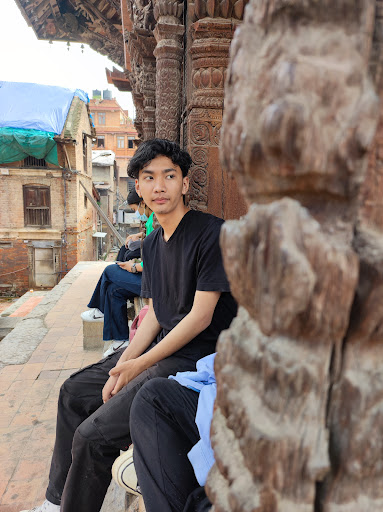

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/ml/Flickr8k_Dataset/Flicker8k_Dataset/01659403106.jpg')
# imagePath = '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'
# img = Image.open(imagePath)
img

In [ ]:
!python3 '/content/drive/MyDrive/ml/testing_caption_generator.py' -i '/content/drive/MyDrive/ml/Flickr8k_Dataset/Flicker8k_Dataset/01659403106.jpg'
# !python3 '/content/drive/MyDrive/ML/testing_caption_generator.py' -i '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'

2023-07-06 09:20:41.501083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/drive/MyDrive/ml/Flickr8k_Dataset/Flicker8k_Dataset/01659403106.jpg
2023-07-06 09:20:44.952070: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
1/1 [==============================] - 3s 3s/step



start man in black shirt is standing on the street end
